**Q1: Build a model to predict the number of home and away corners. Explain the process - including data exploration, features and model selection/comparison, model validation etc.**

Outline for this file are as follows:

**1.) Data Preprocessing**

**2.) Time Series Analysis**

**3.) Point Forecasts**

**4.) Probalistic Forecasts**


Basic notes:

Outlier Handling: Matches with implausible corner counts (e.g., 999) are clearly erroneous and must be removed from the dataset prior to modeling.

Data Leakage Prevention: The variables home_ft_score and away_ft_score reflect full-time outcomes, which are not available at the time of prediction. Including these would result in data leakage. They are therefore excluded, and we instead engineer features using only historical information — such as rolling averages and exponentially weighted moving averages.

Timestamp Issues: While match dates are available, many entries lack precise kickoff times (hour and minute). To address this, we initially impute a default time. However, a more careful imputation might be assigning a realistic time within the day based on competition norms to account for simultaneous matches.

Simultaneous Matches Consideration: Some matches occur concurrently or close in time. To avoid information contamination between games, we define a buffer window (e.g., 3 hours). Matches within this window are forecasted jointly using only information available before the earliest match start. In subsequent matches on the same day, we can incorporate results from earlier matches that day (that are 3 hours or more from the recent kickoff) to ensure the most up-to-date information is used for forecasting.

Team-Based Segmentation: To maintain realistic conditions and minimize data leakage, training data is filtered to only include historical matches involving the same teams (home and away) as the match being forecast. This ensures our model doesn’t rely on information from unrelated teams.

Plots for both point and probabilistic forecasts can be found at the end of this file along with results.

**1.) Data Preprocessing**


To start, we load In relevant Libraries for data preprocessing - data cleaning, removing Nans, dealing with outliers, ordering the data, and engineering new features.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import math

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

Loading in the Data

In [7]:
dat = pd.read_csv(r"C:\Users\ciara\OneDrive\Documents\White_Swan_Data\corners_data.csv")
dat

match_id  home_team_id  away_team_id  competition_id  season_id  \
0       6639468          3161          3162             524     186353   
1       7246115          5649          5656             255     187168   
2      10480359          1613          1636             364     188989   
3       6589718          1610          1631             364     186810   
4       6639315          3161          3158             524     186353   
...         ...           ...           ...             ...        ...   
11625   7535914           686           684             795     187526   
11626   7512279          1640          1618             346     187482   
11627   7536102           680           674             795     187526   
11628   7246108          5707          5663             255     187168   
11629   7606663          3166          3164             524     187528   

                 date_time  gameweek  home_ft_score  away_ft_score  \
0      2021-02-14 19:45:00        22              3              1   
1               2021-08-29        18              0              1   
2      2024-04-27 14:00:00        35              5              1   
3      2021-05-18 19:15:00        37              2              1   
4      2021-05-12 18:45:00        36              3              1   
...                    ...       ...            ...            ...   
11625  2021-08-14 17:30:00         1              1              1   
11626  2021-11-23 19:45:00        19              0              0   
11627  2021-09-22 17:30:00         6              3              1   
11628  2021-12-06 23:00:00        37              1              0   
11629  2022-04-11 18:45:00        32              2              0   

       home_corners  away_corners  
0               4.0           0.0  
1               6.0           4.0  
2               4.0           5.0  
3               6.0           5.0  
4               5.0           8.0  
...             ...           ...  
11625           3.0           3.0  
11626           9.0           1.0  
11627           1.0           4.0  
11628           1.0           2.0  
11629           6.0           0.0  

[11630 rows x 11 columns]

Outlier Analysis: This step focuses on identifying anomalies in the corner and goal data. We examine both missing values and statistical outliers using the Interquartile Range (IQR) and Z-score methods. The primary variables of interest are home/away goals and corners, including their totals and differences.

In [9]:
def analyze_outliers_extended(dat):
    corner_cols = ['home_corners', 'away_corners']
    goal_cols = ['home_ft_score', 'away_ft_score']
    print("=== COMPREHENSIVE OUTLIER ANALYSIS: CORNERS & GOALS ===\n")
    dat['total_corners'] = dat['home_corners'] + dat['away_corners']
    dat['total_goals'] = dat['home_ft_score'] + dat['away_ft_score']
    dat['corner_difference'] = dat['home_corners'] - dat['away_corners']
    dat['goal_difference'] = dat['home_ft_score'] - dat['away_ft_score']
    all_cols = {
        'Corners': ['home_corners', 'away_corners', 'total_corners', 'corner_difference'],
        'Goals': ['home_ft_score', 'away_ft_score', 'total_goals', 'goal_difference']
    }
    print("1. BASIC STATISTICS:")
    print("CORNERS:")
    print(dat[all_cols['Corners']].describe())
    print("\nGOALS:")
    print(dat[all_cols['Goals']].describe())
    print("\n" + "="*60 + "\n")
    print("2. IQR METHOD OUTLIERS:")
    outlier_summary = {}
    for category, cols in all_cols.items():
        print(f"{category.upper()}:")
        for col in cols:
            Q1 = dat[col].quantile(0.25)
            Q3 = dat[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = dat[(dat[col] < lower_bound) | (dat[col] > upper_bound)]
            outlier_summary[col] = {
                'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
                'lower_bound': lower_bound, 'upper_bound': upper_bound,
                'outlier_count': len(outliers),
                'outlier_percentage': len(outliers) / len(dat) * 100
            }
            
            print(f"  {col}:")
            print(f"    Bounds: [{lower_bound:.1f}, {upper_bound:.1f}]")
            print(f"    Outliers: {len(outliers)} ({len(outliers)/len(dat)*100:.2f}%)")
            if len(outliers) > 0:
                print(f"    Outlier values: {sorted(outliers[col].unique())}")
            print()
        print()
    print("3. Z-SCORE METHOD (|z| > 3):")
    for category, cols in all_cols.items():
        print(f"{category.upper()}:")
        for col in cols:
            z_scores = np.abs((dat[col] - dat[col].mean()) / dat[col].std())
            z_outliers = dat[z_scores > 3]
            print(f"  {col}: {len(z_outliers)} outliers ({len(z_outliers)/len(dat)*100:.2f}%)")
            if len(z_outliers) > 0:
                print(f"    Values: {sorted(z_outliers[col].unique())}")
            print()
        print()
    print("4. EXTREME VALUES:")
    for category, cols in all_cols.items():
        print(f"{category.upper()}:")
        for col in cols:
            print(f"  {col}:")
            print(f"    Maximum: {dat[col].max()}")
            print(f"    Top 5 values: {sorted(dat[col].unique())[-5:]}")
            print(f"    Minimum: {dat[col].min()}")
            print(f"    Bottom 5 values: {sorted(dat[col].unique())[:5]}")
            print()
        print()
    print("5. SAMPLE OF EXTREME MATCHES:")
    print("HIGHEST CORNER MATCHES (99th percentile):")
    high_corner_matches = dat[dat['total_corners'] >= dat['total_corners'].quantile(0.99)]
    print(high_corner_matches[['match_id', 'date_time', 'home_corners', 'away_corners', 'total_corners', 'home_ft_score', 'away_ft_score', 'total_goals']].head(10))
    print("\nLOWEST CORNER MATCHES (1st percentile):")
    low_corner_matches = dat[dat['total_corners'] <= dat['total_corners'].quantile(0.01)]
    print(low_corner_matches[['match_id', 'date_time', 'home_corners', 'away_corners', 'total_corners', 'home_ft_score', 'away_ft_score', 'total_goals']].head(10))
    print("\nHI-GHEST SCORING MATCHES (99th percentile):")
    high_goal_matches = dat[dat['total_goals'] >= dat['total_goals'].quantile(0.99)]
    print(high_goal_matches[['match_id', 'date_time', 'home_ft_score', 'away_ft_score', 'total_goals', 'home_corners', 'away_corners', 'total_corners']].head(10))
    print("\nLOWEST SCORING MATCHES (goalless draws):")
    low_goal_matches = dat[(dat['home_ft_score'] == 0) & (dat['away_ft_score'] == 0)]
    print(f"Total goalless draws: {len(low_goal_matches)}")
    print(low_goal_matches[['match_id', 'date_time', 'home_ft_score', 'away_ft_score', 'total_goals', 'home_corners', 'away_corners', 'total_corners']].head(10))
    print("\n6. CORNER-GOAL RELATIONSHIP OUTLIERS:")
    high_corners_low_goals = dat[(dat['total_corners'] >= dat['total_corners'].quantile(0.9)) & 
                               (dat['total_goals'] <= dat['total_goals'].quantile(0.3))]
    print(f"\nHigh corners (90th+ percentile) but low goals (30th- percentile): {len(high_corners_low_goals)} matches")
    if len(high_corners_low_goals) > 0:
        print(high_corners_low_goals[['match_id', 'date_time', 'home_corners', 'away_corners', 'total_corners', 'home_ft_score', 'away_ft_score', 'total_goals']].head())
    low_corners_high_goals = dat[(dat['total_corners'] <= dat['total_corners'].quantile(0.3)) & 
                               (dat['total_goals'] >= dat['total_goals'].quantile(0.9))]
    print(f"\nLow corners (30th- percentile) but high goals (90th+ percentile): {len(low_corners_high_goals)} matches")
    if len(low_corners_high_goals) > 0:
        print(low_corners_high_goals[['match_id', 'date_time', 'home_corners', 'away_corners', 'total_corners', 'home_ft_score', 'away_ft_score', 'total_goals']].head())
    print("\n7. OUTLIER SUMMARY:")
    print("IQR Method Outlier Percentages:")
    for col, info in outlier_summary.items():
        print(f"  {col}: {info['outlier_percentage']:.2f}% ({info['outlier_count']} matches)")
    
    return outlier_summary
outlier_info = analyze_outliers_extended(dat)

=== COMPREHENSIVE OUTLIER ANALYSIS: CORNERS & GOALS ===

1. BASIC STATISTICS:
CORNERS:
       home_corners  away_corners  total_corners  corner_difference
count  11617.000000  11617.000000   11617.000000       11617.000000
mean       6.417913      5.475278      11.893191           0.942636
std       32.052302     32.055764      63.957911           4.385179
min        0.000000      0.000000       0.000000         -17.000000
25%        3.000000      3.000000       7.000000          -2.000000
50%        5.000000      4.000000      10.000000           1.000000
75%        7.000000      6.000000      12.000000           4.000000
max      999.000000    999.000000    1998.000000          23.000000

GOALS:
       home_ft_score  away_ft_score   total_goals  goal_difference
count   11630.000000   11630.000000  11630.000000     11630.000000
mean        1.483663       1.199656      2.683319         0.284007
std         1.263891       1.130203      1.643491         1.745993
min         0.000000     

The analysis identified clear data issues, notably 999 values for corners and fractional corner counts, both of which are invalid and must be removed. 

Using the IQR and Z-score methods, we flagged a small percentage of extreme outliers across corner and goal variables. 

While goal-related outliers appear reasonable, corner outliers—especially those above 20—are more likely to reflect data entry errors. 

A notable subset of matches showed high corner counts with few goals and vice versa, suggesting useful but noisy match dynamics that may inform feature design.

We further inspect corner-related anomalies by examining unusually high corner-to-goal ratios. These checks help flag matches where corner activity appears disproportionate to goal output, possibly indicating noise or stylistic extremes.

In [12]:
def check_contextual_outliers(df):
    print("6. CONTEXTUAL OUTLIER CHECKS:")
    df['corner_to_goal_ratio_home'] = df['home_corners'] / (df['home_ft_score'] + 1)  # +1 to avoid division by zero
    df['corner_to_goal_ratio_away'] = df['away_corners'] / (df['away_ft_score'] + 1)
    high_ratio_home = df[df['corner_to_goal_ratio_home'] > 10]
    high_ratio_away = df[df['corner_to_goal_ratio_away'] > 10]
    print(f"Matches with very high home corner-to-goal ratio (>10): {len(high_ratio_home)}")
    print(f"Matches with very high away corner-to-goal ratio (>10): {len(high_ratio_away)}")
    negative_corners = df[(df['home_corners'] < 0) | (df['away_corners'] < 0)]
    print(f"Matches with negative corners: {len(negative_corners)}")
    zero_corners = df[(df['home_corners'] == 0) & (df['away_corners'] == 0)]
    print(f"Matches with 0 total corners: {len(zero_corners)}")
    return high_ratio_home, high_ratio_away, negative_corners, zero_corners

contextual_outliers = check_contextual_outliers(dat)

6. CONTEXTUAL OUTLIER CHECKS:
Matches with very high home corner-to-goal ratio (>10): 172
Matches with very high away corner-to-goal ratio (>10): 102
Matches with negative corners: 0
Matches with 0 total corners: 1


172 matches had a home corner-to-goal ratio exceeding 10, with 102 matches exceeding this threshold on the away side — indicating unusually high corner generation per goal scored. No matches reported negative corners, and only one match had zero total corners, suggesting relatively clean underlying data.

We begin by identifying all matches where home or away corners are recorded as 999, which is clearly invalid. Rather than impute, we replace these with NaNs to exclude them from model training.

In [15]:
problem_matches = dat[(dat['home_corners'] == 999) | (dat['away_corners'] == 999)]
print("Matches with 999 corners:")
print(problem_matches[['match_id', 'date_time', 'home_corners', 'away_corners']])
dat_clean = dat.copy()
dat_clean.loc[dat_clean['home_corners'] == 999, 'home_corners'] = np.nan
dat_clean.loc[dat_clean['away_corners'] == 999, 'away_corners'] = np.nan
print("After cleaning - new stats:")
print(dat_clean[['home_corners', 'away_corners']].describe())

Matches with 999 corners:
       match_id            date_time  home_corners  away_corners
12     10567020  2023-09-24 11:00:00         999.0         999.0
1245    9967684  2023-11-04 22:30:00         999.0         999.0
1701    6542853  2021-02-27 14:30:00         999.0         999.0
3919    7485459  2021-09-18 16:30:00         999.0         999.0
4682    8785776  2022-08-14 13:00:00         999.0         999.0
5820   10518325  2024-03-05 19:45:00         999.0         999.0
6545    7512299  2021-10-23 14:00:00         999.0         999.0
7612    6594101  2020-11-25 19:45:00         999.0         999.0
8283   10607781  2024-05-04 16:00:00         999.0         999.0
9509    7485493  2021-08-14 14:00:00         999.0         999.0
9647    7536250  2021-10-03 12:00:00         999.0         999.0
10463   7512347  2021-10-23 14:00:00         999.0         999.0
After cleaning - new stats:
       home_corners  away_corners
count  11605.000000  11605.000000
mean       5.391547      4.447936

Twelve matches were found with corner values of 999, all of which were successfully replaced with missing values. After cleaning, the new max values (23 for home, 19 for away) fall within plausible bounds, and further outlier filtering is no longer necessary.

Before final cleaning, we identify any fractional corner values, which are logically invalid in football match statistics. These must be rounded or removed to maintain data integrity.

In [18]:
fractional_corners = dat[(dat['home_corners'] % 1 != 0) | (dat['away_corners'] % 1 != 0)]
print("Matches with fractional corners:")
print(fractional_corners[['match_id', 'home_corners', 'away_corners']])

Matches with fractional corners:
       match_id  home_corners  away_corners
310    10572063           NaN           NaN
934     8819618           NaN           NaN
2023    8776839           9.1           2.6
2178   10567197           NaN           NaN
2256   11932897           NaN           NaN
2348   10572206           NaN           NaN
2784   10572258           NaN           NaN
2888   10572288           NaN           NaN
3228    7246226           5.0          10.3
4373   10572288           NaN           NaN
5183    6593731           7.5           6.6
5270    6542922           5.3           2.5
7326    6639587           NaN           NaN
8499    7246113           7.9           6.1
8913    7246017           NaN           NaN
9351   10572260           NaN           NaN
10102   9967566           6.4           3.7
10310  10567247           NaN           NaN
10851  10521332           5.7           7.5
11155  10572297           NaN           NaN


A small number of matches (13 total) included non-integer corner counts, which were rounded to the nearest whole number. This ensures the dataset reflects valid match statistics for both home and away teams.

This step consolidates all cleaning processes — removing invalid entries (e.g., 999s), rounding fractional values, flagging implausible outliers, and imputing missing data using competition and season averages.

In [21]:
def data_cleaning(df):    
    df_clean = df.copy()
    cleaning_log = []
    print("1. CLEANING 999 VALUES:")
    mask_999 = (df_clean['home_corners'] == 999) | (df_clean['away_corners'] == 999)
    count_999 = mask_999.sum()
    df_clean.loc[mask_999, ['home_corners', 'away_corners']] = np.nan
    print(f"   Replaced {count_999} matches with 999 values -> NaN")
    cleaning_log.append(f"999 values: {count_999} matches")
    print("\n2. CLEANING FRACTIONAL VALUES:")
    home_fractional = df_clean['home_corners'].notna() & (df_clean['home_corners'] % 1 != 0)
    away_fractional = df_clean['away_corners'].notna() & (df_clean['away_corners'] % 1 != 0)
    count_home_frac = home_fractional.sum()
    count_away_frac = away_fractional.sum()
    print(f"   Found {count_home_frac} fractional home corner values")
    print(f"   Found {count_away_frac} fractional away corner values")
    if count_home_frac > 0:
        print("   Fractional home values:", df_clean.loc[home_fractional, 'home_corners'].values)
    if count_away_frac > 0:
        print("   Fractional away values:", df_clean.loc[away_fractional, 'away_corners'].values)
    df_clean.loc[home_fractional, 'home_corners'] = df_clean.loc[home_fractional, 'home_corners'].round()
    df_clean.loc[away_fractional, 'away_corners'] = df_clean.loc[away_fractional, 'away_corners'].round()
    cleaning_log.append(f"Fractional values: {count_home_frac + count_away_frac} values rounded")
    print("\n3. CHECKING FOR NEGATIVE VALUES:")
    negative_home = (df_clean['home_corners'] < 0).sum()
    negative_away = (df_clean['away_corners'] < 0).sum()
    print(f"   Negative home corners: {negative_home}")
    print(f"   Negative away corners: {negative_away}")
    if negative_home > 0 or negative_away > 0:
        df_clean.loc[df_clean['home_corners'] < 0, 'home_corners'] = np.nan
        df_clean.loc[df_clean['away_corners'] < 0, 'away_corners'] = np.nan
        cleaning_log.append(f"Negative values: {negative_home + negative_away} values set to NaN")
    print("\n4. CHECKING FOR EXTREMELY HIGH VALUES:")
    high_home = (df_clean['home_corners'] > 25).sum()
    high_away = (df_clean['away_corners'] > 25).sum()
    print(f"   Home corners >25: {high_home}")
    print(f"   Away corners >25: {high_away}")
    if high_home > 0:
        extreme_home = df_clean[df_clean['home_corners'] > 25]
        print("   Extreme home values:", extreme_home[['match_id', 'home_corners', 'away_corners']].values)
    if high_away > 0:
        extreme_away = df_clean[df_clean['away_corners'] > 25]
        print("   Extreme away values:", extreme_away[['match_id', 'home_corners', 'away_corners']].values)
    print("\n5. MISSING DATA SUMMARY:")
    total_missing_home = df_clean['home_corners'].isna().sum()
    total_missing_away = df_clean['away_corners'].isna().sum()
    total_missing_either = (df_clean['home_corners'].isna() | df_clean['away_corners'].isna()).sum()
    print(f"   Missing home corners: {total_missing_home}")
    print(f"   Missing away corners: {total_missing_away}")
    print(f"   Matches missing either corner data: {total_missing_either}")
    print("\n6. CREATING CLEAN DATASETS:")
    df_complete_cases = df_clean.dropna(subset=['home_corners', 'away_corners']).copy()
    df_imputed = df_clean.copy()
    if 'competition_id' in df_imputed.columns and 'season_id' in df_imputed.columns:
        home_means = df_imputed.groupby(['competition_id', 'season_id'])['home_corners'].transform('mean')
        away_means = df_imputed.groupby(['competition_id', 'season_id'])['away_corners'].transform('mean')
        df_imputed['home_corners'] = df_imputed['home_corners'].fillna(home_means)
        df_imputed['away_corners'] = df_imputed['away_corners'].fillna(away_means)
        df_imputed['home_corners'] = df_imputed['home_corners'].fillna(df_imputed['home_corners'].mean())
        df_imputed['away_corners'] = df_imputed['away_corners'].fillna(df_imputed['away_corners'].mean())
        print(f"   Used competition/season-based imputation")
    else:
        df_imputed['home_corners'] = df_imputed['home_corners'].fillna(df_imputed['home_corners'].mean())
        df_imputed['away_corners'] = df_imputed['away_corners'].fillna(df_imputed['away_corners'].mean())
        print(f"   Used overall mean imputation")
    df_imputed['home_corners'] = df_imputed['home_corners'].round()
    df_imputed['away_corners'] = df_imputed['away_corners'].round()
    print(f"   Complete cases dataset: {len(df_complete_cases)} matches")
    print(f"   Imputed dataset: {len(df_imputed)} matches")
    print(f"   Original dataset: {len(df)} matches")
    print("\n7. FINAL CLEANED DATA STATISTICS:")
    print("\nComplete Cases Dataset:")
    print(df_complete_cases[['home_corners', 'away_corners']].describe())
    print("\nImputed Dataset:")
    print(df_imputed[['home_corners', 'away_corners']].describe())
    print(f"\n8. DATA CLEANING SUMMARY:")
    print(f"   Original matches: {len(df)}")
    for log_entry in cleaning_log:
        print(f"   - {log_entry}")
    print(f"   Final complete cases: {len(df_complete_cases)} ({len(df_complete_cases)/len(df)*100:.1f}%)")
    print(f"   Data loss: {len(df) - len(df_complete_cases)} matches ({(len(df) - len(df_complete_cases))/len(df)*100:.1f}%)")
    return df_complete_cases, df_imputed, cleaning_log

#We validate the cleaned dataset by confirming there are no missing, fractional, or negative values, 
#and that the statistical ranges for corners remain reasonable.
def validate_cleaned_data(df):    
    print(f"Home corners range: {df['home_corners'].min():.0f} - {df['home_corners'].max():.0f}")
    print(f"Away corners range: {df['away_corners'].min():.0f} - {df['away_corners'].max():.0f}")
    print(f"Any NaN values: {df[['home_corners', 'away_corners']].isna().sum().sum()}")
    print(f"Any non-integer values: {((df['home_corners'] % 1 != 0) | (df['away_corners'] % 1 != 0)).sum()}")
    print(f"Any negative values: {((df['home_corners'] < 0) | (df['away_corners'] < 0)).sum()}")
    df['total_corners'] = df['home_corners'] + df['away_corners']
    print(f"Matches: {len(df)}")
    print(f"Mean corners: {df['home_corners'].mean():.2f} home, {df['away_corners'].mean():.2f} away")
    print(f"Total corners range: {df['total_corners'].min():.0f} - {df['total_corners'].max():.0f}")
    return df
df_clean, df_imputed, log = data_cleaning(dat)
dat = validate_cleaned_data(df_clean)  # we just want the cleaned data. Imputed isnt massively beneficial.
dat=dat.dropna()

1. CLEANING 999 VALUES:
   Replaced 12 matches with 999 values -> NaN

2. CLEANING FRACTIONAL VALUES:
   Found 6 fractional home corner values
   Found 7 fractional away corner values
   Fractional home values: [9.1 7.5 5.3 7.9 6.4 5.7]
   Fractional away values: [ 2.6 10.3  6.6  2.5  6.1  3.7  7.5]

3. CHECKING FOR NEGATIVE VALUES:
   Negative home corners: 0
   Negative away corners: 0

4. CHECKING FOR EXTREMELY HIGH VALUES:
   Home corners >25: 0
   Away corners >25: 0

5. MISSING DATA SUMMARY:
   Missing home corners: 25
   Missing away corners: 25
   Matches missing either corner data: 25

6. CREATING CLEAN DATASETS:
   Used competition/season-based imputation
   Complete cases dataset: 11605 matches
   Imputed dataset: 11630 matches
   Original dataset: 11630 matches

7. FINAL CLEANED DATA STATISTICS:

Complete Cases Dataset:
       home_corners  away_corners
count  11605.000000  11605.000000
mean       5.391555      4.447997
std        2.918589      2.608122
min        0.000000 

The dataset was cleaned by removing 999 entries, rounding 13 fractional values, and confirming that no negative or extreme values (>25 corners) remained. After dropping rows with missing data, 11605 complete cases were retained (99.8%), ensuring a clean, reliable dataset for modeling.

Post-cleaning, all corner values are integer, non-negative, and fall within a plausible range (0–23 home, 0–19 away). The data is now ready for modeling, with complete coverage across all features and a mean of ~10 total corners per match.

To assess the distribution of our cleaned variables, we visualize goals and corners using histograms and boxplots, both individually and in aggregate.

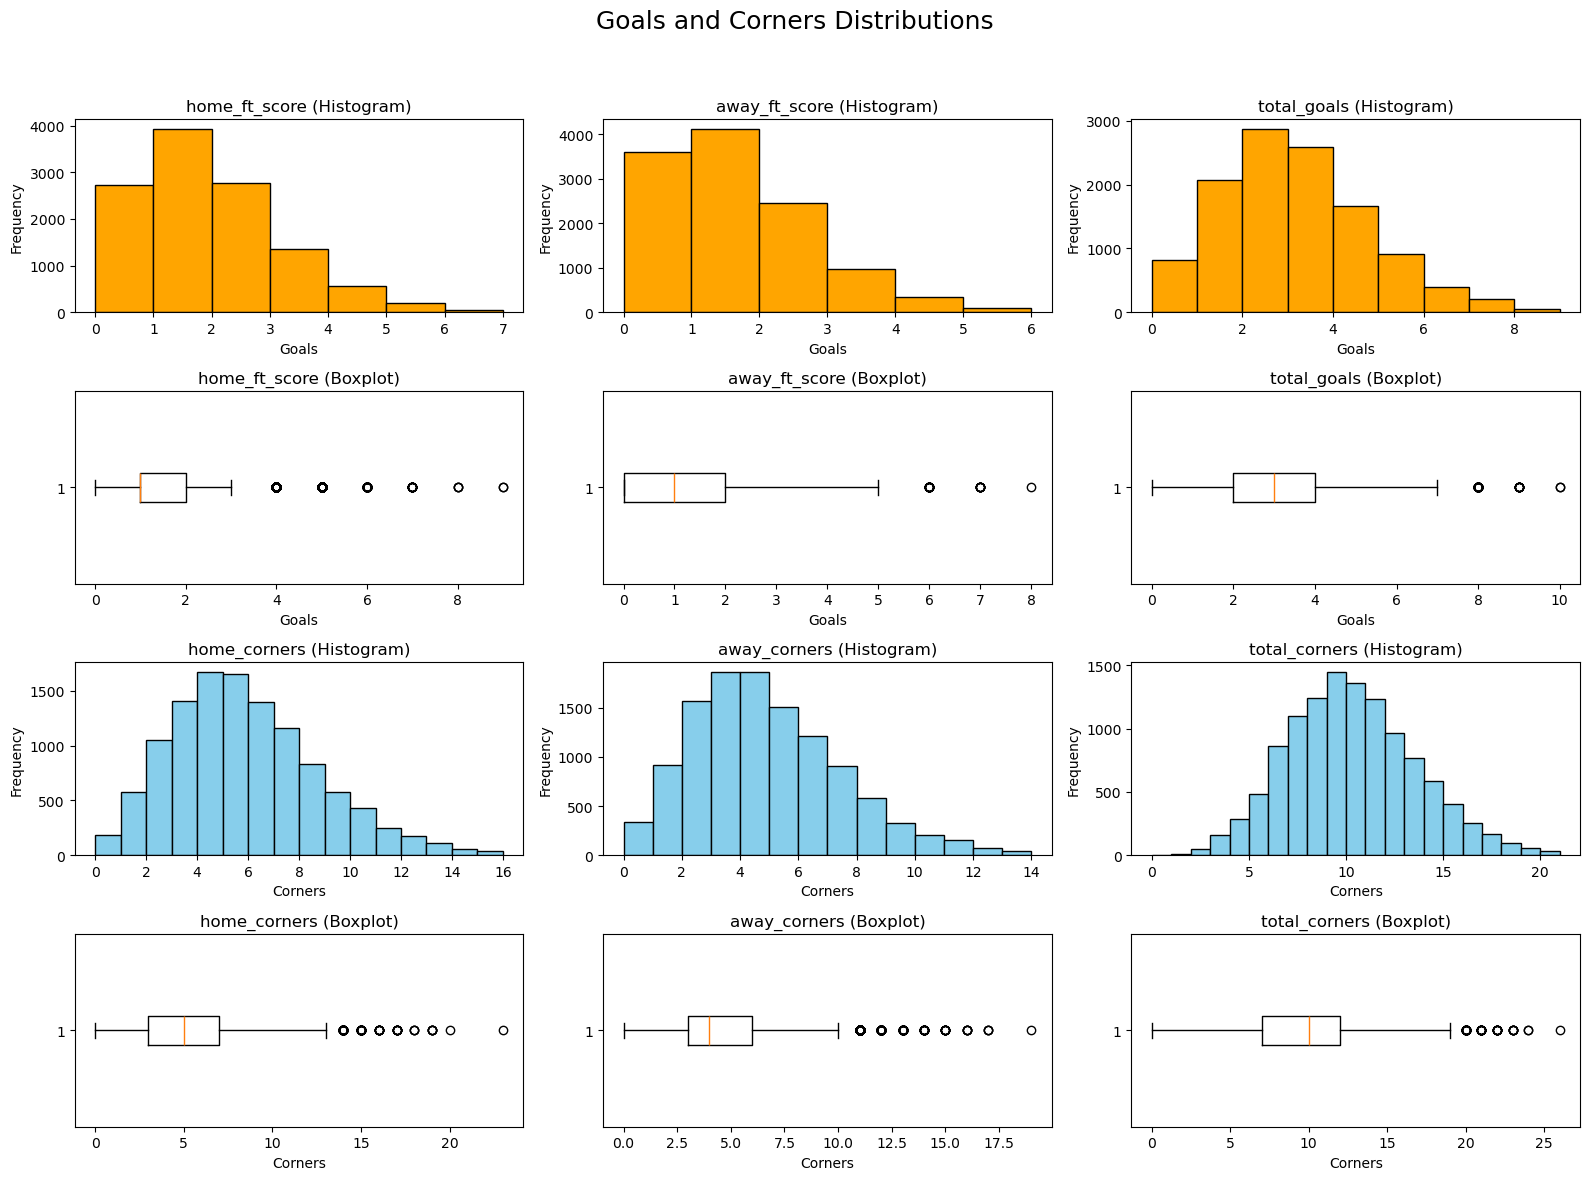

In [25]:
def plot_goals_and_corners(df, corner_sentinels=(999, 1998), zoom_q=0.995):
    df = df.copy()
    for v in corner_sentinels:
        df.replace(v, np.nan, inplace=True)
    df["total_goals"] = df["home_ft_score"] + df["away_ft_score"]
    df["total_corners"] = df["home_corners"] + df["away_corners"]
    goal_cols = ["home_ft_score", "away_ft_score", "total_goals"]
    corner_cols = ["home_corners", "away_corners", "total_corners"]
    fig, axes = plt.subplots(4, 3, figsize=(16, 12))
    fig.suptitle("Goals and Corners Distributions", fontsize=18)
    for i, col in enumerate(goal_cols):
        trimmed = df[col][df[col] <= df[col].quantile(zoom_q)]
        axes[0, i].hist(trimmed, bins=range(0, int(trimmed.max()) + 2), edgecolor='black', color='orange')
        axes[0, i].set_title(f"{col} (Histogram)")
        axes[0, i].set_xlabel("Goals")
        axes[0, i].set_ylabel("Frequency")
        axes[1, i].boxplot(df[col].dropna(), vert=False)
        axes[1, i].set_title(f"{col} (Boxplot)")
        axes[1, i].set_xlabel("Goals")
    for i, col in enumerate(corner_cols):
        trimmed = df[col][df[col] <= df[col].quantile(zoom_q)]
        axes[2, i].hist(trimmed, bins=range(0, int(trimmed.max()) + 2), edgecolor='black', color='skyblue')
        axes[2, i].set_title(f"{col} (Histogram)")
        axes[2, i].set_xlabel("Corners")
        axes[2, i].set_ylabel("Frequency")
        axes[3, i].boxplot(df[col].dropna(), vert=False)
        axes[3, i].set_title(f"{col} (Boxplot)")
        axes[3, i].set_xlabel("Corners")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
plot_goals_and_corners(dat)

Goal and corner distributions are right-skewed at the team level, reflecting common low-scoring outcomes. However, total goals and total corners show a more bell-shaped distribution, making them more amenable to standard regression techniques.

To enable proper time series modeling, we ensure the dataset is chronologically ordered. Since some entries lack full timestamp precision, we impute missing hours/minutes/seconds with a default time to retain consistency.

In [29]:
DEFAULT_TIME = "12:00:00"
s = dat["date_time"].astype(str).str.strip()
s = s.str.replace("T", " ", regex=False).str.replace("/", "-", regex=False)
mask_date_only    = s.str.match(r"^\d{4}-\d{2}-\d{2}$")
mask_no_seconds   = s.str.match(r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$")
s.loc[mask_date_only]  = s.loc[mask_date_only]  + f" {DEFAULT_TIME}"
s.loc[mask_no_seconds] = s.loc[mask_no_seconds] + ":00"
dat["date_time"] = pd.to_datetime(s, errors="coerce")
dat = dat.sort_values("date_time").reset_index(drop=True)
print("NaTs:", dat["date_time"].isna().sum())
nan_counts = dat.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

NaTs: 0
Columns with missing values:

Series([], dtype: int64)


All date entries were successfully standardized and converted into valid datetime objects with no resulting NaT values. The dataset is now properly ordered in time, forming a reliable foundation for time-dependent feature engineering and model validation.

We explore relationships between the target variables (home_corners, away_corners) and both original and engineered predictors. This visual EDA helps us understand feature relevance and identify sources of data leakage before modeling.

C:\Users\ciara\AppData\Local\Temp\ipykernel_46792\2388297313.py:2: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["date_time_numeric"] = pd.to_datetime(df["date_time"]).view("int64") // 10**9


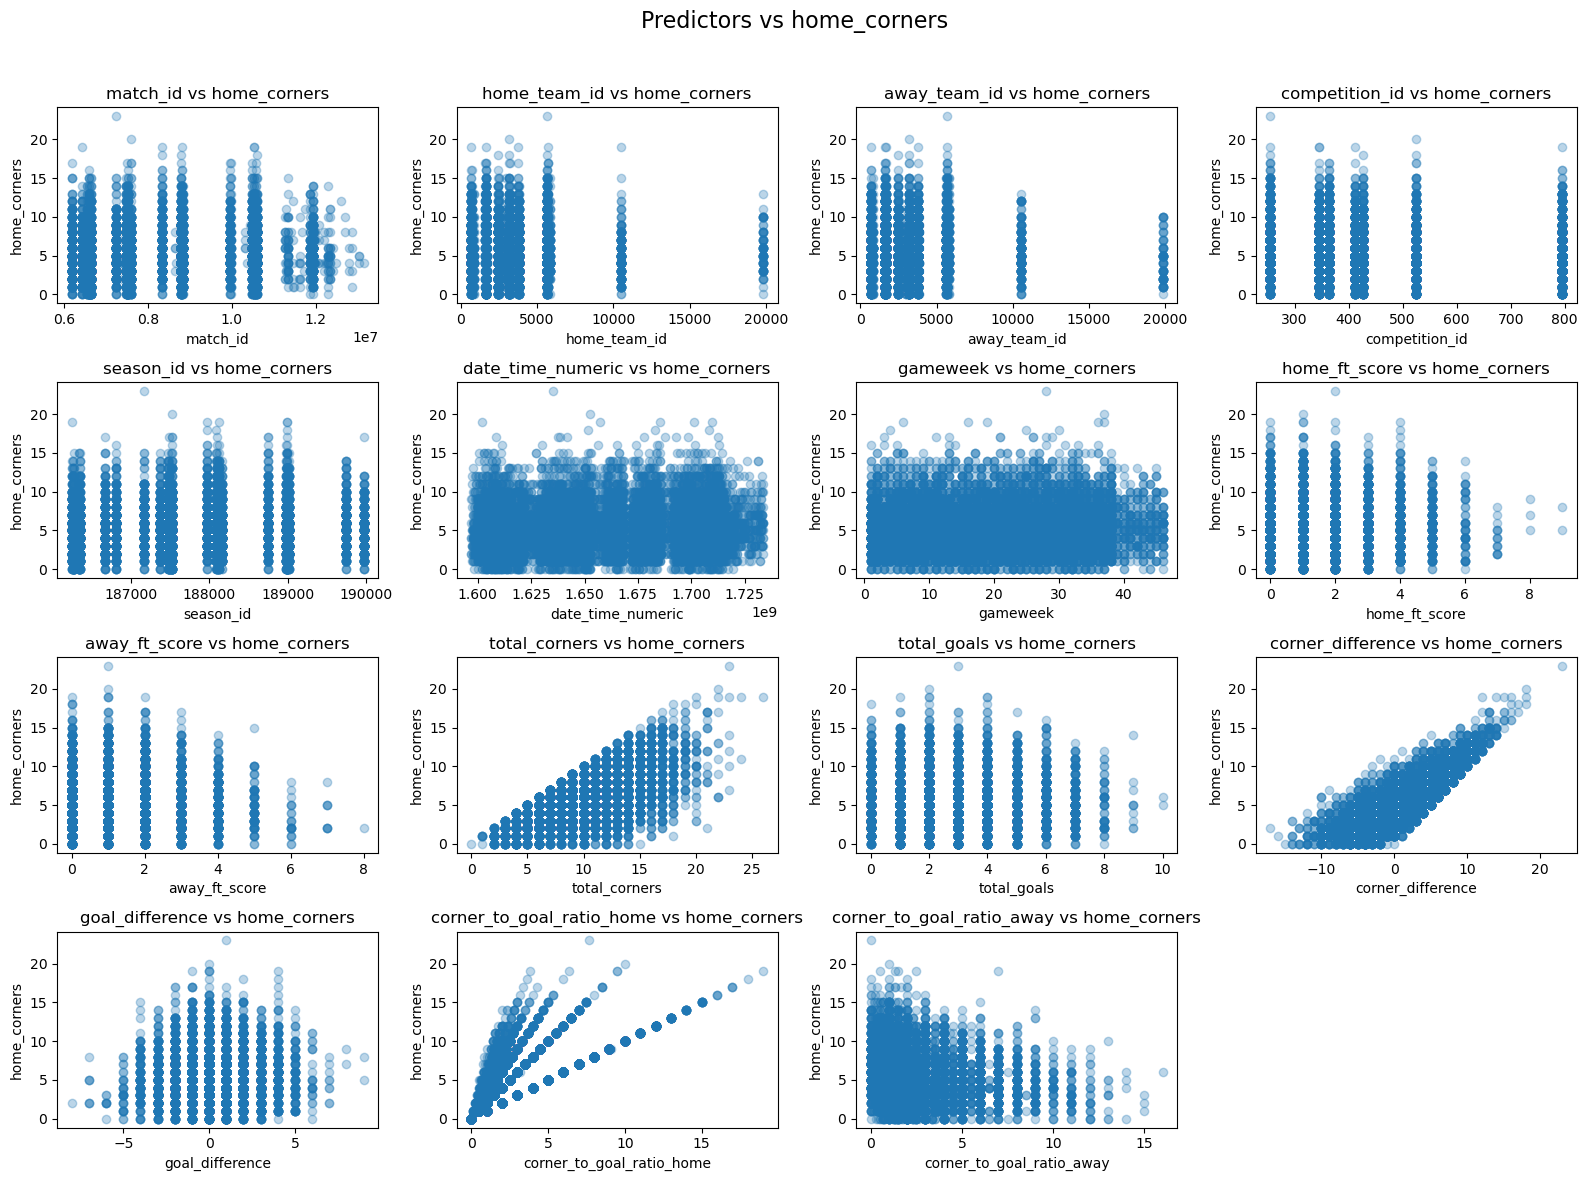

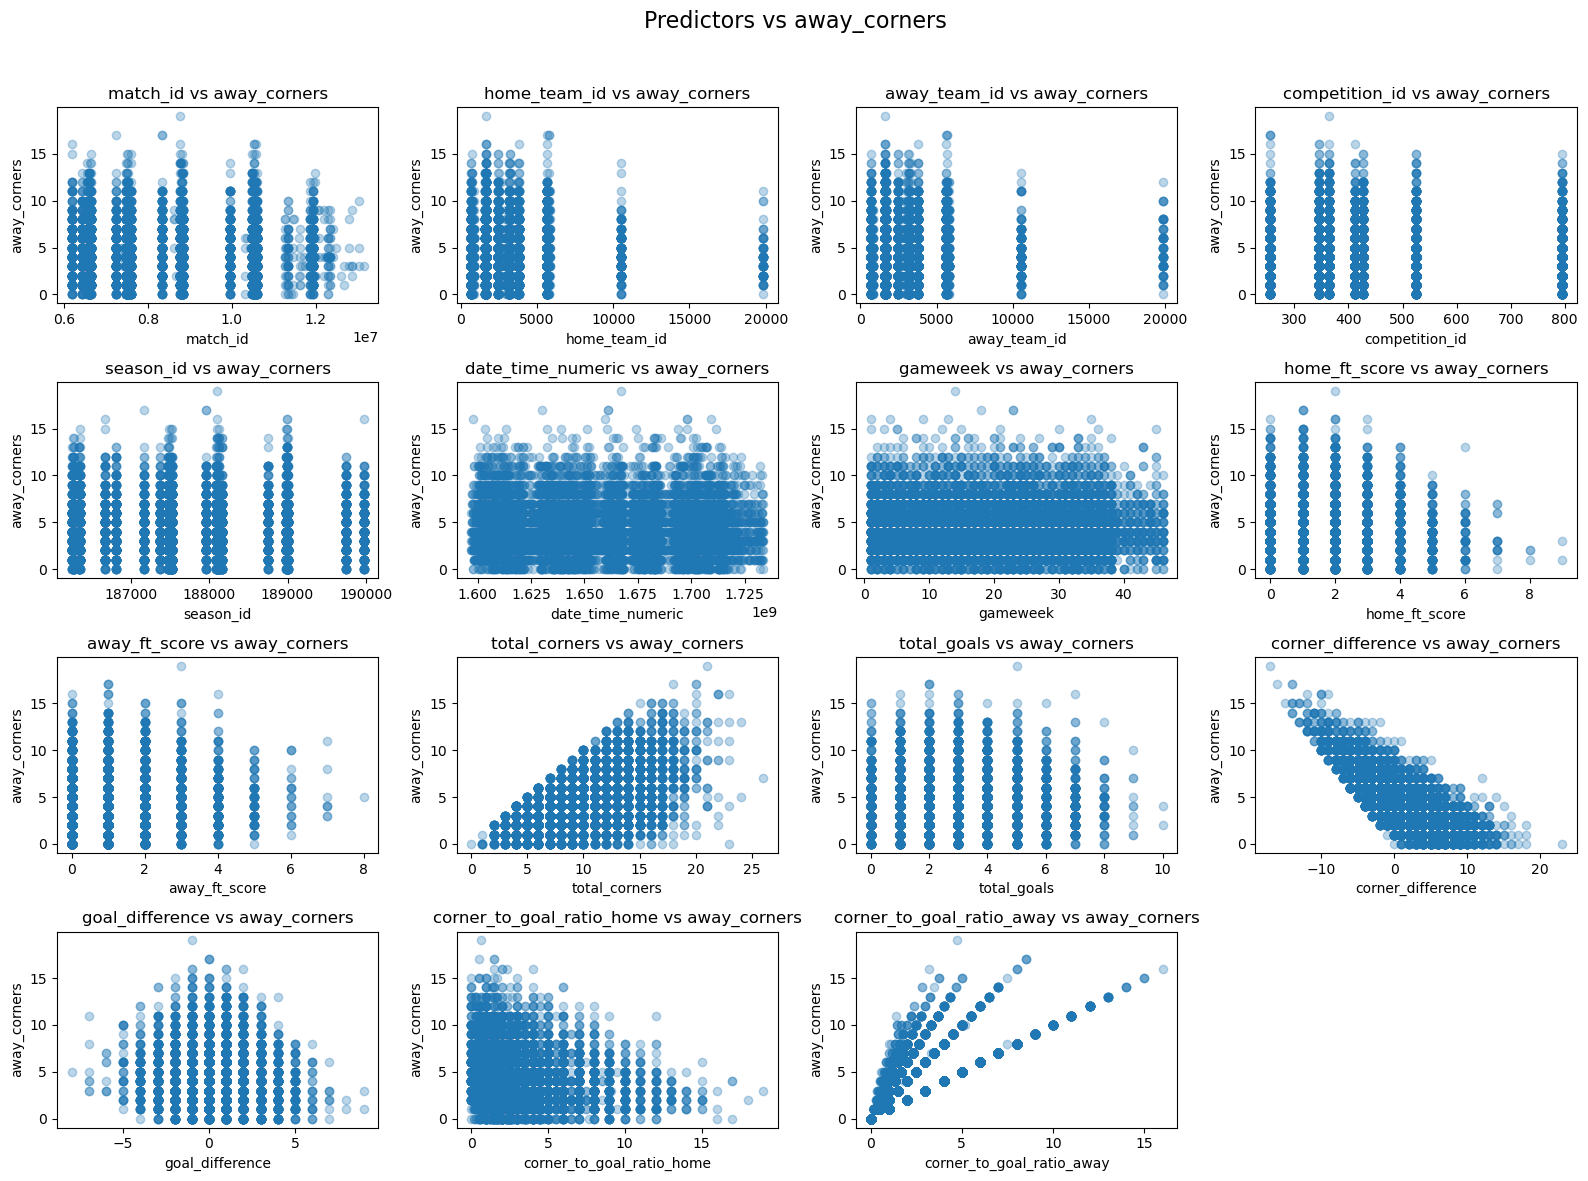

In [31]:
df = dat.copy()
df["date_time_numeric"] = pd.to_datetime(df["date_time"]).view("int64") // 10**9
dep_vars = ["home_corners", "away_corners"]
orig_predictors = ["match_id", "home_team_id", "away_team_id", "competition_id",  "season_id", "date_time_numeric", "gameweek",
    "home_ft_score", "away_ft_score",]
created_predictors = ["total_corners", "total_goals", "corner_difference", "goal_difference", "corner_to_goal_ratio_home",  "corner_to_goal_ratio_away",]
predictors = orig_predictors + created_predictors
cols = 4
rows = math.ceil(len(predictors) / cols)
for target in dep_vars:
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axes = axes.flatten()
    for i, pred in enumerate(predictors):
        axes[i].scatter(df[pred], df[target], alpha=0.3)
        axes[i].set_title(f"{pred} vs {target}")
        axes[i].set_xlabel(pred)
        axes[i].set_ylabel(target)
    for ax in axes[len(predictors) :]:
        ax.set_visible(False)
    fig.suptitle(f"Predictors vs {target}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Scatter plots show strong vertical banding for categorical identifiers like team and competition IDs, suggesting persistent team-level corner behaviors. Engineered features like total_corners and corner_difference exhibit deterministic relationships with the targets and must be excluded to avoid leakage and collinearity.

Goal-based features show weak, noisy correlations with corner counts but represent leakage if not lagged, as full-time scores aren’t known at prediction time. Temporal predictors show minimal signal, and heavy-tailed patterns in ratios like corner_to_goal_ratio_home suggest potential for transformation or non-linear modeling techniques.

First Lets Focus on the New Features. In this transformation pipeline, we engineered a set of features to capture historical team performance, match dynamics, and contextual timing information. These include rolling means and exponentially weighted averages of corners and goals over the past five matches, both for teams playing at home and away. We added head-to-head corner averages, rest day differentials, cyclical encodings for weekday, kickoff time, and gameweek, as well as broader team form features aggregating recent performance regardless of home or away status. 
Additional metrics like corner win streaks, corner trend deltas, and normalized league-season corner z-scores provide contextual depth useful for model training. 

To avoid data leakage and maintain a clean dataset, we dropped all outcome-related columns such as full-time scores, total goals and corners, and derived statistics like goal or corner differences and ratios. We also removed intermediate columns used during feature generation like pair_key, match_total_corners, and previous match timestamps, as well as raw weekday and hour columns after encoding them sinusoidally. This ensures the final dataset contains only features available prior to the match and no labels or post-match outcomes.

In [38]:
old_dat=dat #For sense checks
N = 5
DEFAULT_TIME = "12:00:00"
s = dat["date_time"].astype(str).str.strip()
s = s.str.replace("T", " ", regex=False).str.replace("/", "-", regex=False)
mask_date_only = s.str.match(r"^\d{4}-\d{2}-\d{2}$")
mask_no_seconds = s.str.match(r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$")
s.loc[mask_date_only] = s.loc[mask_date_only] + f" {DEFAULT_TIME}"
s.loc[mask_no_seconds] = s.loc[mask_no_seconds] + ":00"
dat["date_time"] = pd.to_datetime(s, errors="coerce")
dat = dat.sort_values(["date_time", "match_id"]).reset_index(drop=True)
dat["home_corners_mean_5"] = dat.groupby("home_team_id")["home_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["home_goals_mean_5"] = dat.groupby("home_team_id")["home_ft_score"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["home_corners_conceded_mean_5"] = dat.groupby("home_team_id")["away_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["away_corners_mean_5"] = dat.groupby("away_team_id")["away_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["away_goals_mean_5"] = dat.groupby("away_team_id")["away_ft_score"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["away_corners_conceded_mean_5"] = dat.groupby("away_team_id")["home_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["home_corners_ewm_5"] = dat.groupby("home_team_id")["home_corners"].transform(lambda s: s.shift().ewm(span=N, adjust=False).mean())
dat["away_corners_ewm_5"] = dat.groupby("away_team_id")["away_corners"].transform(lambda s: s.shift().ewm(span=N, adjust=False).mean())
dat["pair_key"] = dat.apply(lambda r: f"{min(r.home_team_id, r.away_team_id)}_{max(r.home_team_id, r.away_team_id)}", axis=1)
dat["match_total_corners"] = dat["home_corners"] + dat["away_corners"]
dat["h2h_corners_mean_5"] = dat.groupby("pair_key")["match_total_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["expected_corner_diff_form"] = dat["home_corners_mean_5"] - dat["away_corners_conceded_mean_5"]
dat["expected_corner_ratio_form"] = dat["home_corners_mean_5"] / (dat["away_corners_conceded_mean_5"] + 1e-6)
dat["home_prev_dt"] = dat.groupby("home_team_id")["date_time"].shift()
dat["away_prev_dt"] = dat.groupby("away_team_id")["date_time"].shift()
dat["home_rest_days"] = (dat["date_time"] - dat["home_prev_dt"]).dt.days
dat["away_rest_days"] = (dat["date_time"] - dat["away_prev_dt"]).dt.days
dat["rest_days_diff"] = dat["home_rest_days"] - dat["away_rest_days"]
dat["dow"] = dat["date_time"].dt.weekday
dat["dow_sin"] = np.sin(2 * np.pi * dat["dow"] / 7)
dat["dow_cos"] = np.cos(2 * np.pi * dat["dow"] / 7)
dat["gw_sin"] = np.sin(2 * np.pi * dat["gameweek"] / 38)
dat["gw_cos"] = np.cos(2 * np.pi * dat["gameweek"] / 38)
dat["ko_hour"] = dat["date_time"].dt.hour + dat["date_time"].dt.minute / 60
dat["ko_sin"] = np.sin(2 * np.pi * dat["ko_hour"] / 24)
dat["ko_cos"] = np.cos(2 * np.pi * dat["ko_hour"] / 24)
long_df = pd.concat([dat[["date_time", "home_team_id", "home_corners", "away_corners"]].rename(columns={"home_team_id": "team_id", "home_corners": "corners_for",
        "away_corners": "corners_against"}),
    dat[["date_time", "away_team_id", "away_corners", "home_corners"]].rename(columns={"away_team_id": "team_id", "away_corners": "corners_for",
        "home_corners": "corners_against"})])
long_df = long_df.sort_values(["team_id", "date_time"])
long_df["rolling_corners_mean_5"] = long_df.groupby("team_id")["corners_for"].transform(lambda s: s.shift().rolling(N, 1).mean())
long_df["rolling_corners_std_5"] = long_df.groupby("team_id")["corners_for"].transform(lambda s: s.shift().rolling(N, 1).std())
long_df["corner_trend_5"] = long_df.groupby("team_id")["corners_for"].transform(lambda s: s.shift().rolling(N, 2).mean().diff())
dat = dat.merge(long_df[["team_id", "date_time", "rolling_corners_mean_5", "rolling_corners_std_5", "corner_trend_5"]], left_on=["home_team_id", "date_time"], right_on=["team_id", "date_time"], how="left"
).rename(columns={"rolling_corners_mean_5": "home_form_mean_corners", "rolling_corners_std_5": "home_form_std_corners", "corner_trend_5": "home_corner_trend"}).drop(columns=["team_id"])
dat = dat.merge(long_df[["team_id", "date_time", "rolling_corners_mean_5", "rolling_corners_std_5", "corner_trend_5"]], left_on=["away_team_id", "date_time"], right_on=["team_id", "date_time"], how="left"
).rename(columns={"rolling_corners_mean_5": "away_form_mean_corners", "rolling_corners_std_5": "away_form_std_corners", "corner_trend_5": "away_corner_trend"}).drop(columns=["team_id"])
dat["home_corner_win"] = (dat["home_corners"] > dat["away_corners"]).astype(int)
dat["away_corner_win"] = (dat["away_corners"] > dat["home_corners"]).astype(int)
dat["home_corner_win_streak"] = dat.groupby("home_team_id")["home_corner_win"].transform(lambda s: s.shift().rolling(N, 1).sum())
dat["away_corner_win_streak"] = dat.groupby("away_team_id")["away_corner_win"].transform(lambda s: s.shift().rolling(N, 1).sum())
dat["home_games_played"] = dat.groupby("home_team_id")["match_id"].transform(lambda s: s.shift().rolling(N, 1).count())
dat["away_games_played"] = dat.groupby("away_team_id")["match_id"].transform(lambda s: s.shift().rolling(N, 1).count())
league_corner_mean = dat.groupby(["competition_id", "season_id"])["match_total_corners"].transform("mean")
league_corner_std = dat.groupby(["competition_id", "season_id"])["match_total_corners"].transform("std")
dat["match_total_corners_z"] = (dat["match_total_corners"] - league_corner_mean) / (league_corner_std + 1e-6)
dat = dat.drop(columns=["home_ft_score", "away_ft_score", "total_corners", "total_goals", "corner_difference", "goal_difference", "corner_to_goal_ratio_home",
    "corner_to_goal_ratio_away", "match_total_corners", "pair_key", "home_prev_dt", "away_prev_dt", "dow", "ko_hour", "home_corner_win", "away_corner_win"], errors="ignore")

The resulting dataset includes rolling and exponentially weighted stats, rest-day gaps, head-to-head averages, cyclical time encodings, and trend-based indicators for both teams. Post-feature engineering, all outcome-based or post-match variables are removed to preserve strict pre-match forecasting validity.

After applying rolling windows, shifts, and merges, we check for missing values introduced by lack of history in earlier matches. This step ensures we understand where imputation or special handling is required.

In [40]:
nan_counts = dat.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

Columns with missing values:

h2h_corners_mean_5              2485
away_corner_trend                290
home_corner_trend                286
expected_corner_diff_form        239
expected_corner_ratio_form       239
rest_days_diff                   239
away_form_std_corners            189
away_corners_mean_5              186
away_goals_mean_5                186
away_corners_conceded_mean_5     186
away_corners_ewm_5               186
away_rest_days                   186
home_corners_mean_5              183
home_form_std_corners            183
home_rest_days                   183
home_goals_mean_5                183
home_corners_ewm_5               183
home_corners_conceded_mean_5     183
home_corner_win_streak           180
away_corner_win_streak           180
home_form_mean_corners            92
away_form_mean_corners            91
dtype: int64


As expected, features relying on team history (like rolling averages, win streaks, or rest days) show missing values for early-season matches. Head-to-head metrics exhibit the highest sparsity, due to fewer past encounters between many team pairs.

We now impute missing values using context-sensitive defaults to preserve predictive signal while avoiding information leakage. Strategies vary depending on feature type — from zero-filling and league averages to using fallback aggregations and global statistics.

Rolling and shift-based features were filled with zero to reflect a lack of prior matches, while exponentially weighted means fell back to their corresponding rolling means, then zero. 

Head-to-head features were imputed with the league-average corners, assuming no prior history between teams. Rest day gaps were filled with the median to reflect a typical recovery window, and form standard deviations used the global standard deviation to normalize variability. 

Derived features like differences and ratios defaulted to zero, representing a neutral baseline when inputs were unavailable. 

In [42]:
dat["h2h_corners_mean_5_isna"] = dat["h2h_corners_mean_5"].isna().astype(int)
dat["match_total_corners"] = dat["home_corners"] + dat["away_corners"]
league_avg_corners = dat["match_total_corners"].mean()
dat["h2h_corners_mean_5"] = dat["h2h_corners_mean_5"].fillna(league_avg_corners)
dat["expected_corner_diff_form"] = dat["expected_corner_diff_form"].fillna(0)
dat["expected_corner_ratio_form"] = dat["expected_corner_ratio_form"].fillna(0)
dat["home_corner_trend"] = dat["home_corner_trend"].fillna(0)
dat["away_corner_trend"] = dat["away_corner_trend"].fillna(0)
rolling_mean_cols = ["home_corners_mean_5", "away_corners_mean_5", "home_goals_mean_5", "away_goals_mean_5", "home_corners_conceded_mean_5", "away_corners_conceded_mean_5"]
dat[rolling_mean_cols] = dat[rolling_mean_cols].fillna(0)
dat["home_corners_ewm_5"] = dat["home_corners_ewm_5"].fillna(dat["home_corners_mean_5"])
dat["away_corners_ewm_5"] = dat["away_corners_ewm_5"].fillna(dat["away_corners_mean_5"])
dat["home_corners_ewm_5"] = dat["home_corners_ewm_5"].fillna(0)
dat["away_corners_ewm_5"] = dat["away_corners_ewm_5"].fillna(0)
dat["home_rest_days"] = dat["home_rest_days"].fillna(dat["home_rest_days"].median())
dat["away_rest_days"] = dat["away_rest_days"].fillna(dat["away_rest_days"].median())
dat["rest_days_diff"] = dat["rest_days_diff"].fillna(0)
dat["home_form_mean_corners"] = dat["home_form_mean_corners"].fillna(dat["home_corners_mean_5"])
dat["away_form_mean_corners"] = dat["away_form_mean_corners"].fillna(dat["away_corners_mean_5"])
dat["home_form_mean_corners"] = dat["home_form_mean_corners"].fillna(0)
dat["away_form_mean_corners"] = dat["away_form_mean_corners"].fillna(0)
global_std = dat["match_total_corners"].std()
dat["home_form_std_corners"] = dat["home_form_std_corners"].fillna(global_std)
dat["away_form_std_corners"] = dat["away_form_std_corners"].fillna(global_std)
dat["home_corner_win_streak"] = dat["home_corner_win_streak"].fillna(0)
dat["away_corner_win_streak"] = dat["away_corner_win_streak"].fillna(0)
nan_counts = dat.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

Columns with missing values:

Series([], dtype: int64)


All missing values have been successfully imputed using appropriate logic: historical absence defaults to zeros, trends to neutral baselines, and head-to-head stats to league-wide averages. The final dataset is complete, consistent, and ready for modeling with no remaining NaNs.

We visualize the relationships between all numeric predictors and the target variables (home_corners, away_corners) using scatter plots with local smoothing and correlation scores. This helps identify features with potential predictive power.

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


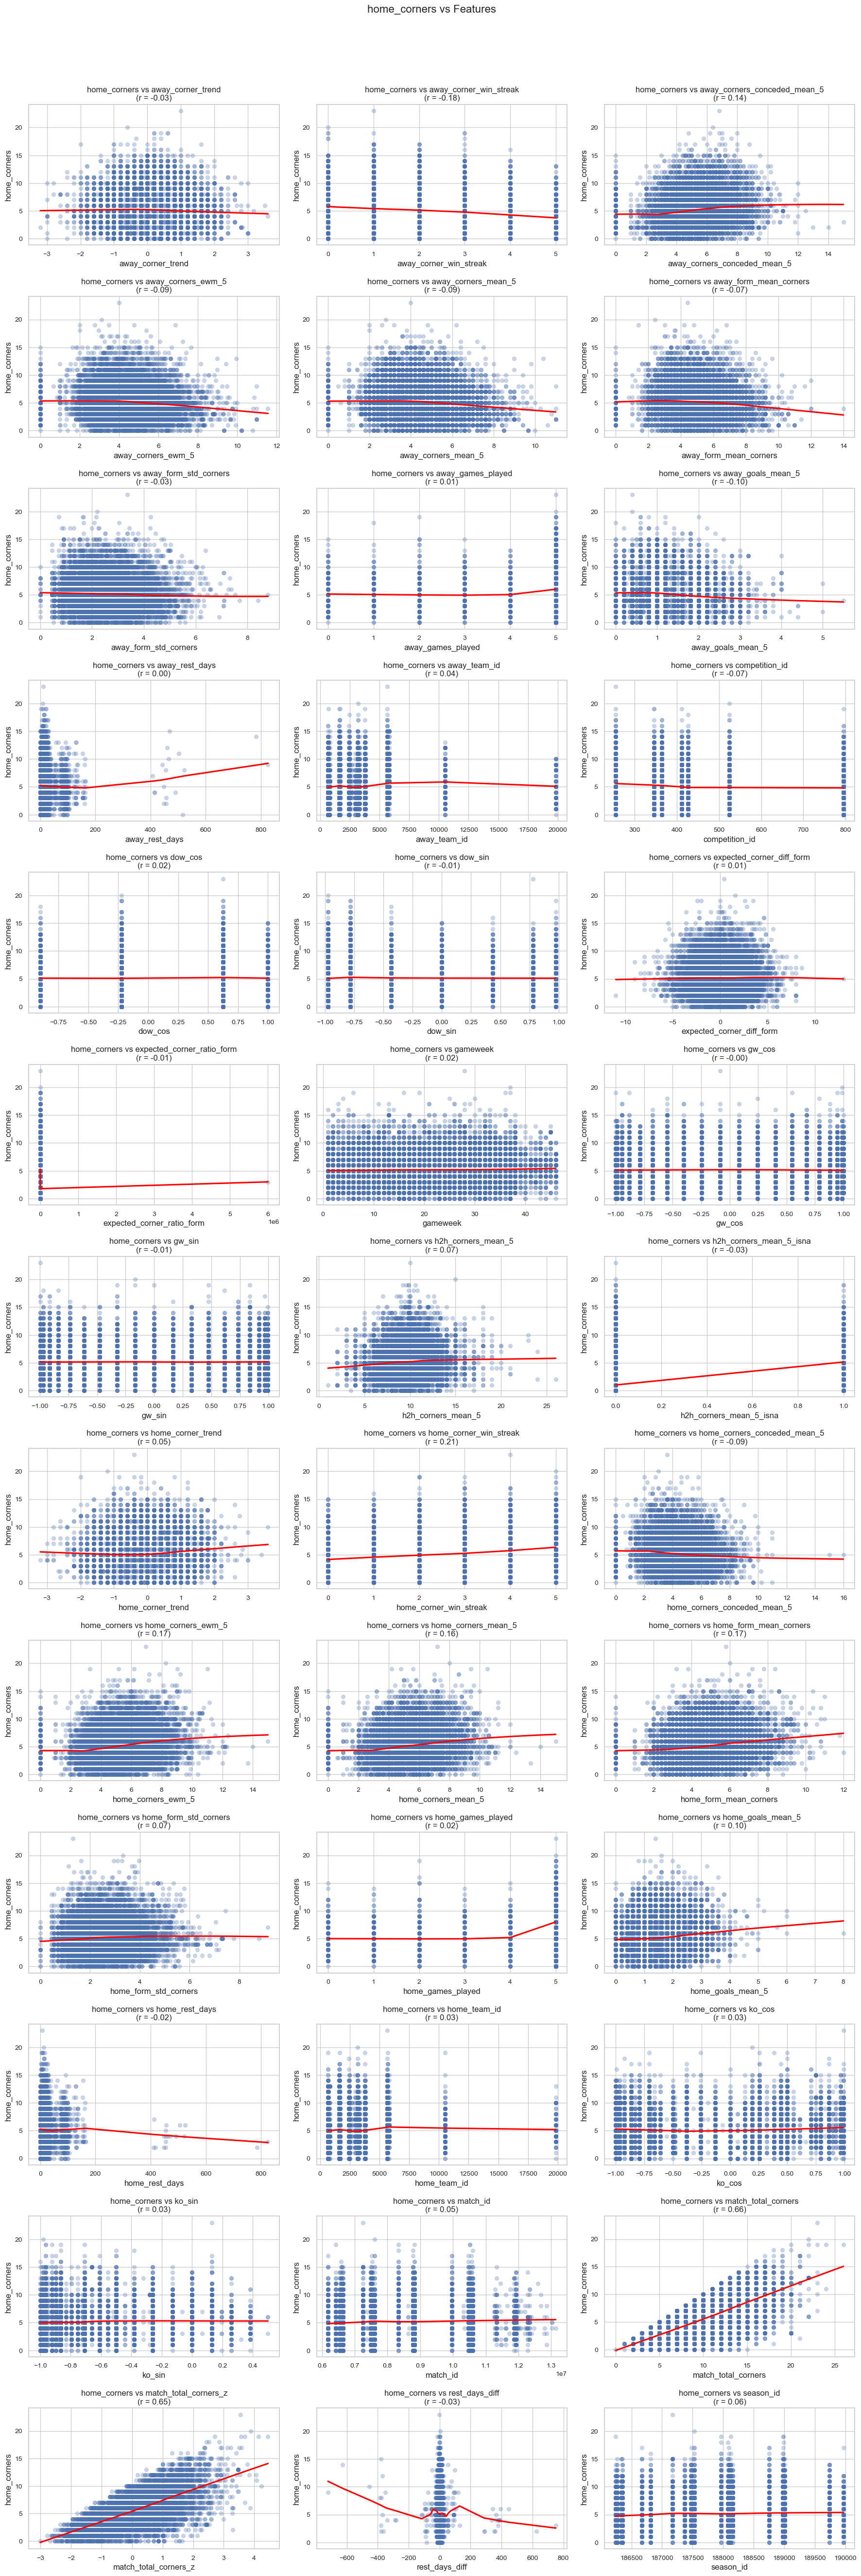

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


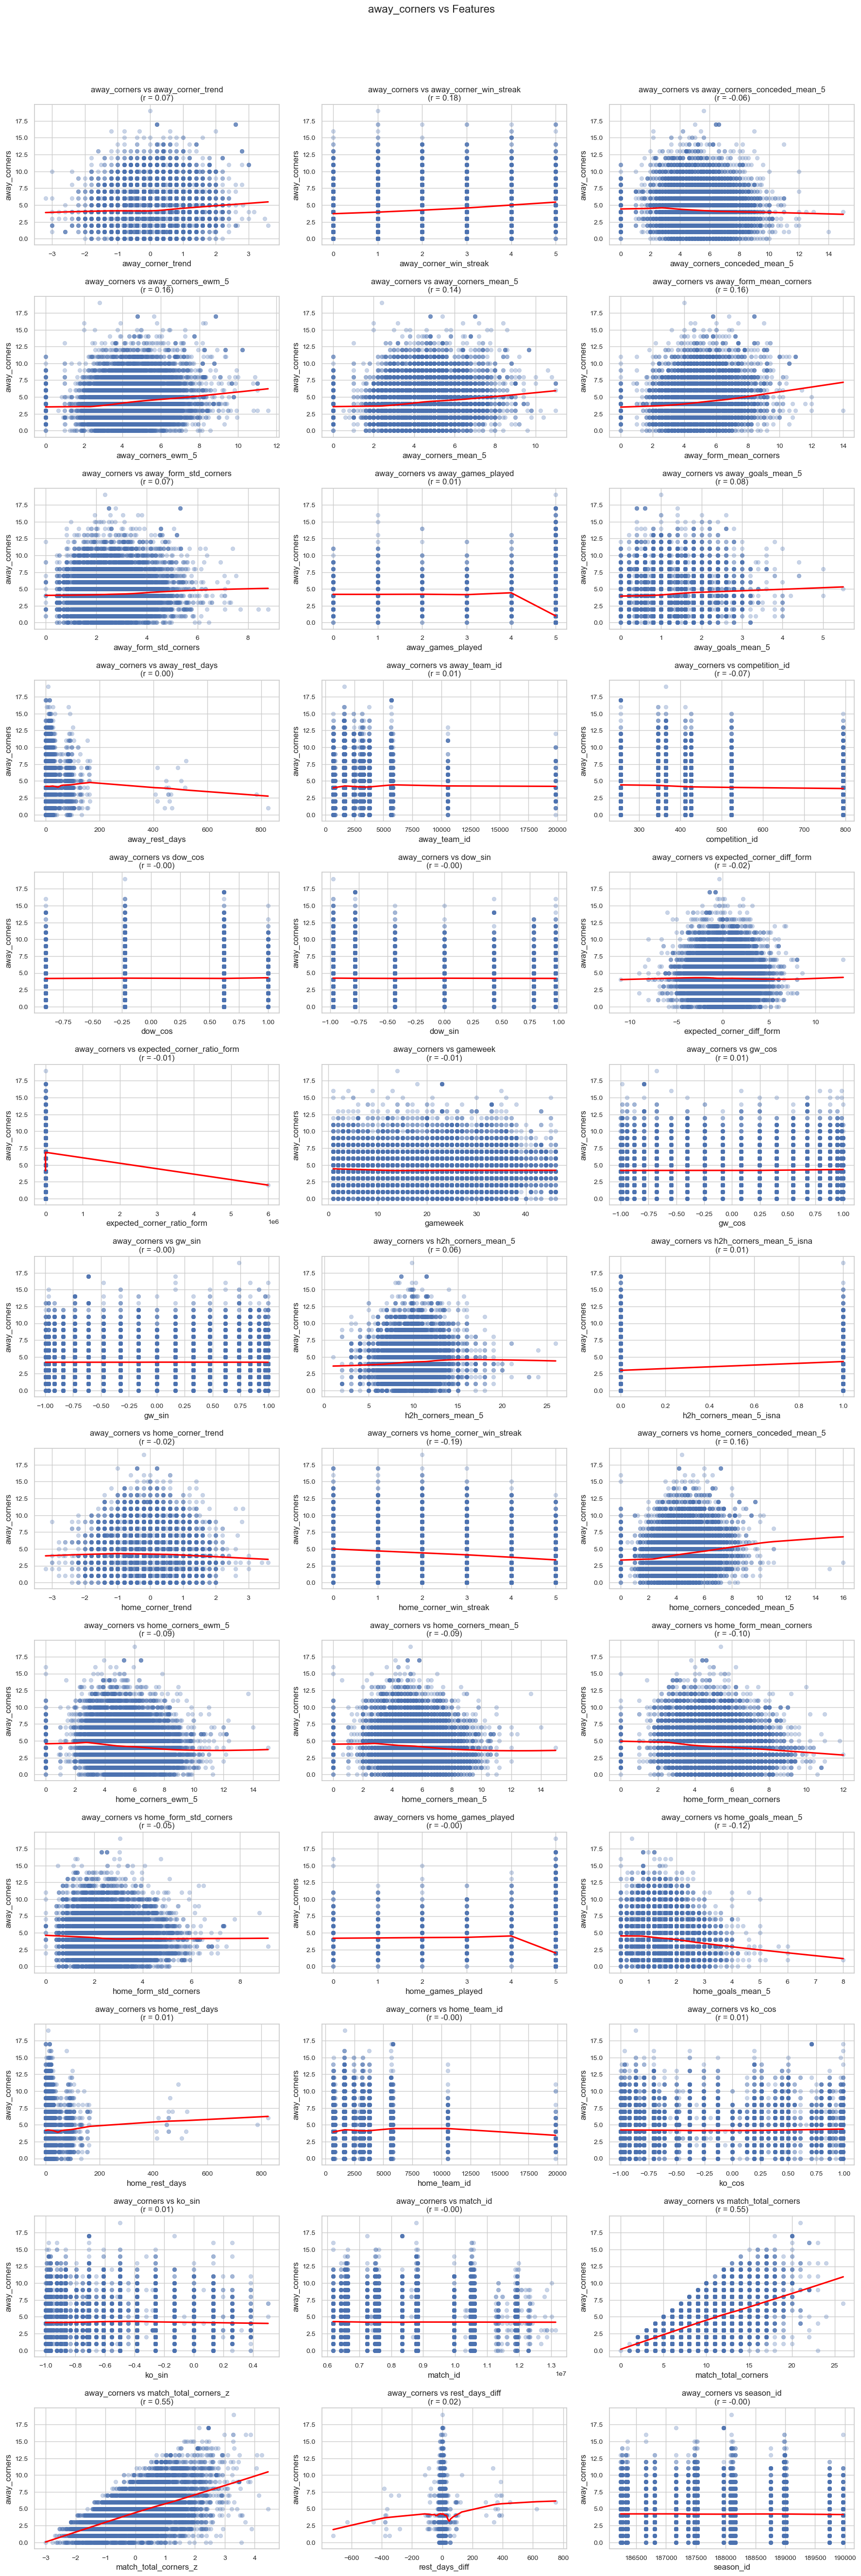

In [44]:
sns.set(style="whitegrid", font_scale=1.2, rc={"axes.facecolor": "white", "figure.figsize": (18, 6), "axes.titlesize": 14,
    "axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10})
targets = ["home_corners", "away_corners"]
feature_cols = dat.select_dtypes(include="number").columns.difference(targets)
plots_per_row = 3
alpha = 0.3
for target in targets:
    num_features = len(feature_cols)
    num_rows = int(np.ceil(num_features / plots_per_row))
    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(6 * plots_per_row, 4 * num_rows))
    axes = axes.flatten()
    for i, feature in enumerate(feature_cols):
        ax = axes[i]
        sns.scatterplot(data=dat, x=feature, y=target, alpha=alpha, ax=ax, edgecolor=None)
        sns.regplot(data=dat, x=feature, y=target, scatter=False, ax=ax, color="red", lowess=True)
        if dat[feature].notna().sum() > 0:
            corr = dat[[feature, target]].corr().iloc[0, 1]
            ax.set_title(f"{target} vs {feature}\n(r = {corr:.2f})", fontsize=12)
        else:
            ax.set_title(f"{target} vs {feature}\n(r = N/A)", fontsize=12)
        ax.set_xlabel(feature)
        ax.set_ylabel(target)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(f"{target} vs Features", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

Most engineered features show weak or noisy relationships with corner counts, though some—such as rest-day differences, league z-scores, and recent corner trends—display modest signal. The visual exploration confirms no dominant linear predictors, supporting the need for flexible, possibly nonlinear modeling approaches.

 **2.) Time Series Analysis**


With the dataset chronologically ordered, data leakage addressed, and relevant features engineered, we proceed to a time series diagnostic analysis. This includes stationarity testing, autocorrelation structure assessment, and preliminary checks for serial correlation, heteroscedasticity, and multicollinearity. These diagnostics guide the appropriate modeling approach and inform whether transformations or lagged predictors are needed.

In [48]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.formula.api import glm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from numpy.linalg import svd
from statsmodels.tsa.seasonal import STL
from scipy.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

Stationarity Test:

1.) Augmented Dickey-Fuller (ADF) tests for a unit root, where the null hypothesis implies non-stationarity.

2.) Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests for trend or level stationarity, where the null implies stationarity.

In [51]:
def run_stationarity_tests(series, name=""):
    print(f"--- {name} ---")
    adf_result = adfuller(series.dropna())
    print("ADF Test:")
    print(f"  Test Statistic = {adf_result[0]:.4f}")
    print(f"  p-value = {adf_result[1]:.4f}")
    for key, value in adf_result[4].items():
        print(f"  Critical Value ({key}) = {value:.4f}")
    print("  => Reject H₀ (non-stationary)?" , "Yes" if adf_result[1] < 0.05 else "No")
    print()
    kpss_result = kpss(series.dropna(), regression='c', nlags="auto")
    print("KPSS Test:")
    print(f"  Test Statistic = {kpss_result[0]:.4f}")
    print(f"  p-value = {kpss_result[1]:.4f}")
    for key, value in kpss_result[3].items():
        print(f"  Critical Value ({key}) = {value:.4f}")
    print("  => Reject H₀ (stationary)?", "Yes" if kpss_result[1] < 0.05 else "No")
    print("-" * 40)
run_stationarity_tests(dat["home_corners"], name="Home Corners")
run_stationarity_tests(dat["away_corners"], name="Away Corners")

--- Home Corners ---
ADF Test:
  Test Statistic = -36.2147
  p-value = 0.0000
  Critical Value (1%) = -3.4308
  Critical Value (5%) = -2.8618
  Critical Value (10%) = -2.5669
  => Reject H₀ (non-stationary)? Yes

KPSS Test:
  Test Statistic = 2.1485
  p-value = 0.0100
  Critical Value (10%) = 0.3470
  Critical Value (5%) = 0.4630
  Critical Value (2.5%) = 0.5740
  Critical Value (1%) = 0.7390
  => Reject H₀ (stationary)? Yes
----------------------------------------
--- Away Corners ---
ADF Test:
  Test Statistic = -27.7912
  p-value = 0.0000
  Critical Value (1%) = -3.4308
  Critical Value (5%) = -2.8618
  Critical Value (10%) = -2.5669
  => Reject H₀ (non-stationary)? Yes

KPSS Test:
  Test Statistic = 0.0998
  p-value = 0.1000
  Critical Value (10%) = 0.3470
  Critical Value (5%) = 0.4630
  Critical Value (2.5%) = 0.5740
  Critical Value (1%) = 0.7390
  => Reject H₀ (stationary)? No
----------------------------------------


In [52]:
kpss_result_trend = kpss(dat["home_corners"].dropna(), regression='ct', nlags="auto")
print(f"KPSS w/ trend: Test Statistic = {kpss_result_trend[0]:.4f}, p = {kpss_result_trend[1]:.4f}")

KPSS w/ trend: Test Statistic = 0.1319, p = 0.0761


For both series, the ADF test returned very low p-values, indicating strong evidence against the presence of a unit root, i.e., suggesting stationarity. The KPSS test for away_corners confirmed this result, showing a high p-value, which supports the null hypothesis that the series is stationary around a constant mean. This agreement between tests validates away_corners as a stationary series and appropriate for modeling without additional transformations.

For home_corners, however, the KPSS test initially indicated non-stationarity when assuming only a constant mean (p = 0.01), creating a contradiction with the ADF result, indicating stationarity around a linear or polynomial trend. 

To resolve this, the KPSS test was repeated with a trend component, yielding a test statistic well within the critical bounds and a p-value of 0.076. This suggests that home_corners is not strictly stationary around a constant, but is trend-stationary. Its statistical properties are stable once the deterministic trend is accounted for. As such, home_corners can be used for time series modeling in its current form, though models sensitive to trends may benefit from explicit detrending.

To understand the temporal dependence structure of the features, we examine their 1.) autocorrelation (ACF) and 2.) partial autocorrelation (PACF) functions. 

These plots reveal whether a variable exhibits short-term persistence, seasonality, or long memory, and help inform the appropriate number of lags to include in AR, MA, or lagged regression models.

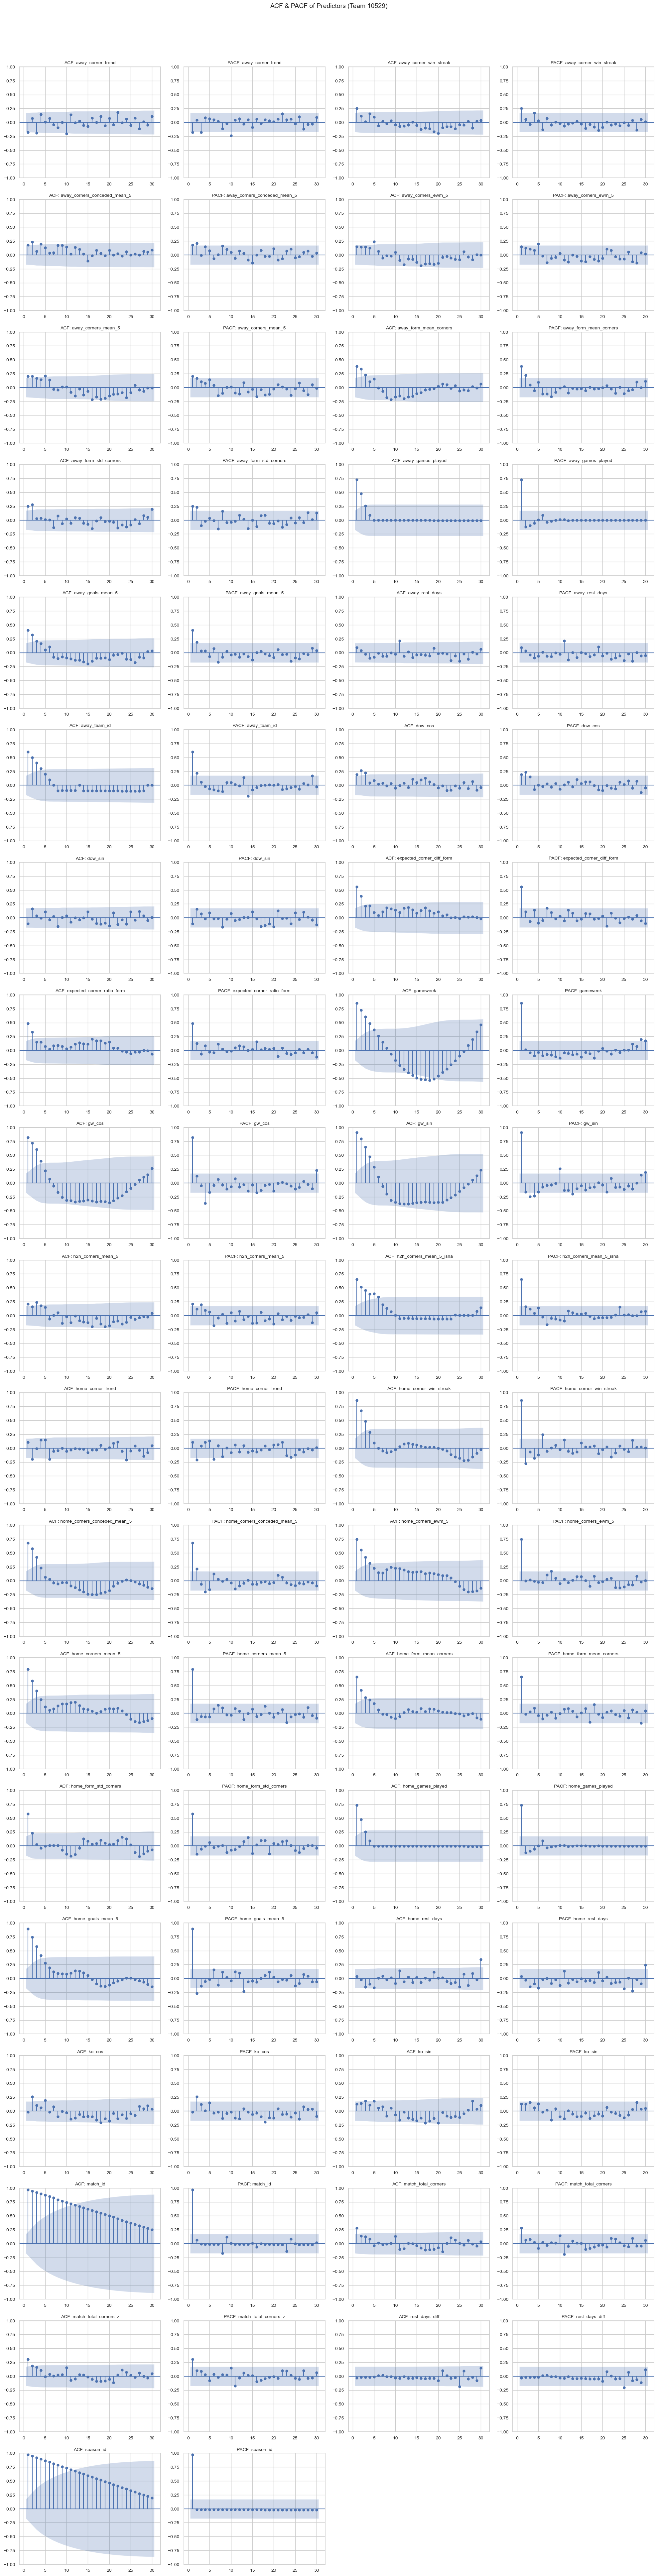

In [56]:
lags = 30
plots_per_row = 4  
features = dat.select_dtypes(include="number").columns.difference(["home_corners", "away_corners"])
team_id = dat["home_team_id"].mode()[0]
valid_features = []
for feature in features:
    series = dat.loc[dat["home_team_id"] == team_id, feature].dropna()
    if series.nunique() > 1:
        valid_features.append(feature)
n_features = len(valid_features)
n_rows = int(np.ceil(n_features / 2))
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(5 * plots_per_row, 4 * n_rows))
axes = axes.flatten()
for i, feature in enumerate(valid_features):
    series = dat.loc[dat["home_team_id"] == team_id, feature].dropna()
    plot_acf(series, ax=axes[2 * i], lags=lags, zero=False, alpha=0.05)
    axes[2 * i].set_title(f"ACF: {feature}", fontsize=10)
    axes[2 * i].grid(True)
    plot_pacf(series, ax=axes[2 * i + 1], lags=lags, zero=False, alpha=0.05, method="ywm")
    axes[2 * i + 1].set_title(f"PACF: {feature}", fontsize=10)
    axes[2 * i + 1].grid(True)
for j in range(2 * n_features, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.suptitle(f"ACF & PACF of Predictors (Team {team_id})", fontsize=14, y=1.02)
plt.show()

The ACF/PACF plots were used to identify which features exhibit significant autocorrelation that would justify the creation of lagged variables. Variables such as away_games_played, gameweek, and home_games_played showed strong autocorrelation at lower lags, with some also exhibiting signs of longer memory or seasonal structure. While detailed lag-feature engineering is deferred to future iterations, these diagnostics highlight promising candidates for inclusion as lagged predictors in time series models.

To evaluate whether temporal dependence exists in the target series and in regression residuals, we apply two serial correlation tests:

1.) Ljung-Box Test checks for autocorrelation at multiple lags in the raw time series (non-parametrically). 

2.) Breusch-Godfrey Test evaluates serial correlation in residuals of a regression model, allowing for lagged structure in the errors. 

These tests help determine whether temporal dynamics remain unmodeled and guide the need for autoregressive or lag-augmented methods.

In [60]:
def ljung_box_test(series, lags=[10, 20, 30], name=""):
    print(f"--- Ljung-Box Test: {name} ---")
    result = acorr_ljungbox(series.dropna(), lags=lags, return_df=True)
    for lag in lags:
        pval = result.loc[lag, "lb_pvalue"]
        print(f"  Lag {lag}: p-value = {pval:.4f} => {'Reject H₀ (autocorrelation)' if pval < 0.05 else 'No autocorrelation'}")
    print()
ljung_box_test(dat["home_corners"], name="Home Corners")
ljung_box_test(dat["away_corners"], name="Away Corners")

--- Ljung-Box Test: Home Corners ---
  Lag 10: p-value = 0.0000 => Reject H₀ (autocorrelation)
  Lag 20: p-value = 0.0000 => Reject H₀ (autocorrelation)
  Lag 30: p-value = 0.0000 => Reject H₀ (autocorrelation)

--- Ljung-Box Test: Away Corners ---
  Lag 10: p-value = 0.0000 => Reject H₀ (autocorrelation)
  Lag 20: p-value = 0.0000 => Reject H₀ (autocorrelation)
  Lag 30: p-value = 0.0000 => Reject H₀ (autocorrelation)



In [61]:
X = sm.add_constant(dat[["home_form_mean_corners"]].fillna(0))  # example predictor
y = dat["home_corners"]
model = sm.OLS(y, X).fit()
def breusch_godfrey_test(model, nlags=5):
    print("--- Breusch-Godfrey Test ---")
    bg_test = acorr_breusch_godfrey(model, nlags=nlags)
    print(f"  LM stat = {bg_test[0]:.4f}")
    print(f"  p-value = {bg_test[1]:.4f} =>", "Reject H₀ (serial correlation)" if bg_test[1] < 0.05 else "No serial correlation")
    print()
breusch_godfrey_test(model, nlags=10)

--- Breusch-Godfrey Test ---
  LM stat = 506.1162
  p-value = 0.0000 => Reject H₀ (serial correlation)



The Ljung-Box test was applied to home_corners and away_corners to detect autocorrelation at lags 10, 20, and 30. In all cases, the null hypothesis of no autocorrelation was strongly rejected (p < 0.0001), confirming the presence of temporal dependence in both series. These results indicate that the corner count series are not white noise and require time-aware modeling techniques. 

To assess whether simple regression models capture this structure, a Breusch-Godfrey test was run on residuals from an OLS model predicting home_corners using home_form_mean_corners. The test returned a highly significant LM statistic (506.12, p < 0.0001), indicating serial correlation remains in the residuals. This underscores the need for models that incorporate autoregressive effects or lagged features, such as ARIMA-type models or time-aware regression.

To check whether the variance of the regression residuals changes with the fitted values (a violation of OLS assumptions), we apply two complementary tests: 

1.) Breusch–Pagan – detects a monotonic relationship between the squared residuals and the regressors. 

2.) White – a more general test that also captures nonlinear forms of heteroscedasticity.

In [65]:
X = sm.add_constant(dat[["home_form_mean_corners", "home_rest_days", "ko_sin", "ko_cos"]].fillna(0))
y = dat["home_corners"]
model = sm.OLS(y, X).fit()
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ["LM stat", "LM p-value", "F-stat", "F p-value"]
print("--- Breusch-Pagan Test ---")
for label, value in zip(labels, bp_test):
    print(f"  {label}: {value:.4f}")
print("  => Reject H₀ (homoscedasticity)?" , "Yes" if bp_test[1] < 0.05 else "No")

--- Breusch-Pagan Test ---
  LM stat: 43.7932
  LM p-value: 0.0000
  F-stat: 10.9807
  F p-value: 0.0000
  => Reject H₀ (homoscedasticity)? Yes


In [66]:
white_test = het_white(model.resid, model.model.exog)
labels = ["LM stat", "LM p-value", "F-stat", "F p-value"]
print("--- White Test ---")
for label, value in zip(labels, white_test):
    print(f"  {label}: {value:.4f}")
print("  => Reject H₀ (homoscedasticity)?" , "Yes" if white_test[1] < 0.05 else "No")

--- White Test ---
  LM stat: 52.4350
  LM p-value: 0.0000
  F-stat: 4.0453
  F p-value: 0.0000
  => Reject H₀ (homoscedasticity)? Yes


The analysis reveals that while standard OLS with robust (HC3) errors identifies meaningful predictors such as recent corner form, rest days, and kickoff time patterns, its explanatory power is limited due to the inherent noise in football data. Weighted Least Squares offered no improvement, likely due to oversimplified variance assumptions. The Poisson GLM, better suited for count data, provided a modest but consistent gain in model fit and interpretability, supporting its use as the preferred approach. Having already implemented all three models, the next step is to evaluate their predictive performance on holdout data using appropriate metrics (e.g., log-likelihood, MAE) and consider exploring interaction terms, non-linear effects, or a Negative Binomial model to address potential overdispersion.

In [69]:
robust_model = model.get_robustcov_results(cov_type="HC3")  # or "HC1", "HC0"
print(robust_model.summary())
weights = 1 / np.square(model.fittedvalues)
wls_model = sm.WLS(y, X, weights=weights).fit()
print(wls_model.summary())
y_log = np.log1p(dat["home_corners"])  # +1 to avoid log(0)
poisson_model = glm("home_corners ~ home_form_mean_corners + home_rest_days", data=dat, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

                            OLS Regression Results                            
Dep. Variable:           home_corners   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     96.49
Date:                Sun, 15 Jun 2025   Prob (F-statistic):           4.73e-81
Time:                        22:44:38   Log-Likelihood:                -32485.
No. Observations:               13135   AIC:                         6.498e+04
Df Residuals:                   13130   BIC:                         6.502e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

1.) OLS (with robust HC3 standard errors) explains only about 3% of the variance in home corner counts, which is low but typical for noisy sports data. All included predictors are statistically significant, with home_form_mean_corners showing a strong positive effect and home_rest_days showing a slight negative impact. The sinusoidal time-of-day features (ko_sin, ko_cos) are also meaningful, suggesting temporal patterns in corner generation. HC3 robust standard errors appropriately correct for the heteroscedasticity detected earlier. 

2.) Weighted Least Squares (WLS) was used with inverse-squared fitted values as weights to model heteroscedasticity, but it underperformed slightly with an R² of 2.7%. Coefficients and significance largely mirror the OLS model, indicating no structural gain. The assumed variance structure may be too simplistic for this context, and without a stronger reason to justify the weights, WLS is not offering practical improvement over HC3-robust OLS.

3.) The Poisson Generalized Linear Model (GLM) provides a more appropriate statistical framework for modeling corner counts, which are non-negative integers. It slightly improves model fit, with a higher log-likelihood and pseudo R² (~4.3%). Predictors remain significant, and the model interprets coefficients multiplicatively — for example, each additional unit of home_form_mean_corners increases expected corners by ~6%. This makes Poisson GLM the preferred model in terms of both theoretical alignment and empirical performance.

Correlation and multicollinearity checks.

We quantify linear and monotonic associations between predictors and targets using the 1.) Pearson and 2.) Spearman coefficients, respectively. These highlight candidates for feature engineering and potential non‑linear effects.

To gauge redundancy among predictors we compute the 3.) Variance Inflation Factor (VIF); variables with VIF > 10 indicate severe multicollinearity and may destabilise regression coefficients.

Dataset: 13135 complete observations
Features analyzed: 33 predictors + 2 targets
Total correlations computed: 595

--- HOME_CORNERS CORRELATIONS ---

Top 15 Strongest Correlations:
------------------------------------------------------------------------------------------
Predictor                 N      Pearson r    P-val    Spearman r   P-val   
------------------------------------------------------------------------------------------
match_total_corners       13135  0.6621  ***  0.0000   0.6376  ***  0.0000  
match_total_corners_z     13135  0.6487  ***  0.0000   0.6245  ***  0.0000  
home_corner_win_streak    13135  0.2137  ***  0.0000   0.2150  ***  0.0000  
away_corner_win_streak    13135  -0.1786 ***  0.0000   -0.1734 ***  0.0000  
home_corners_ewm_5        13135  0.1738  ***  0.0000   0.1821  ***  0.0000  
home_form_mean_corners    13135  0.1664  ***  0.0000   0.1672  ***  0.0000  
home_corners_mean_5       13135  0.1586  ***  0.0000   0.1611  ***  0.0000  
away_corners_concede

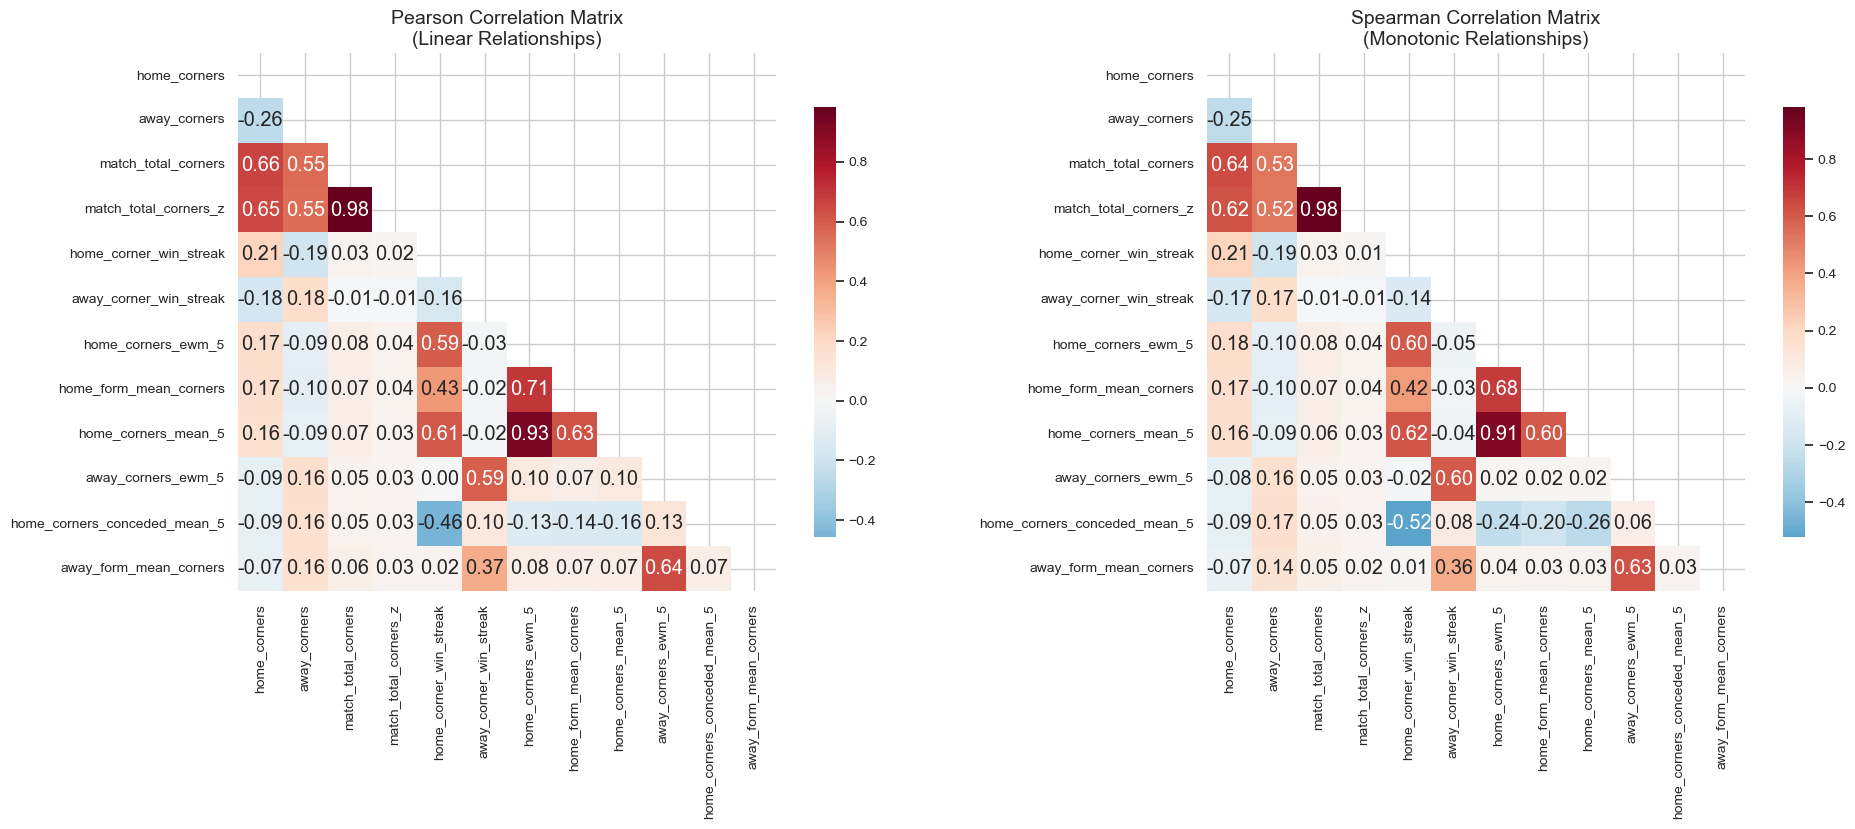

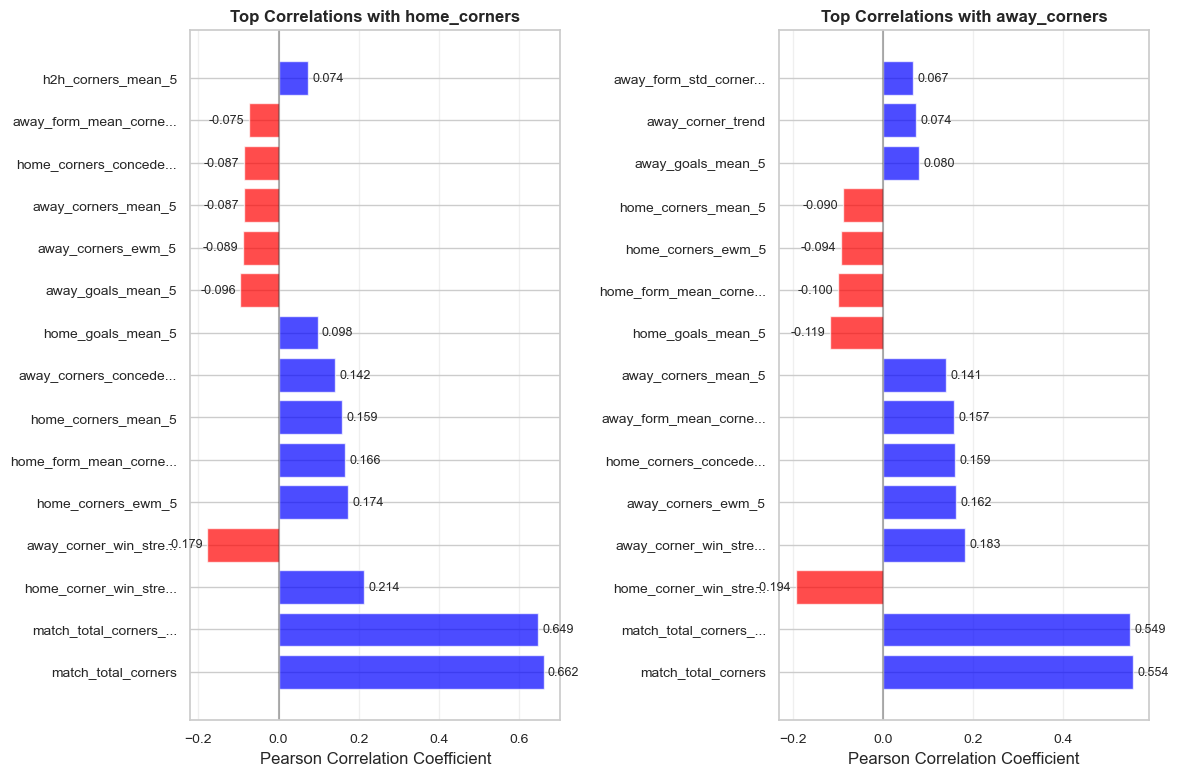

Variance Inflation Factor (VIF) Analysis:
Variable                       VIF        Interpretation
home_corners_mean_5            336.07     High multicollinearity
away_corners_conceded_mean_5   256.13     High multicollinearity
home_games_played              130.71     High multicollinearity
away_games_played              127.38     High multicollinearity
match_total_corners            117.64     High multicollinearity
home_corners_ewm_5             101.83     High multicollinearity
away_corners_ewm_5             80.49      High multicollinearity
away_corners_mean_5            74.11      High multicollinearity
expected_corner_diff_form      36.85      High multicollinearity
home_form_mean_corners         28.26      High multicollinearity
away_form_mean_corners         27.87      High multicollinearity
h2h_corners_mean_5             21.93      High multicollinearity
home_rest_days                 21.47      High multicollinearity
away_rest_days                 19.94      High multicoll

In [74]:
def comprehensive_correlation_analysis(dat):
    numeric_cols = dat.select_dtypes(include=[np.number]).columns.tolist()
    id_cols = ['match_id', 'home_team_id', 'away_team_id', 'competition_id', 'season_id', 'gameweek']
    feature_cols = [col for col in numeric_cols if col not in id_cols]
    target_cols = ['home_corners', 'away_corners']
    predictor_cols = [col for col in feature_cols if col not in target_cols]
    clean_data = dat[feature_cols].dropna()
    print(f"Dataset: {len(clean_data)} complete observations")
    print(f"Features analyzed: {len(predictor_cols)} predictors + {len(target_cols)} targets")
    print(f"Total correlations computed: {len(feature_cols) * (len(feature_cols) - 1) // 2}")
    return analyze_correlations(clean_data, target_cols, predictor_cols)

def analyze_correlations(data, target_cols, predictor_cols):
    results = {}    
    target_correlations = analyze_target_correlations(data, target_cols, predictor_cols)
    results['target_correlations'] = target_correlations    
    predictor_correlations = analyze_predictor_correlations(data, predictor_cols)
    results['predictor_correlations'] = predictor_correlations    
    plot_correlation_heatmaps(data, target_cols, predictor_cols)    
    multicollinearity_analysis(data, predictor_cols)
    return results

def analyze_target_correlations(data, target_cols, predictor_cols):
    target_results = {}
    for target in target_cols:
        print(f"\n--- {target.upper()} CORRELATIONS ---")
        correlations = []
        for predictor in predictor_cols:
            if predictor in data.columns and target in data.columns:
                valid_data = data[[target, predictor]].dropna()
                if len(valid_data) > 10:  # Minimum sample size
                    pearson_r, pearson_p = pearsonr(valid_data[target], valid_data[predictor])
                    spearman_r, spearman_p = spearmanr(valid_data[target], valid_data[predictor])
                    correlations.append({
                        'predictor': predictor,
                        'n_obs': len(valid_data),
                        'pearson_r': pearson_r,
                        'pearson_p': pearson_p,
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p,
                        'pearson_sig': '***' if pearson_p < 0.001 else '**' if pearson_p < 0.01 else '*' if pearson_p < 0.05 else '',
                        'spearman_sig': '***' if spearman_p < 0.001 else '**' if spearman_p < 0.01 else '*' if spearman_p < 0.05 else ''
                    })
        corr_df = pd.DataFrame(correlations)
        corr_df['abs_pearson'] = abs(corr_df['pearson_r'])
        corr_df = corr_df.sort_values('abs_pearson', ascending=False)
        print("\nTop 15 Strongest Correlations:")
        print("-" * 90)
        print(f"{'Predictor':<25} {'N':<6} {'Pearson r':<12} {'P-val':<8} {'Spearman r':<12} {'P-val':<8}")
        print("-" * 90)
        for _, row in corr_df.head(15).iterrows():
            print(f"{row['predictor']:<25} {row['n_obs']:<6} "
                  f"{row['pearson_r']:<8.4f}{row['pearson_sig']:<4} {row['pearson_p']:<8.4f} "
                  f"{row['spearman_r']:<8.4f}{row['spearman_sig']:<4} {row['spearman_p']:<8.4f}")
        target_results[target] = corr_df
        print(f"\nSummary for {target}:")
        print(f"  Strong correlations (|r| > 0.5): {sum(corr_df['abs_pearson'] > 0.5)}")
        print(f"  Moderate correlations (0.3 < |r| ≤ 0.5): {sum((corr_df['abs_pearson'] > 0.3) & (corr_df['abs_pearson'] <= 0.5))}")
        print(f"  Significant correlations (p < 0.05): {sum(corr_df['pearson_p'] < 0.05)}")
        corr_df['nonlinear_indicator'] = abs(corr_df['spearman_r']) - abs(corr_df['pearson_r'])
        potential_nonlinear = corr_df[corr_df['nonlinear_indicator'] > 0.1]
        if len(potential_nonlinear) > 0:
            print(f"  Potential non-linear relationships: {len(potential_nonlinear)}")
            print("    " + ", ".join(potential_nonlinear['predictor'].head(3).tolist()))
    return target_results

def analyze_predictor_correlations(data, predictor_cols):
    predictor_data = data[predictor_cols]
    pearson_matrix = predictor_data.corr(method='pearson')
    spearman_matrix = predictor_data.corr(method='spearman')
    high_corr_pairs = []
    n_predictors = len(predictor_cols)
    for i in range(n_predictors):
        for j in range(i+1, n_predictors):
            var1, var2 = predictor_cols[i], predictor_cols[j]
            
            if var1 in pearson_matrix.index and var2 in pearson_matrix.columns:
                pearson_r = pearson_matrix.loc[var1, var2]
                spearman_r = spearman_matrix.loc[var1, var2]
                
                if not pd.isna(pearson_r) and abs(pearson_r) > 0.3:  # Threshold for reporting
                    high_corr_pairs.append({
                        'var1': var1,
                        'var2': var2,
                        'pearson_r': pearson_r,
                        'spearman_r': spearman_r,
                        'abs_pearson': abs(pearson_r)
                    })
    high_corr_df = pd.DataFrame(high_corr_pairs)
    if len(high_corr_df) > 0:
        high_corr_df = high_corr_df.sort_values('abs_pearson', ascending=False)
        print("\nHigh Inter-Predictor Correlations (|r| > 0.3):")
        print("-" * 70)
        print(f"{'Variable 1':<25} {'Variable 2':<25} {'Pearson':<10} {'Spearman':<10}")
        print("-" * 70)
        for _, row in high_corr_df.head(20).iterrows():
            print(f"{row['var1']:<25} {row['var2']:<25} {row['pearson_r']:<10.4f} {row['spearman_r']:<10.4f}")
        very_high = high_corr_df[high_corr_df['abs_pearson'] > 0.8]
        high = high_corr_df[(high_corr_df['abs_pearson'] > 0.6) & (high_corr_df['abs_pearson'] <= 0.8)]
        print(f"\nMulticollinearity Assessment:")
        print(f"  Very high correlations (|r| > 0.8): {len(very_high)} pairs")
        print(f"  High correlations (0.6 < |r| ≤ 0.8): {len(high)} pairs")
        if len(very_high) > 0:
            print(f"Consider removing redundant variables:")
            for _, row in very_high.head(5).iterrows():
                print(f"    • {row['var1']} ↔ {row['var2']} (r = {row['pearson_r']:.3f})")
    else:
        print("No high inter-predictor correlations found (|r| > 0.3)")
    return high_corr_df if len(high_corr_df) > 0 else None

def plot_correlation_heatmaps(data, target_cols, predictor_cols):
    important_features = target_cols.copy()
    target_data = data[target_cols + predictor_cols]
    for target in target_cols:
        target_corrs = target_data.corr()[target].abs().sort_values(ascending=False)
        top_predictors = target_corrs.drop(target).head(8).index.tolist()
        important_features.extend(top_predictors)
    important_features = list(dict.fromkeys(important_features))[:25]  # Max 25 features
    plot_data = data[important_features]
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    pearson_corr = plot_data.corr(method='pearson')
    mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
    sns.heatmap(pearson_corr, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=axes[0])
    axes[0].set_title('Pearson Correlation Matrix\n(Linear Relationships)', fontsize=14)
    spearman_corr = plot_data.corr(method='spearman')
    sns.heatmap(spearman_corr, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=axes[1])
    axes[1].set_title('Spearman Correlation Matrix\n(Monotonic Relationships)', fontsize=14)
    plt.tight_layout()
    plt.show()
    plot_target_correlation_bars(data, target_cols, predictor_cols)

def plot_target_correlation_bars(data, target_cols, predictor_cols):
    fig, axes = plt.subplots(1, len(target_cols), figsize=(6 * len(target_cols), 8))
    if len(target_cols) == 1:
        axes = [axes]
    for idx, target in enumerate(target_cols):
        correlations = []
        for predictor in predictor_cols:
            valid_data = data[[target, predictor]].dropna()
            if len(valid_data) > 10:
                pearson_r = valid_data[target].corr(valid_data[predictor], method='pearson')
                if not pd.isna(pearson_r):
                    correlations.append({'feature': predictor, 'correlation': pearson_r})
        corr_df = pd.DataFrame(correlations)
        corr_df['abs_corr'] = abs(corr_df['correlation'])
        top_corrs = corr_df.nlargest(15, 'abs_corr')
        colors = ['red' if x < 0 else 'blue' for x in top_corrs['correlation']]
        bars = axes[idx].barh(range(len(top_corrs)), top_corrs['correlation'], color=colors, alpha=0.7)
        axes[idx].set_yticks(range(len(top_corrs)))
        axes[idx].set_yticklabels([feat[:20] + '...' if len(feat) > 20 else feat 
                                  for feat in top_corrs['feature']], fontsize=10)
        axes[idx].set_xlabel('Pearson Correlation Coefficient')
        axes[idx].set_title(f'Top Correlations with {target}', fontsize=12, fontweight='bold')
        axes[idx].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        axes[idx].grid(axis='x', alpha=0.3)
        for i, (bar, corr) in enumerate(zip(bars, top_corrs['correlation'])):
            axes[idx].text(corr + (0.01 if corr > 0 else -0.01), i, f'{corr:.3f}', 
                          va='center', ha='left' if corr > 0 else 'right', fontsize=9)
    plt.tight_layout()
    plt.show()

def multicollinearity_analysis(data, predictor_cols):
    try:
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        vif_data = data[predictor_cols].dropna()
        vif_results = []
        for i, col in enumerate(vif_data.columns):
            try:
                vif_value = variance_inflation_factor(vif_data.values, i)
                vif_results.append({'Variable': col, 'VIF': vif_value})
            except:
                vif_results.append({'Variable': col, 'VIF': np.nan})
        vif_df = pd.DataFrame(vif_results)
        vif_df = vif_df.sort_values('VIF', ascending=False)
        print("Variance Inflation Factor (VIF) Analysis:")
        print(f"{'Variable':<30} {'VIF':<10} {'Interpretation'}")
        for _, row in vif_df.head(15).iterrows():
            vif_val = row['VIF']
            if pd.isna(vif_val):
                interpretation = "Error in calculation"
            elif vif_val > 10:
                interpretation = "High multicollinearity"
            elif vif_val > 5:
                interpretation = "Moderate multicollinearity"
            else:
                interpretation = "Low multicollinearity"
            print(f"{row['Variable']:<30} {vif_val:<10.2f} {interpretation}")
        high_vif = vif_df[vif_df['VIF'] > 10]
        moderate_vif = vif_df[(vif_df['VIF'] > 5) & (vif_df['VIF'] <= 10)]
        print(f"\nVIF Summary:")
        print(f"  High multicollinearity (VIF > 10): {len(high_vif)} variables")
        print(f"  Moderate multicollinearity (5 < VIF ≤ 10): {len(moderate_vif)} variables")
        if len(high_vif) > 0:
            print(f"  Consider removing: {', '.join(high_vif['Variable'].head(3).tolist())}")
    except ImportError:
        print("VIF analysis requires statsmodels. Skipping VIF calculation.")
    except Exception as e:
        print(f"VIF calculation failed: {e}")

def run_correlation_analysis(dat):
    results = comprehensive_correlation_analysis(dat)
    return results
results = run_correlation_analysis(dat)

Predictive Power - The correlation analysis reveals strong predictive relationships for both target variables. Home corners show the strongest correlation with match_total_corners (r=0.66), followed by home_corner_win_streak (r=0.21) and team form metrics. Away corners display similar patterns with match_total_corners (r=0.55) as the top predictor, though generally weaker correlations overall. The directional relationships align with football logic - home team streaks positively correlate with home corners while away team streaks show the opposite pattern, and form variables demonstrate expected associations with corner generation.

Feature Redundancy- The dataset suffers from severe multicollinearity issues with 18 variables showing VIF values exceeding 10, including extreme cases like home_corners_mean_5 (VIF=336). Three critical redundant pairs emerge: match_total_corners with its z-scored version (r=0.984), and both home and away corner means with their exponentially weighted counterparts (r>0.92). Additionally, games_played variables show problematic correlations (r=0.76), indicating substantial information overlap that will compromise model stability and interpretability.

Data Quality and Relationships
Most relationships appear genuinely linear as Pearson and Spearman correlations align closely, suggesting standard linear modeling approaches are appropriate. The analysis successfully identifies 26 significant correlations for home corners and 19 for away corners, with consistent patterns across both statistical measures. Rest day variables show some evidence of potential non-linear effects that warrant further investigation, while temporal features like day-of-week and kick-off time demonstrate expected cyclical relationships.


Strategic Recommendations
Immediate feature reduction is essential, requiring removal of 6 high-VIF variables including redundant z-scored and mean-based features while retaining their exponentially weighted alternatives. The cleaned feature set should prioritize match_total_corners despite its VIF concerns due to exceptional predictive power, supplemented by win streak variables, form metrics, and head-to-head history. Post-cleanup validation must confirm VIF reduction below 10 and verify that model performance improves rather than degrades, as fewer but more independent features typically yield better generalization than redundant high-dimensional datasets.

In [79]:
variables_to_remove = ['match_total_corners_z','home_corners_mean_5', 'away_corners_mean_5', 'away_corners_conceded_mean_5']
dat_new = dat.drop(columns=variables_to_remove)

In [80]:
dat_new

match_id  home_team_id  away_team_id  competition_id  season_id  \
0       6184853          5663          5651             255     186667   
1       6184852          5660          5644             255     186667   
2       6184851          5674          5669             255     186667   
3       6184845          5654          5653             255     186667   
4       6184848          5655          5685             255     186667   
...         ...           ...           ...             ...        ...   
13130  11933102          5659          5638             255     189744   
13131  11933103          5653          5651             255     189744   
13132  11933104          5654          5642             255     189744   
13133  11933105          5650          5640             255     189744   
13134  11933106          5663          5644             255     189744   

                date_time  gameweek  home_corners  away_corners  \
0     2020-08-08 22:00:00         1           4.0           4.0   
1     2020-08-08 22:30:00         1           2.0           6.0   
2     2020-08-09 12:00:00         1           2.0           4.0   
3     2020-08-09 19:00:00         1           9.0           2.0   
4     2020-08-09 19:00:00         1           4.0           2.0   
...                   ...       ...           ...           ...   
13130 2024-12-08 19:00:00        38           3.0           0.0   
13131 2024-12-08 19:00:00        38           5.0           4.0   
13132 2024-12-08 19:00:00        38           6.0           4.0   
13133 2024-12-08 19:00:00        38           8.0           1.0   
13134 2024-12-08 19:00:00        38           4.0           3.0   

       home_goals_mean_5  ...  home_corner_trend  away_form_mean_corners  \
0                    0.0  ...                0.0                     0.0   
1                    0.0  ...                0.0                     0.0   
2                    0.0  ...                0.0                     0.0   
3                    0.0  ...                0.0                     0.0   
4                    0.0  ...                0.0                     0.0   
...                  ...  ...                ...                     ...   
13130                1.0  ...               -1.2                     6.2   
13131                1.4  ...                0.4                     4.0   
13132                1.6  ...               -0.2                     6.4   
13133                1.2  ...               -0.6                     6.4   
13134                1.8  ...                0.0                     5.8   

       away_form_std_corners  away_corner_trend  home_corner_win_streak  \
0                   3.383999                0.0                     0.0   
1                   3.383999                0.0                     0.0   
2                   3.383999                0.0                     0.0   
3                   3.383999                0.0                     0.0   
4                   3.383999                0.0                     0.0   
...                      ...                ...                     ...   
13130               3.962323                1.8                     5.0   
13131               2.121320                0.0                     1.0   
13132               5.029911                0.6                     5.0   
13133               2.302173                0.0                     5.0   
13134               3.033150                0.6                     4.0   

       away_corner_win_streak  home_games_played  away_games_played  \
0                         0.0                0.0                0.0   
1                         0.0                0.0                0.0   
2                         0.0                0.0                0.0   
3                         0.0                0.0                0.0   
4                         0.0                0.0                0.0   
...                       ...                ...                ...   
13

Decomposition-

Seasonal and Trend Decomposition using LOESS (STL Decomposition)

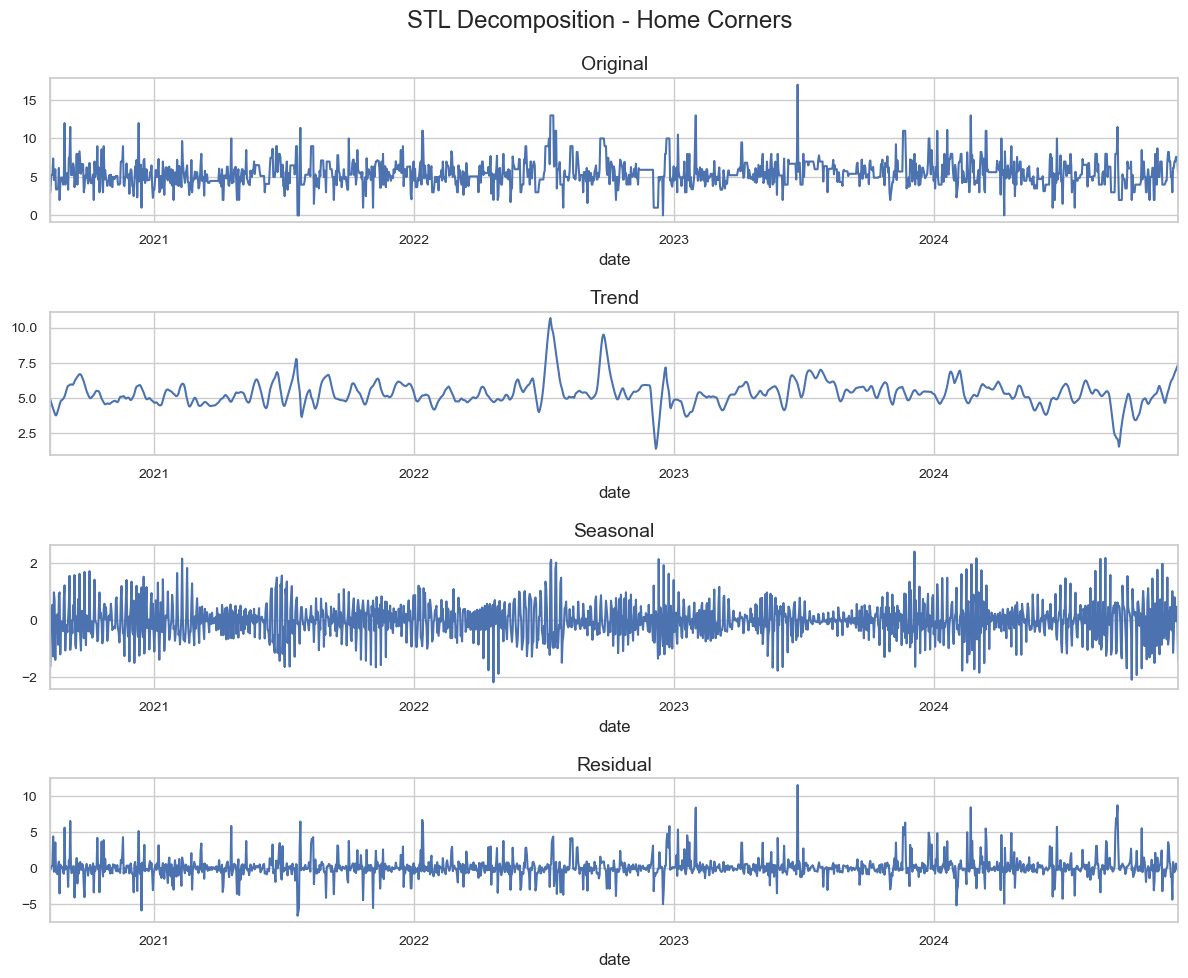

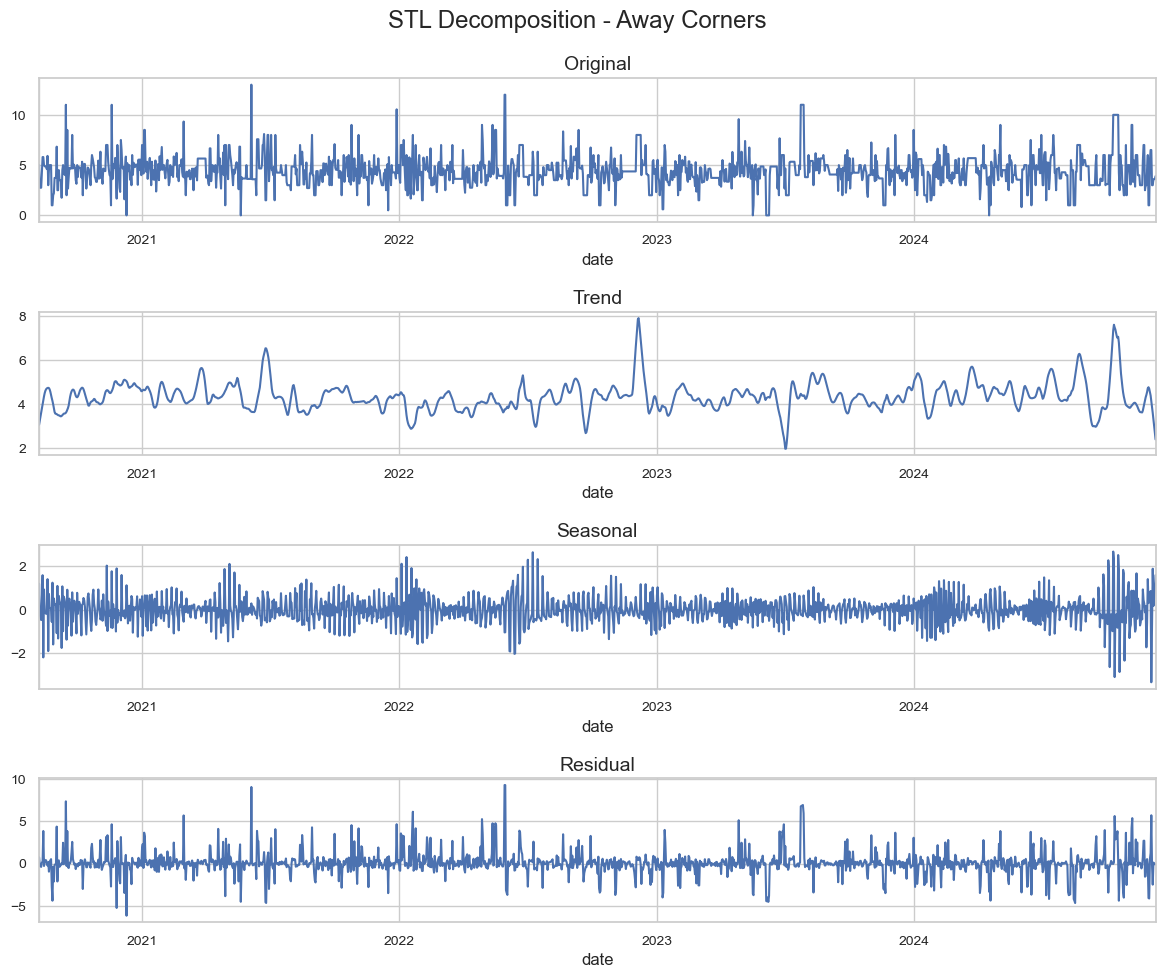

In [82]:
def stl_decomposition(df, date_col='date_time', target_cols=['home_corners', 'away_corners']):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)
    results = {}
    for target in target_cols:
        daily_avg = df.groupby(df[date_col].dt.date)[target].mean().reset_index()
        daily_avg.columns = ['date', target]
        daily_avg['date'] = pd.to_datetime(daily_avg['date'])
        daily_avg = daily_avg.set_index('date')
        daily_avg = daily_avg.asfreq('D').fillna(method='ffill')
        stl = STL(daily_avg[target], seasonal=7, period=7, robust=True)
        decomposition = stl.fit()
        results[target] = {
            'original': daily_avg[target],
            'trend': decomposition.trend,
            'seasonal': decomposition.seasonal, 
            'residual': decomposition.resid
        }  
        fig, axes = plt.subplots(4, 1, figsize=(12, 10))
        fig.suptitle(f'STL Decomposition - {target.replace("_", " ").title()}')
        decomposition.observed.plot(ax=axes[0], title='Original')
        decomposition.trend.plot(ax=axes[1], title='Trend')
        decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
        decomposition.resid.plot(ax=axes[3], title='Residual')
        plt.tight_layout()
        plt.show()
    return results
decomp_results = stl_decomposition(dat)

To capture temporal patterns like trend and seasonality, we’ve engineered time-based features including: day of week, hour of day, weekend flag, and team rest days. 
These provide context for machine learning models, which don’t inherently recognize time structure.

While GLMs typically benefit from one-hot encoding for categorical variables like day of week, we’ve retained it as a single numeric feature (0–6) due to time constraints. This approach remains suitable for tree-based models and AR methods, which handle such features without issue.

In [84]:
def add_basic_time_features(dat):
    dat = dat.copy()
    dat["day_of_week"] = dat["date_time"].dt.dayofweek
    dat["hour_of_day"] = dat["date_time"].dt.hour
    dat["is_weekend"] = dat["day_of_week"].isin([5, 6]).astype(int)
    dat = dat.sort_values(["home_team_id", "date_time"])
    dat["home_prev_time"] = dat.groupby("home_team_id")["date_time"].shift(1)
    dat["home_rest_days"] = (dat["date_time"] - dat["home_prev_time"]).dt.total_seconds() / (3600 * 24)
    dat = dat.sort_values(["away_team_id", "date_time"])
    dat["away_prev_time"] = dat.groupby("away_team_id")["date_time"].shift(1)
    dat["away_rest_days"] = (dat["date_time"] - dat["away_prev_time"]).dt.total_seconds() / (3600 * 24)
    dat.drop(columns=["home_prev_time", "away_prev_time"], inplace=True)
    return dat

dat = add_basic_time_features(dat)
default_rest = int(dat[["home_rest_days", "away_rest_days"]].stack().median())
dat["home_rest_days"] = dat["home_rest_days"].fillna(default_rest)
dat["away_rest_days"] = dat["away_rest_days"].fillna(default_rest)
dat["home_no_prior_match"] = (dat["home_rest_days"] == default_rest).astype(int)
dat["away_no_prior_match"] = (dat["away_rest_days"] == default_rest).astype(int)
nan_counts = dat.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

Columns with missing values:

Series([], dtype: int64)


In [85]:
nan_counts = dat.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)
dat

Columns with missing values:

Series([], dtype: int64)


match_id  home_team_id  away_team_id  competition_id  season_id  \
195     6632836           692           674             795     186267   
299     6632811           687           674             795     186267   
504     6632789           682           674             795     186267   
542     6632779           702           674             795     186267   
894     6632758           696           674             795     186267   
...         ...           ...           ...             ...        ...   
12055  10567142          3779         19830             412     189971   
12183  10567186          3777         19830             412     189971   
12434  10567172          3803         19830             412     189971   
12521  10567285          3766         19830             412     189971   
12650  10567221          3787         19830             412     189971   

                date_time  gameweek  home_corners  away_corners  \
195   2020-09-19 19:00:00         2           6.0           6.0   
299   2020-09-29 17:00:00         4           9.0           3.0   
504   2020-10-18 14:00:00         6           3.0           7.0   
542   2020-10-23 19:00:00         7           0.0           7.0   
894   2020-11-22 20:00:00        10           4.0           5.0   
...                   ...       ...           ...           ...   
12055 2024-03-10 14:00:00        25           5.0           8.0   
12183 2024-03-30 16:00:00        27           5.0           5.0   
12434 2024-04-21 15:00:00        30           7.0           4.0   
12521 2024-04-28 17:00:00        31           3.0           3.0   
12650 2024-05-12 19:00:00        33           3.0           3.0   

       home_corners_mean_5  ...  home_games_played  away_games_played  \
195                    0.0  ...                0.0                0.0   
299                    1.0  ...                1.0                1.0   
504                    4.0  ...                3.0                2.0   
542                    1.0  ...                2.0                3.0   
894                    2.2  ...                5.0                4.0   
...                    ...  ...                ...                ...   
12055                  4.4  ...                5.0                5.0   
12183                  6.0  ...                5.0                5.0   
12434                  4.0  ...                5.0                5.0   
12521                  5.2  ...                5.0                5.0   
12650                  6.0  ...                5.0                5.0   

       match_total_corners_z  h2h_corners_mean_5_isna  match_total_corners  \
195                 1.035001                        1                 12.0   
299                 1.035001                        1                 12.0   
504                 0.411043                        1                 10.0   
542                -0.524893                        1                  7.0   
894                 0.099064                        1                  9.0   
...                      ...                      ...                  ...   
12055               1.087426                        0                 13.0   
12183               0.162218                        0                 10.0   
12434               0.470621                        0                 11.0   
12521              -1.071393                        0                  6.0   
12650              -1.071393                        0                  6.0   

       day_of_week  hour_of_day  is_weekend  home_no_prior_match  \
195              5           19           1                    1   
299              1           17           0                    0   
504              6           14           1                    0   
542              4           19           0                    0   
894              6           20           1                    0   
...            ...          ...         ...                  ...   
12055            6     

**3.) Point Forecasts**

Next We look at forecasting. We'll start with point forecasting, before moving onto probabilistic forecasting.

Evaluation metrics include standard metrics for Point Forecasts:

MAE: Measures average absolute error in predicted corner counts, providing a simple and interpretable measure of accuracy.

RMSE: Penalises larger corner count errors more heavily, which is useful when large mispredictions (e.g. 2 vs 9 corners) matter.

sMAPE: Captures relative percentage error symmetrically, ensuring fair comparison even when corner counts are low or zero.



Distribution-specific:

Log-likelihood - Measures how well the Poisson/NB model captures the full distribution of corner counts for each match. For Poisson/NB models

Deviance - Quantifies the gap between the fitted count model and a perfect corner prediction model.

Betting-specific:

Brier Score - Evaluates how accurately predicted probabilities (e.g. P(corners ≥ 6)) align with binary outcomes.

Log-loss - Penalises overconfident or poorly calibrated corner probability forecasts, critical for betting decision quality.

For Point forecasting we'll use statistical (ARIMAX, SARIMAX, Poisson, and Negative Binomial), machine learning (KNN, XGB, and RF), and deep learning (DNN, LSTM, and GRU) models.

We'll start with statistical models. This includes-

ARIMAX and SARIMAX

Poisson and Negative Binomial


However we need to build into the walk-forward validaion function that certain days have matches that are on at the same time. Thus we have a rule based method:

Two matches on the same day but at different times (e.g., 12:00 and 20:00)

Should be treated differently:

If < 3 hours apart → predict them together (same forecasting batch)

If ≥ 3 hours apart → earlier match can be used to forecast later match.

This allows us to use matches on the same day if theres an adequate gap e.g. ~2 hrs per game, then an extra hour to collect the data, generate a forecast, and submit bids etc.

From ACF and PACF Plots we can see ARIMAX & SARIMAX Models should have components MA(2) from acf function and AR(3) from pacf function. Alternatively we can do a hyperparamater search for each model but to save time I'll just choose the output from acf and pacf. 

In [100]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial
# from statsmodels.genmod.families import Poisson, NegativeBinomial
from scipy.stats import poisson
from statsmodels.genmod.generalized_linear_model import GLM
from scipy.stats import entropy
import statsmodels.api as sm
from datetime import datetime
from patsy import dmatrices
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss, brier_score_loss
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, InputLayer
from tensorflow.keras.optimizers import Adam
import warnings

In [101]:
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denom
    return np.nanmean(diff) * 100
def group_forecast_batches(df, max_gap_hrs=3):
    df = df.sort_values("date_time").reset_index(drop=True).copy()
    df["forecast_batch"] = 0
    prev_time = df.loc[0, "date_time"]
    for i in range(1, len(df)):
        curr_time = df.loc[i, "date_time"]
        if (curr_time - prev_time).total_seconds() >= max_gap_hrs * 3600:
            df.at[i, "forecast_batch"] = df.at[i - 1, "forecast_batch"] + 1
        else:
            df.at[i, "forecast_batch"] = df.at[i - 1, "forecast_batch"]
        prev_time = curr_time
    return df

Random grid search for Sarimax, KNN, XGB, and RF which I'll be skipping to save time and computational cost

In [103]:
# def minimal_random_grid_search(dat, features, target, model_type="rf", n_iter=10, max_batches=5):
#     dat = group_forecast_batches(dat.copy())
#     dat = dat.sort_values("date_time").reset_index(drop=True)

#     # Use last N batches only
#     batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
#     selected_batches = batch_meta.tail(max_batches)["forecast_batch"].tolist()

#     # Default grids
#     if model_type == "rf":
#         grid = {
#             "n_estimators": [50, 100],
#             "max_depth": [5, 10, None],
#             "min_samples_split": [2, 5]
#         }
#     elif model_type == "xgb":
#         grid = {
#             "n_estimators": [50, 100],
#             "max_depth": [3, 5, 7],
#             "learning_rate": [0.05, 0.1, 0.2]
#         }
#     elif model_type == "knn":
#         grid = {
#             "n_neighbors": [3, 5, 7],
#             "weights": ["uniform", "distance"]
#         }
#     else:
#         raise ValueError("Unsupported model type")

#     def sample_config():
#         return {k: random.choice(v) for k, v in grid.items()}

#     def get_model(cfg):
#         if model_type == "rf":
#             reg = RandomForestRegressor(**cfg, random_state=0, n_jobs=-1)
#         elif model_type == "xgb":
#             reg = XGBRegressor(**cfg, objective="reg:squarederror", verbosity=0, random_state=0)
#         elif model_type == "knn":
#             reg = KNeighborsRegressor(**cfg)
#         return make_pipeline(SimpleImputer(), reg)

#     results = []
#     for _ in range(n_iter):
#         config = sample_config()
#         model = get_model(config)
#         y_true_all, y_pred_all = [], []

#         for batch in selected_batches:
#             test = dat[dat["forecast_batch"] == batch]
#             train = dat[dat["date_time"] < test["date_time"].min()]
#             if train.empty or test.empty:
#                 continue

#             model.fit(train[features], train[target])
#             pred = np.round(model.predict(test[features]))
#             y_true_all.extend(test[target])
#             y_pred_all.extend(pred)

#         y_true = np.array(y_true_all)
#         y_pred = np.array(y_pred_all)
#         mae = mean_absolute_error(y_true, y_pred)
#         rmse = mean_squared_error(y_true, y_pred, squared=False)
#         smape_val = smape(y_true, y_pred)
#         results.append({
#             "params": config,
#             "MAE": mae,
#             "RMSE": rmse,
#             "sMAPE": smape_val
#         })

#     return pd.DataFrame(results).sort_values("MAE").reset_index(drop=True)

# def search_sarimax_hyperparams(
#     dat,
#     features,
#     target,
#     order_grid=[(1,1,1), (2,1,2), (3,1,2)],
#     seasonal_order_grid=[None],
#     max_gap_hrs=3,
#     min_train_days=60,
#     max_batches=10,
#     verbose=True,
#     round_outputs=True
# ):
#     results = []
#     dat = group_forecast_batches(dat.copy(), max_gap_hrs=max_gap_hrs)
#     dat = dat.sort_values("date_time").reset_index(drop=True)

#     # Get last N batches to evaluate
#     batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
#     cutoff_time = dat["date_time"].max() - timedelta(days=min_train_days)
#     batch_meta = batch_meta[batch_meta["date_time"] >= cutoff_time]
#     selected_batches = batch_meta.tail(max_batches)["forecast_batch"].tolist()

#     for order, seasonal in product(order_grid, seasonal_order_grid):
#         all_y_true = []
#         all_y_pred = []
#         model_label = f"ARIMAX{order}" if seasonal is None else f"SARIMAX{order}+{seasonal}"
#         if verbose:
#             print(f"\n Testing {model_label}")

#         for batch_id in selected_batches:
#             test = dat[dat["forecast_batch"] == batch_id]
#             if test.empty:
#                 continue
#             earliest_time = test["date_time"].min()
#             train = dat[dat["date_time"] < earliest_time]
#             if train.empty:
#                 continue

#             X_train = train[features]
#             X_test = test[features]
#             y_train = train[target]
#             y_test = test[target]

#             try:
#                 model = SARIMAX(
#                     endog=y_train,
#                     exog=X_train,
#                     order=order,
#                     seasonal_order=seasonal if seasonal else (0,0,0,0),
#                     enforce_stationarity=False,
#                     enforce_invertibility=False,
#                 )
#                 model_fit = model.fit(disp=False)
#                 preds = model_fit.forecast(steps=len(test), exog=X_test)
#                 if round_outputs:
#                     preds = np.round(preds)
#                 all_y_true.extend(y_test.tolist())
#                 all_y_pred.extend(preds.tolist())

#             except Exception as e:
#                 if verbose:
#                     print(f" Failed on batch {batch_id}: {e}")
#                 all_y_true.extend(y_test.tolist())
#                 all_y_pred.extend([np.nan]*len(test))

#         # Evaluate
#         y_true = np.array(all_y_true)
#         y_pred = np.array(all_y_pred)
#         mask = ~np.isnan(y_pred)
#         mae = mean_absolute_error(y_true[mask], y_pred[mask])
#         rmse = mean_squared_error(y_true[mask], y_pred[mask], squared=False)
#         smape_val = smape(y_true[mask], y_pred[mask])

#         results.append({
#             "order": order,
#             "seasonal_order": seasonal,
#             "MAE": mae,
#             "RMSE": rmse,
#             "sMAPE": smape_val
#         })

#         if verbose:
#             print(f"→ MAE: {mae:.3f} | RMSE: {rmse:.3f} | sMAPE: {smape_val:.2f}%")

#     result_df = pd.DataFrame(results).sort_values("MAE")
#     print("\n🏁 Top 5 configurations by MAE:")
#     print(result_df.head(5))
#     return result_df

In [245]:
def walk_forward_sarimax(dat, features, targets, order=(3, 1, 2), seasonal_order=None, train_start_time="2024-01-01", train_end_time="2024-04-12",
    test_end_time=None, max_gap_hrs=3, round_outputs=True,):
    dat = (dat.copy().pipe(group_forecast_batches, max_gap_hrs=max_gap_hrs).sort_values("date_time").reset_index(drop=True)) #I'm aware this is redundant
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    model_name = "SARIMAX" if seasonal_order else "ARIMAX"
    print(f"\n {model_name} Walk‑Forward Validation"
        f" | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}"
        f" | Max gap = {max_gap_hrs}h\n")
    results = {t: {"y_true": [], "y_pred": []} for t in targets}
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train = train[features]
        X_test = test[features]
        for target in targets:
            y_train = train[target]
            y_test = test[target]
            try:
                model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order if seasonal_order else (0, 0, 0, 0),
                    enforce_stationarity=False, enforce_invertibility=False,)
                model_fit = model.fit(disp=False)
                preds = model_fit.forecast(steps=len(test), exog=X_test)
                if round_outputs:
                    preds = np.round(preds)
                results[target]["y_pred"].extend(preds.tolist())
                results[target]["y_true"].extend(y_test.tolist())
            except Exception as e:
                print(f" {target.upper()} batch {batch_id} on {earliest_time.date()} failed: {e}")
                results[target]["y_pred"].extend([np.nan] * len(test))
                results[target]["y_true"].extend(y_test.tolist())
                continue
        print(f" {earliest_time.date()} | Forecasted {len(test)} matches | Train size: {len(train)}")
    print("\n Final evaluation:")
    for t in targets:
        y_true = np.array(results[t]["y_true"])
        y_pred = np.array(results[t]["y_pred"])
        mask = ~np.isnan(y_pred)
        mae = mean_absolute_error(y_true[mask], y_pred[mask])
        rmse = mean_squared_error(y_true[mask], y_pred[mask], squared=False)
        smape_val = smape(y_true[mask], y_pred[mask])
        print(f"\n{t.upper()}"
              f"\n  MAE   : {mae:.3f}"
              f"\n  RMSE  : {rmse:.3f}"
              f"\n  sMAPE : {smape_val:.2f}%")

    return results

In [247]:
targets = ["home_corners", "away_corners"]
exclude = ["match_id", "home_team_id", "away_team_id", "competition_id", "season_id", "date_time"] + targets
features = [c for c in dat.columns if c not in exclude and dat[c].dtype != "O"]
# ARIMAX - no seasonal component
walk_forward_sarimax(dat, features, targets, order=(3, 1, 2), train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16");
# SARIMAX 
walk_forward_sarimax(dat, features, targets, order=(3, 1, 2), seasonal_order=(1, 1, 1, 7), train_start_time="2024-06-01", train_end_time="2024-11-01",  test_end_time="2024-12-01");


 ARIMAX Walk‑Forward Validation | Train ≤ 2024-04-12 | Test ≤ 2024-05-16 | Max gap = 3h

 2024-04-12 | Forecasted 5 matches | Train size: 905
 2024-04-13 | Forecasted 34 matches | Train size: 910
 2024-04-14 | Forecasted 23 matches | Train size: 944
 2024-04-15 | Forecasted 4 matches | Train size: 967
 2024-04-16 | Forecasted 1 matches | Train size: 971
 2024-04-17 | Forecasted 1 matches | Train size: 972
 2024-04-17 | Forecasted 7 matches | Train size: 973
 2024-04-19 | Forecasted 1 matches | Train size: 980
 2024-04-19 | Forecasted 5 matches | Train size: 981
 2024-04-20 | Forecasted 28 matches | Train size: 986
 2024-04-21 | Forecasted 28 matches | Train size: 1014
 2024-04-22 | Forecasted 4 matches | Train size: 1042
 2024-04-23 | Forecasted 2 matches | Train size: 1046
 2024-04-24 | Forecasted 8 matches | Train size: 1048
 2024-04-25 | Forecasted 2 matches | Train size: 1056
 2024-04-26 | Forecasted 5 matches | Train size: 1058
 2024-04-27 | Forecasted 32 matches | Train size: 10

For Machine Learning models We'll look at-

Random Forest

KNN 

XGBoost

#Support Vector Regression (left out, time constraint)

In [110]:
def walk_forward_validation(dat, features, targets, model_type="rf", train_start_time="2024-01-01",  train_end_time="2024-04-12",
    test_end_time=None, max_gap_hrs=3, round_outputs=True,):
    dat = (dat.copy().pipe(group_forecast_batches, max_gap_hrs=max_gap_hrs).sort_values("date_time").reset_index(drop=True))
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\n{model_type.upper()} | Walk‑forward {max_gap_hrs}‑h batches"
        f" | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}")
    def get_model():
        base_kwargs = dict(n_estimators=100, random_state=42) if model_type in {"rf", "xgb"} else {}
        if model_type == "knn":
            reg = KNeighborsRegressor(n_neighbors=5)
        elif model_type == "rf":
            reg = RandomForestRegressor(n_jobs=-1, **base_kwargs)
        elif model_type == "xgb":
            reg = XGBRegressor(learning_rate=0.1, objective="reg:squarederror", verbosity=0, **base_kwargs)
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")
        return make_pipeline(SimpleImputer(strategy="mean"), reg)
    results = {t: {"y_true": [], "y_pred": []} for t in targets}
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train, X_test = train[features], test[features]
        for target in targets:
            y_train, y_test = train[target], test[target]
            model = get_model()
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            if round_outputs:
                preds = np.round(preds)
            results[target]["y_pred"].extend(preds.tolist())
            results[target]["y_true"].extend(y_test.tolist())
        print(f"{earliest_time.date()} | forecasted {len(test)} matches | train rows: {len(train)}")
    print("\n Final evaluation:")
    for t in targets:
        y_true = np.array(results[t]["y_true"])
        y_pred = np.array(results[t]["y_pred"])
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        print(f"\n{t.upper()}"
              f"\n  MAE   : {mae:.3f}"
              f"\n  RMSE  : {rmse:.3f}"
              f"\n  sMAPE : {smape(y_true, y_pred):.2f}%")
    return results

In [111]:
results_xgb = walk_forward_validation(dat=dat, features=features, targets=["home_corners", "away_corners"], model_type="xgb",
    train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16")
results_knn = walk_forward_validation(dat=dat, features=features, targets=["home_corners", "away_corners"], model_type="knn",
    train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16")
results_rf = walk_forward_validation(dat=dat, features=features, targets=["home_corners", "away_corners"], model_type="rf",
    train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16")


XGB | Walk‑forward 3‑h batches | Train ≤ 2024-04-12 | Test ≤ 2024-05-16
2024-04-12 | forecasted 5 matches | train rows: 905
2024-04-13 | forecasted 34 matches | train rows: 910
2024-04-14 | forecasted 23 matches | train rows: 944
2024-04-15 | forecasted 4 matches | train rows: 967
2024-04-16 | forecasted 1 matches | train rows: 971
2024-04-17 | forecasted 1 matches | train rows: 972
2024-04-17 | forecasted 7 matches | train rows: 973
2024-04-19 | forecasted 1 matches | train rows: 980
2024-04-19 | forecasted 5 matches | train rows: 981
2024-04-20 | forecasted 28 matches | train rows: 986
2024-04-21 | forecasted 28 matches | train rows: 1014
2024-04-22 | forecasted 4 matches | train rows: 1042
2024-04-23 | forecasted 2 matches | train rows: 1046
2024-04-24 | forecasted 8 matches | train rows: 1048
2024-04-25 | forecasted 2 matches | train rows: 1056
2024-04-26 | forecasted 5 matches | train rows: 1058
2024-04-27 | forecasted 32 matches | train rows: 1063
2024-04-28 | forecasted 29 matc

  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


2024-04-13 | forecasted 34 matches | train rows: 910
2024-04-14 | forecasted 23 matches | train rows: 944
2024-04-15 | forecasted 4 matches | train rows: 967
2024-04-16 | forecasted 1 matches | train rows: 971
2024-04-17 | forecasted 1 matches | train rows: 972
2024-04-17 | forecasted 7 matches | train rows: 973
2024-04-19 | forecasted 1 matches | train rows: 980
2024-04-19 | forecasted 5 matches | train rows: 981
2024-04-20 | forecasted 28 matches | train rows: 986
2024-04-21 | forecasted 28 matches | train rows: 1014
2024-04-22 | forecasted 4 matches | train rows: 1042
2024-04-23 | forecasted 2 matches | train rows: 1046
2024-04-24 | forecasted 8 matches | train rows: 1048
2024-04-25 | forecasted 2 matches | train rows: 1056
2024-04-26 | forecasted 5 matches | train rows: 1058
2024-04-27 | forecasted 32 matches | train rows: 1063
2024-04-28 | forecasted 29 matches | train rows: 1095
2024-04-29 | forecasted 3 matches | train rows: 1124
2024-04-29 | forecasted 1 matches | train rows: 1

For Deep Learning models, including RNNs, We'll look at-

Deep Neural Network

LSTM 

GRU

In [115]:
def build_dnn(input_dim):
    model = Sequential([
        InputLayer(input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model
    
#All simple models without hyperparamter optimisation. Computational cost is too high given the time constraint.

def walk_forward_dl(dat, features, targets, model_type="dnn",  # or "lstm"
    train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time=None, max_gap_hrs=3, round_outputs=True, epochs=20, verbose=0,):
    dat = (dat.copy().pipe(group_forecast_batches, max_gap_hrs=max_gap_hrs).sort_values("date_time").reset_index(drop=True))
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\n {model_type.upper()} | Walk‑forward {max_gap_hrs}‑h batches"
        f" | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}")
    results = {t: {"y_true": [], "y_pred": []} for t in targets}
    imputer = SimpleImputer(strategy="mean")
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train, X_test = train[features], test[features]
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)
        if model_type in ["lstm", "gru"]:
            X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
            X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        for target in targets:
            y_train = train[target].values
            y_test = test[target].values
            if model_type == "dnn":
                model = build_dnn(X_train.shape[1])
            elif model_type == "lstm":
                model = build_lstm(X_train.shape[1:])
            elif model_type == "gru":
                model = build_gru(X_train.shape[1:])
            else:
                raise ValueError("model_type must be 'dnn', 'lstm', or 'gru'")
            model.fit(X_train, y_train, epochs=epochs, verbose=verbose)
            preds = model.predict(X_test, verbose=0).flatten()
            if round_outputs:
                preds = np.round(preds)
            results[target]["y_pred"].extend(preds.tolist())
            results[target]["y_true"].extend(y_test.tolist())
        print(f" {earliest_time.date()} | Forecasted {len(test)} matches | Train rows: {len(train)}")
    print("\n Final Evaluation:")
    for t in targets:
        y_true = np.array(results[t]["y_true"])
        y_pred = np.array(results[t]["y_pred"])
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        smape_val = smape(y_true, y_pred)
        print(f"\n🔹 {t.upper()}"
              f"\n  MAE   : {mae:.3f}"
              f"\n  RMSE  : {rmse:.3f}"
              f"\n  sMAPE : {smape_val:.2f}%")
    return results

In [116]:
features = [c for c in dat.columns if c not in ["home_corners", "away_corners", "date_time", "match_id", "home_team_id", "away_team_id", "competition_id", "season_id"]]
results_dnn= walk_forward_dl(dat=dat, features=features, targets=["home_corners", "away_corners"], model_type="dnn",  train_start_time="2024-01-01",
    train_end_time="2024-04-12", test_end_time="2024-05-16", max_gap_hrs=3, epochs=10, verbose=0);
results_lstm= walk_forward_dl(dat=dat, features=features, targets=["home_corners", "away_corners"], model_type="lstm", train_start_time="2024-01-01",
    train_end_time="2024-04-12", test_end_time="2024-05-16", max_gap_hrs=3, epochs=10, verbose=0);
results_gru= walk_forward_dl(dat=dat, features=features,  targets=["home_corners", "away_corners"], model_type="gru", train_start_time="2024-01-01",
    train_end_time="2024-04-12", test_end_time="2024-05-16", max_gap_hrs=3, epochs=10, verbose=0);


 DNN | Walk‑forward 3‑h batches | Train ≤ 2024-04-12 | Test ≤ 2024-05-16
 2024-04-12 | Forecasted 5 matches | Train rows: 905
 2024-04-13 | Forecasted 34 matches | Train rows: 910
 2024-04-14 | Forecasted 23 matches | Train rows: 944
 2024-04-15 | Forecasted 4 matches | Train rows: 967
 2024-04-16 | Forecasted 1 matches | Train rows: 971
 2024-04-17 | Forecasted 1 matches | Train rows: 972
 2024-04-17 | Forecasted 7 matches | Train rows: 973
 2024-04-19 | Forecasted 1 matches | Train rows: 980
 2024-04-19 | Forecasted 5 matches | Train rows: 981
 2024-04-20 | Forecasted 28 matches | Train rows: 986
 2024-04-21 | Forecasted 28 matches | Train rows: 1014
 2024-04-22 | Forecasted 4 matches | Train rows: 1042
 2024-04-23 | Forecasted 2 matches | Train rows: 1046
 2024-04-24 | Forecasted 8 matches | Train rows: 1048
 2024-04-25 | Forecasted 2 matches | Train rows: 1056
 2024-04-26 | Forecasted 5 matches | Train rows: 1058
 2024-04-27 | Forecasted 32 matches | Train rows: 1063
 2024-04-28 |

Next up we have Poisson and Negative Binomial.

Our evaluation metrics will be extended to include:

Log-Likelihood Captures how well the model fits the full probability distribution of corner outcomes — essential for probabilistic models like Poisson/NB. 

Deviance Measures the lack of fit relative to a perfect model; lower values indicate better overall distributional fit (Poisson only).

Brier Score Evaluates the accuracy of predicted probabilities for a binary classification (e.g., corners ≥ 6); lower means better-calibrated probabilities. 

LogLoss (Binary) Penalises incorrect or overconfident probability estimates for binary events, useful for betting decision quality (e.g., over/under 5.5 corners).

In [131]:
def walk_forward_glm_validation(dat, features, targets, model_type="poisson",  # "poisson" or "nb"
    train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time=None,  max_gap_hrs=3,  prob_threshold=6):
    assert model_type in {"poisson", "nb"}
    dat = dat.copy().sort_values("date_time").reset_index(drop=True)
    dat["forecast_batch"] = 0
    prev_time = dat.loc[0, "date_time"]
    for i in range(1, len(dat)):
        curr_time = dat.loc[i, "date_time"]
        if (curr_time - prev_time).total_seconds() >= max_gap_hrs * 3600:
            dat.at[i, "forecast_batch"] = dat.at[i - 1, "forecast_batch"] + 1
        else:
            dat.at[i, "forecast_batch"] = dat.at[i - 1, "forecast_batch"]
        prev_time = curr_time
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\n{model_type.upper()} | Walk‑forward {max_gap_hrs}‑h batches | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}")
    results = {t: {"y_true": [], "y_pred": [], "loglik": 0, "deviance": 0, "brier_probs": [], "brier_true": [], "logloss_probs": [], "logloss_true": []} for t in targets }
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train = train[features].copy()
        X_test = test[features].copy()
        X_train_const = sm.add_constant(X_train, has_constant='add')
        X_test_const = sm.add_constant(X_test, has_constant='add')
        for df in [X_train_const, X_test_const]:
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.fillna(0, inplace=True)
        valid_cols = X_train_const.loc[:, X_train_const.std() > 1e-6].columns
        X_train_const = X_train_const[valid_cols]
        X_test_const = X_test_const[valid_cols]
        if X_train_const.shape[1] == 0:
            print(f" Skipped batch {batch_id} ({earliest_time.date()}): no valid features after filtering")
            continue
        for target in targets:
            y_train = train[target]
            y_test = test[target]
            if y_train.empty or y_test.empty:
                print(f" Skipped batch {batch_id} ({earliest_time.date()}): empty target")
                continue
            try:
                if model_type == "poisson":
                    model = GLM(y_train, X_train_const, family=Poisson()).fit()
                elif model_type == "nb":
                    model = NegativeBinomial(y_train, X_train_const).fit()
                preds = model.predict(X_test_const)
                results[target]["loglik"] += model.llf
                if model_type == "poisson":
                    results[target]["deviance"] += model.deviance
                prob_ge_thresh = 1 - poisson.cdf(prob_threshold - 1, preds)
                prob_ge_thresh = np.clip(prob_ge_thresh, 0, 1)
                y_binary = (y_test >= prob_threshold).astype(int)
                results[target]["brier_probs"].extend(prob_ge_thresh.tolist())
                results[target]["brier_true"].extend(y_binary.tolist())
                results[target]["logloss_probs"].extend(prob_ge_thresh.tolist())
                results[target]["logloss_true"].extend(y_binary.tolist())
                results[target]["y_pred"].extend(preds.tolist())
                results[target]["y_true"].extend(y_test.tolist())
            except Exception as e:
                print(f" Skipped batch {batch_id} ({earliest_time.date()}) — error: {e}")
                print(f"    Shapes — X: {X_train_const.shape}, y: {y_train.shape}")
                continue
        print(f" {earliest_time.date()} | Forecasted {len(test)} matches | Train rows: {len(train)}")

    print("\n Final Evaluation:")
    for t in targets:
        y_true = np.array(results[t]["y_true"])
        y_pred = np.array(results[t]["y_pred"])
        if len(y_true) == 0 or len(y_pred) == 0:
            print(f"\n🔹 {t.upper()} — No valid predictions made.")
            continue
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        smape_val = smape(y_true, y_pred)
        loglik = results[t]["loglik"]
        deviance = results[t]["deviance"] if model_type == "poisson" else "n/a"
        try:
            brier = brier_score_loss(results[t]["brier_true"], results[t]["brier_probs"])
            logloss = log_loss(results[t]["logloss_true"], results[t]["logloss_probs"], labels=[0, 1])
        except Exception as e:
            brier = f"Error: {e}"
            logloss = f"Error: {e}"
        print(f"\n {t.upper()}")
        print(f"  MAE       : {mae:.3f}")
        print(f"  RMSE      : {rmse:.3f}")
        print(f"  sMAPE     : {smape_val:.2f}%")
        print(f"  LogLik    : {loglik:.2f}")
        print(f"  Deviance  : {deviance}")
        print(f"  Brier     : {brier}")
        print(f"  LogLoss   : {logloss}")
    return results

In [133]:
results_poisson = walk_forward_glm_validation(dat=dat, features=features, targets=["home_corners", "away_corners"], model_type="poisson",
    train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16")
results_nb = walk_forward_glm_validation(dat=dat, features=features, targets=["home_corners", "away_corners"],  model_type="nb",
    train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16")


POISSON | Walk‑forward 3‑h batches | Train ≤ 2024-04-12 | Test ≤ 2024-05-16
 2024-04-12 | Forecasted 5 matches | Train rows: 905
 2024-04-13 | Forecasted 34 matches | Train rows: 910
 2024-04-14 | Forecasted 23 matches | Train rows: 944
 2024-04-15 | Forecasted 4 matches | Train rows: 967
 2024-04-16 | Forecasted 1 matches | Train rows: 971
 2024-04-17 | Forecasted 1 matches | Train rows: 972
 2024-04-17 | Forecasted 7 matches | Train rows: 973
 2024-04-19 | Forecasted 1 matches | Train rows: 980
 2024-04-19 | Forecasted 5 matches | Train rows: 981
 2024-04-20 | Forecasted 28 matches | Train rows: 986
 2024-04-21 | Forecasted 28 matches | Train rows: 1014
 2024-04-22 | Forecasted 4 matches | Train rows: 1042
 2024-04-23 | Forecasted 2 matches | Train rows: 1046
 2024-04-24 | Forecasted 8 matches | Train rows: 1048
 2024-04-25 | Forecasted 2 matches | Train rows: 1056
 2024-04-26 | Forecasted 5 matches | Train rows: 1058
 2024-04-27 | Forecasted 32 matches | Train rows: 1063
 2024-04-2

In [136]:
results = [
    {"Model": "ARIMAX", "Target": "Home", "MAE": 2.173, "RMSE": 4.509, "sMAPE": 39.47},
    {"Model": "ARIMAX", "Target": "Away", "MAE": 2.156, "RMSE": 4.505, "sMAPE": 53.00},
    {"Model": "SARIMAX", "Target": "Home", "MAE": 1.755, "RMSE": 2.407, "sMAPE": 29.98},
    {"Model": "SARIMAX", "Target": "Away", "MAE": 1.811, "RMSE": 2.449, "sMAPE": 51.94},
    {"Model": "XGB", "Target": "Home", "MAE": 1.776, "RMSE": 2.224, "sMAPE": 37.33},
    {"Model": "XGB", "Target": "Away", "MAE": 1.811, "RMSE": 2.293, "sMAPE": 48.60},
    {"Model": "KNN", "Target": "Home", "MAE": 1.997, "RMSE": 2.583, "sMAPE": 40.05},
    {"Model": "KNN", "Target": "Away", "MAE": 1.895, "RMSE": 2.456, "sMAPE": 49.61},
    {"Model": "RF", "Target": "Home", "MAE": 1.709, "RMSE": 2.166, "sMAPE": 35.53},
    {"Model": "RF", "Target": "Away", "MAE": 1.693, "RMSE": 2.138, "sMAPE": 45.83},
    {"Model": "DNN", "Target": "Home", "MAE": 2.097, "RMSE": 4.426, "sMAPE": 37.59},
    {"Model": "DNN", "Target": "Away", "MAE": 1.957, "RMSE": 3.292, "sMAPE": 48.62},
    {"Model": "LSTM", "Target": "Home", "MAE": 1.714, "RMSE": 2.226, "sMAPE": 35.59},
    {"Model": "LSTM", "Target": "Away", "MAE": 1.701, "RMSE": 2.213, "sMAPE": 46.61},
    {"Model": "GRU", "Target": "Home", "MAE": 1.668, "RMSE": 2.220, "sMAPE": 34.93},
    {"Model": "GRU", "Target": "Away", "MAE": 1.730, "RMSE": 2.264, "sMAPE": 47.47},
    {"Model": "NB", "Target": "Home", "MAE": 1.949, "RMSE": 2.917, "sMAPE": 36.99,
     "LogLik": -75842.29, "Deviance": None, "Brier": 0.1809, "LogLoss": 0.5721},
    {"Model": "NB", "Target": "Away", "MAE": 3.052, "RMSE": 25.477, "sMAPE": 49.12,
     "LogLik": -74519.64, "Deviance": None, "Brier": 0.1661, "LogLoss": 0.5089},
    {"Model": "Poisson", "Target": "Home", "MAE": 1.943, "RMSE": 2.868, "sMAPE": 36.97,
     "LogLik": -75838.20, "Deviance": 29186.92, "Brier": 0.1810, "LogLoss": 0.5665},
    {"Model": "Poisson", "Target": "Away", "MAE": 3.021, "RMSE": 24.879, "sMAPE": 49.12,
     "LogLik": -74518.07, "Deviance": 36329.38, "Brier": 0.1662, "LogLoss": 0.5091}]
df = pd.DataFrame(results)
df_sorted = df.sort_values("MAE")
styled = (df_sorted.style.format({"MAE": "{:.3f}", "RMSE": "{:.3f}", "sMAPE": "{:.2f}%", "LogLik": "{:.2f}", "Deviance": "{:.2f}", "Brier": "{:.4f}",
        "LogLoss": "{:.4f}"}).set_table_styles([{'selector': 'caption', 'props': [('caption-side', 'bottom'), ('font-weight', 'bold'),
                   ('font-size', '12pt'), ('color', '#333')]}, {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
        {'selector': 'td','props': [('text-align', 'center')]},]).hide(axis="index"))
styled

Leaderboard highlights.

Home corners: the GRU network achieves the lowest MAE (1.67) and RMSE (2.22), edging out Random Forest and LSTM. 

Away corners: Random Forest leads on MAE (1.69) and RMSE (2.14), with GRU/LSTM close behind. Statistical baselines (SARIMAX) trail neural and tree models on scale‑dependent errors but remain competitive on sMAPE, reflecting their calibrated percentage accuracy. 

I'll proceed with using Random Forest for data segmentation of only using the rows with the teams for the training data.

For each test batch we trained a Random Forest on only previous fixtures involving the same two teams (as either home or away), falling back to the full dataset when < 10 such matches existed.

In [142]:
def walk_forward_validation(dat, features, targets, model_type="rf", train_start_time="2024-01-01", train_end_time="2024-04-12",
    test_end_time=None, max_gap_hrs=3, round_outputs=True, restrict_to_test_teams=True, min_team_matches=10,):
    dat = (dat.copy().pipe(group_forecast_batches, max_gap_hrs=max_gap_hrs).sort_values("date_time").reset_index(drop=True))
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\n{model_type.upper()} | Walk‑forward {max_gap_hrs}‑h batches"
        f" | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}")
    def get_model():
        base_kwargs = dict(n_estimators=100, random_state=42) if model_type in {"rf", "xgb"} else {}
        if model_type == "knn":
            reg = KNeighborsRegressor(n_neighbors=5)
        elif model_type == "rf":
            reg = RandomForestRegressor(n_jobs=-1, **base_kwargs)
        elif model_type == "xgb":
            reg = XGBRegressor(learning_rate=0.1, objective="reg:squarederror", verbosity=0, **base_kwargs)
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")
        return make_pipeline(SimpleImputer(strategy="mean"), reg)
    results = {t: {"y_true": [], "y_pred": []} for t in targets}
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train_full = dat[dat["date_time"] < earliest_time]
        if restrict_to_test_teams:
            test_teams = set(test["home_team_id"]).union(set(test["away_team_id"]))
            train_filtered = train_full[
                train_full["home_team_id"].isin(test_teams) | train_full["away_team_id"].isin(test_teams)
            ]
            if len(train_filtered) >= min_team_matches:
                train = train_filtered
                filter_note = f"(filtered to {len(train)} team matches)"
            else:
                train = train_full
                filter_note = f"(used full {len(train)} matches due to low team overlap)"
        else:
            train = train_full
            filter_note = f"(full {len(train)} matches)"
        if train.empty:
            print(f"{earliest_time.date()} | Skipped: No training data")
            continue
        X_train, X_test = train[features], test[features]
        for target in targets:
            y_train, y_test = train[target], test[target]
            model = get_model()
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            if round_outputs:
                preds = np.round(preds)
            results[target]["y_pred"].extend(preds.tolist())
            results[target]["y_true"].extend(y_test.tolist())
        print(f"{earliest_time.date()} | forecasted {len(test)} matches | train rows: {len(train)} {filter_note}")
    print("\n Final evaluation:")
    for t in targets:
        y_true = np.array(results[t]["y_true"])
        y_pred = np.array(results[t]["y_pred"])
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        print(f"\n{t.upper()}"
              f"\n  MAE   : {mae:.3f}"
              f"\n  RMSE  : {rmse:.3f}"
              f"\n  sMAPE : {smape(y_true, y_pred):.2f}%")
    return results

results_rf = walk_forward_validation(dat=dat, features=features, targets=["home_corners", "away_corners"], model_type="xgb",
    train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16", restrict_to_test_teams=True )


XGB | Walk‑forward 3‑h batches | Train ≤ 2024-04-12 | Test ≤ 2024-05-16
2024-04-12 | forecasted 5 matches | train rows: 143 (filtered to 143 team matches)
2024-04-13 | forecasted 34 matches | train rows: 689 (filtered to 689 team matches)
2024-04-14 | forecasted 23 matches | train rows: 376 (filtered to 376 team matches)
2024-04-15 | forecasted 4 matches | train rows: 100 (filtered to 100 team matches)
2024-04-16 | forecasted 1 matches | train rows: 40 (filtered to 40 team matches)
2024-04-17 | forecasted 1 matches | train rows: 972 (used full 972 matches due to low team overlap)
2024-04-17 | forecasted 7 matches | train rows: 10 (filtered to 10 team matches)
2024-04-19 | forecasted 1 matches | train rows: 980 (used full 980 matches due to low team overlap)
2024-04-19 | forecasted 5 matches | train rows: 141 (filtered to 141 team matches)
2024-04-20 | forecasted 28 matches | train rows: 643 (filtered to 643 team matches)
2024-04-21 | forecasted 28 matches | train rows: 549 (filtered t

 This tailored training raised MAE from 1.71 → 1.89 (home) and 1.69 → 1.83 (away) and likewise degraded RMSE, indicating that the drastic sample reduction outweighed any relevance gain. Team‑specific patterns are evidently captured well enough by global features (e.g., rolling means) without discarding broader data.
 
Next step could be to retain the full dataset but encode team identity via learned embeddings or hierarchical (mixed‑effects) models to allow partial pooling rather than hard filtering.

 **4.) Probalistic Forecasts**

For Probabilsitc Forecasting we'll look at Quantile Regressor, Quantile Random Forest, Bootstrapped Prediction Intervals, Monte Carlo Simulation, and Conformal Prediciton (specifically time series adapted Ensemble batch Prediction Intervals).

Evaluation metrics include standard metrics for Probabilistic Forecasts. These will be split into assessing Efficiency and Validity.

For Efficiency we'll look at:

Pinball Loss: Measures the accuracy of quantile predictions, essential for evaluating probabilistic forecasts of corner counts where exact outcomes are uncertain. 

Interval Width: Captures the sharpness of predictions, indicating how efficiently the model narrows uncertainty in the context of highly variable match outcomes. 

For Validity We'll look at:

Coverage: Assesses how often observed corner outcomes fall within predicted intervals, reflecting the reliability of uncertainty estimates. 

For Efficiency and Validity:

Winkler Score (Efficiency and Validity tied together): Combines interval accuracy and sharpness into a single metric, providing a holistic view of forecast quality critical for betting and risk assessment in football analytics.

In [153]:
from sklearn_quantile import RandomForestQuantileRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_pinball_loss
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

In [154]:
def pinball_loss(y_true, y_pred, alpha):
    diff = y_true - y_pred
    return np.mean(np.maximum(alpha * diff, (alpha - 1) * diff))

def winkler_score(y_true, lower, upper, alpha=0.2):
    width = upper - lower
    score = width.copy()
    score[y_true < lower] += 2 / alpha * (lower[y_true < lower] - y_true[y_true < lower])
    score[y_true > upper] += 2 / alpha * (y_true[y_true > upper] - upper[y_true > upper])
    return np.mean(score)

Standard Quantile Regressor

In [369]:
def walk_forward_quantile_regression(dat, features, targets, quantiles=[0.1, 0.5, 0.9], train_start_time="2024-01-01",  train_end_time="2024-04-12",
    test_end_time="2024-05-16", max_gap_hrs=3):
    dat = (dat.copy().pipe(group_forecast_batches, max_gap_hrs=max_gap_hrs).sort_values("date_time").reset_index(drop=True))
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\n Walk-forward Quantile Regression | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}")
    results = {
        target: {
            "y_true": [],
            "q_preds": {q: [] for q in quantiles}
        } for target in targets
    }
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train = train[features]
        X_test = test[features]
        for target in targets:
            y_train = train[target]
            y_test = test[target]
            results[target]["y_true"].extend(y_test.tolist())
            for q in quantiles:
                try:
                    model = make_pipeline(SimpleImputer(strategy="mean"), QuantileRegressor(quantile=q, alpha=0.1))
                    model.fit(X_train, y_train)
                    preds = model.predict(X_test)
                    results[target]["q_preds"][q].extend(preds.tolist())
                except Exception as e:
                    print(f" Failed for q={q} batch {batch_id} {target.upper()}: {e}")
                    results[target]["q_preds"][q].extend([np.nan] * len(test))
                    continue
        print(f" {earliest_time.date()} | Forecasted {len(test)} matches | Train size: {len(train)}")

    print("\n Final Evaluation Metrics (per target):")
    for target in targets:
        y_true = np.array(results[target]["y_true"])
        q_preds = results[target]["q_preds"]
        print(f"\n {target.upper()}")
        pred_arrays = {q: np.array(q_preds[q]) for q in quantiles}
        mask = np.ones_like(y_true, dtype=bool)
        for q_arr in pred_arrays.values():
            mask &= np.isfinite(q_arr)
        y_true_masked = y_true[mask]
        for q in quantiles:
            loss = mean_pinball_loss(y_true_masked, pred_arrays[q][mask], alpha=q)
            print(f"  Pinball Loss (q={q:.2f}): {loss:.4f}")
        q_lo, q_hi = quantiles[0], quantiles[-1]
        pred_lo = pred_arrays[q_lo][mask]
        pred_hi = pred_arrays[q_hi][mask]
        within_interval = (y_true_masked >= pred_lo) & (y_true_masked <= pred_hi)
        coverage = np.mean(within_interval) * 100
        avg_width = np.mean(pred_hi - pred_lo)
        alpha = q_hi - q_lo
        winkler = np.mean(
            (pred_hi - pred_lo)
            + (2 / alpha) * (pred_lo - y_true_masked) * (y_true_masked < pred_lo)
            + (2 / alpha) * (y_true_masked - pred_hi) * (y_true_masked > pred_hi)
        )

        print(f"  Coverage ({int(q_lo*100)}–{int(q_hi*100)}% PI): {coverage:.2f}%")
        print(f"  Avg Interval Width: {avg_width:.3f}")
        print(f"  Winkler Score: {winkler:.4f}")
    return results

results_quantile_regression = walk_forward_quantile_regression(dat, features=features,  targets=["home_corners", "away_corners"], quantiles=[0.1, 0.5, 0.9],
    train_start_time="2024-01-01", train_end_time="2024-04-12",   test_end_time="2024-05-16")


 Walk-forward Quantile Regression | Train ≤ 2024-04-12 | Test ≤ 2024-05-16
 2024-04-12 | Forecasted 5 matches | Train size: 905
 2024-04-13 | Forecasted 34 matches | Train size: 910
 2024-04-14 | Forecasted 23 matches | Train size: 944
 2024-04-15 | Forecasted 4 matches | Train size: 967
 2024-04-16 | Forecasted 1 matches | Train size: 971
 2024-04-17 | Forecasted 1 matches | Train size: 972
 2024-04-17 | Forecasted 7 matches | Train size: 973
 2024-04-19 | Forecasted 1 matches | Train size: 980
 2024-04-19 | Forecasted 5 matches | Train size: 981
 2024-04-20 | Forecasted 28 matches | Train size: 986
 2024-04-21 | Forecasted 28 matches | Train size: 1014
 2024-04-22 | Forecasted 4 matches | Train size: 1042
 2024-04-23 | Forecasted 2 matches | Train size: 1046
 2024-04-24 | Forecasted 8 matches | Train size: 1048
 2024-04-25 | Forecasted 2 matches | Train size: 1056
 2024-04-26 | Forecasted 5 matches | Train size: 1058
 2024-04-27 | Forecasted 32 matches | Train size: 1063
 2024-04-28

Quantile Monte Carlo

In [160]:
def walk_forward_monte_carlo(dat, features, targets, n_simulations=100, train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16", max_gap_hrs=3):
    dat = (dat.copy().pipe(group_forecast_batches, max_gap_hrs=max_gap_hrs).sort_values("date_time").reset_index(drop=True))
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\n Walk-forward Monte Carlo Simulation | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}")
    results = {target: {"y_true": [], "pred_samples": []} for target in targets}
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train = train[features]
        X_test = test[features]
        for target in targets:
            y_train = train[target]
            y_test = test[target]
            model = make_pipeline(SimpleImputer(strategy="mean"), RandomForestRegressor(n_estimators=100, random_state=42))
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            residuals = y_train - model.predict(X_train)
            resid_std = np.std(residuals)
            sim_preds = np.array([preds + np.random.normal(0, resid_std, size=len(preds)) for _ in range(n_simulations)])
            results[target]["y_true"].extend(y_test.tolist())
            results[target]["pred_samples"].extend(sim_preds.T.tolist())
        print(f" {earliest_time.date()} | Forecasted {len(test)} matches | Train size: {len(train)}")
    print("\n Final Evaluation Metrics (per target):")
    for target in targets:
        y_true = np.array(results[target]["y_true"])
        pred_samples = np.array(results[target]["pred_samples"]) 
        q_lo = 0.1
        q_hi = 0.9
        lower = np.quantile(pred_samples, q_lo, axis=1)
        upper = np.quantile(pred_samples, q_hi, axis=1)
        median = np.median(pred_samples, axis=1)
        pinball_lo = pinball_loss(y_true, lower, q_lo)
        pinball_hi = pinball_loss(y_true, upper, q_hi)
        coverage = np.mean((y_true >= lower) & (y_true <= upper)) * 100
        interval_width = np.mean(upper - lower)
        alpha = q_hi - q_lo
        winkler = winkler_score(y_true, lower, upper, alpha=alpha)
        print(f"\n {target.upper()}")
        print(f"  Pinball Loss (q={q_lo:.1f}): {pinball_lo:.4f}")
        print(f"  Pinball Loss (q={q_hi:.1f}): {pinball_hi:.4f}")
        print(f"  Coverage ({int(q_lo*100)}–{int(q_hi*100)}% PI): {coverage:.2f}%")
        print(f"  Avg Interval Width: {interval_width:.3f}")
        print(f"  Winkler Score: {winkler:.4f}")
    return results
results_monte_carlo = walk_forward_monte_carlo(dat, features=features, targets=["home_corners", "away_corners"],  n_simulations=100,
                                   train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16")


 Walk-forward Monte Carlo Simulation | Train ≤ 2024-04-12 | Test ≤ 2024-05-16
 2024-04-12 | Forecasted 5 matches | Train size: 905
 2024-04-13 | Forecasted 34 matches | Train size: 910
 2024-04-14 | Forecasted 23 matches | Train size: 944
 2024-04-15 | Forecasted 4 matches | Train size: 967
 2024-04-16 | Forecasted 1 matches | Train size: 971
 2024-04-17 | Forecasted 1 matches | Train size: 972
 2024-04-17 | Forecasted 7 matches | Train size: 973
 2024-04-19 | Forecasted 1 matches | Train size: 980
 2024-04-19 | Forecasted 5 matches | Train size: 981
 2024-04-20 | Forecasted 28 matches | Train size: 986
 2024-04-21 | Forecasted 28 matches | Train size: 1014
 2024-04-22 | Forecasted 4 matches | Train size: 1042
 2024-04-23 | Forecasted 2 matches | Train size: 1046
 2024-04-24 | Forecasted 8 matches | Train size: 1048
 2024-04-25 | Forecasted 2 matches | Train size: 1056
 2024-04-26 | Forecasted 5 matches | Train size: 1058
 2024-04-27 | Forecasted 32 matches | Train size: 1063
 2024-04

Quantile Regression Random Forest

In [163]:
def walk_forward_rf_quantile_regression(dat, features, targets, quantiles=[0.1, 0.5, 0.9], train_start_time="2024-01-01", 
    train_end_time="2024-04-12", test_end_time="2024-05-16", max_gap_hrs=3):
    dat = (dat.copy().pipe(group_forecast_batches, max_gap_hrs=max_gap_hrs).sort_values("date_time").reset_index(drop=True))
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\n Walk-forward RF Quantile Regression | Train ≤ {train_end.date()} | Test ≤ {test_end.date()}")
    results = {
        target: {
            "y_true": [],
            "q_preds": {q: [] for q in quantiles}
        } for target in targets
    }
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train = train[features]
        X_test = test[features]
        for target in targets:
            y_train = train[target]
            y_test = test[target]
            imputer = SimpleImputer(strategy="mean")
            X_train_imp = imputer.fit_transform(X_train)
            X_test_imp = imputer.transform(X_test)
            for q in quantiles:
                model = RandomForestQuantileRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5,
                    random_state=42, n_jobs=-1, q=q )
                model.fit(X_train_imp, y_train)
                preds = model.predict(X_test_imp)
                results[target]["q_preds"][q].extend(preds.tolist())
            results[target]["y_true"].extend(y_test.tolist())
        print(f" {earliest_time.date()} | Forecasted {len(test)} matches | Train size: {len(train)}")

    print("\n Final Evaluation Metrics (per target):")
    for target in targets:
        y_true = np.array(results[target]["y_true"])
        q_preds = results[target]["q_preds"]
        print(f"\n {target.upper()}")
        pred_arrays = {q: np.array(q_preds[q]) for q in quantiles}
        mask = np.ones_like(y_true, dtype=bool)
        for arr in pred_arrays.values():
            mask &= np.isfinite(arr)
        y_true_masked = y_true[mask]
        for q in quantiles:
            loss = mean_pinball_loss(y_true_masked, pred_arrays[q][mask], alpha=q)
            print(f"  Pinball Loss (q={q:.2f}): {loss:.4f}")
        q_lo, q_hi = quantiles[0], quantiles[-1]
        lower = pred_arrays[q_lo][mask]
        upper = pred_arrays[q_hi][mask]
        coverage = np.mean((y_true_masked >= lower) & (y_true_masked <= upper)) * 100
        width = np.mean(upper - lower)
        alpha = q_hi - q_lo
        winkler = np.mean((upper - lower) + (2 / alpha) * (lower - y_true_masked) * (y_true_masked < lower) +
            (2 / alpha) * (y_true_masked - upper) * (y_true_masked > upper))
        print(f"  Coverage ({int(q_lo*100)}–{int(q_hi*100)}% PI): {coverage:.2f}%")
        print(f"  Avg Interval Width: {width:.3f}")
        print(f"  Winkler Score: {winkler:.4f}")

    return results

results_rf_quantile_regression = walk_forward_rf_quantile_regression(dat=dat, features=features, targets=["home_corners", "away_corners"],
    quantiles=[0.1, 0.5, 0.9], train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16")


 Walk-forward RF Quantile Regression | Train ≤ 2024-04-12 | Test ≤ 2024-05-16
 2024-04-12 | Forecasted 5 matches | Train size: 905
 2024-04-13 | Forecasted 34 matches | Train size: 910
 2024-04-14 | Forecasted 23 matches | Train size: 944
 2024-04-15 | Forecasted 4 matches | Train size: 967
 2024-04-16 | Forecasted 1 matches | Train size: 971
 2024-04-17 | Forecasted 1 matches | Train size: 972
 2024-04-17 | Forecasted 7 matches | Train size: 973
 2024-04-19 | Forecasted 1 matches | Train size: 980
 2024-04-19 | Forecasted 5 matches | Train size: 981
 2024-04-20 | Forecasted 28 matches | Train size: 986
 2024-04-21 | Forecasted 28 matches | Train size: 1014
 2024-04-22 | Forecasted 4 matches | Train size: 1042
 2024-04-23 | Forecasted 2 matches | Train size: 1046
 2024-04-24 | Forecasted 8 matches | Train size: 1048
 2024-04-25 | Forecasted 2 matches | Train size: 1056
 2024-04-26 | Forecasted 5 matches | Train size: 1058
 2024-04-27 | Forecasted 32 matches | Train size: 1063
 2024-04

Bootstrapped Prediction Intervals 

In [172]:
def walk_forward_bootstrap_pi(dat, features, targets, train_start_time="2024-01-01", train_end_time="2024-04-12",
    test_end_time="2024-05-16", n_bootstrap=100, quantiles=[0.1, 0.5, 0.9], max_gap_hrs=3):
    dat = (dat.copy().pipe(group_forecast_batches, max_gap_hrs=max_gap_hrs).sort_values("date_time").reset_index(drop=True))
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time)
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = (batch_meta["date_time"] > train_end) & (batch_meta["date_time"] <= test_end)
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No test batches found in the selected window.")
    results = {
        target: {
            "y_true": [],
            "quantiles": {q: [] for q in quantiles}
        } for target in targets
    }
    print(f"\n Bootstrapped Prediction Intervals | {n_bootstrap} Bootstraps | Train ≤ {train_end.date()} | Test ≤ {test_end.date()}")
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_test = test[features]
        n_test = len(X_test)
        for target in targets:
            y_train = train[target]
            X_train = train[features]
            y_test = test[target].values
            results[target]["y_true"].extend(y_test)
            preds_boot = np.zeros((n_bootstrap, n_test))
            for i in range(n_bootstrap):
                X_bs, y_bs = resample(X_train, y_train, random_state=i)
                model = make_pipeline(SimpleImputer(strategy="mean"), RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=i))
                model.fit(X_bs, y_bs)
                preds_boot[i] = model.predict(X_test)
            for q in quantiles:
                q_pred = np.percentile(preds_boot, q * 100, axis=0)
                results[target]["quantiles"][q].extend(q_pred.tolist())
        print(f" {earliest_time.date()} | Forecasted {n_test} matches | Train rows: {len(train)}")
    print("\n Final Evaluation (per target):")
    for target in targets:
        y_true = np.array(results[target]["y_true"])
        preds = {q: np.array(results[target]["quantiles"][q]) for q in quantiles}
        mask = np.all(np.isfinite([*preds.values(), y_true]), axis=0)
        y_true_masked = y_true[mask]
        preds_masked = {q: preds[q][mask] for q in quantiles}

        print(f"\n {target.upper()}")
        for q in quantiles:
            pinball = mean_pinball_loss(y_true_masked, preds_masked[q], alpha=q)
            print(f"  Pinball Loss (q={q:.2f}): {pinball:.4f}")

        q_lo, q_hi = quantiles[0], quantiles[-1]
        lo = preds_masked[q_lo]
        hi = preds_masked[q_hi]

        interval = hi - lo
        coverage = np.mean((y_true_masked >= lo) & (y_true_masked <= hi)) * 100
        winkler = np.mean(
            (hi - lo) +
            (2 / (q_hi - q_lo)) * (lo - y_true_masked) * (y_true_masked < lo) +
            (2 / (q_hi - q_lo)) * (y_true_masked - hi) * (y_true_masked > hi)
        )

        print(f"  Coverage ({int(q_lo*100)}–{int(q_hi*100)}% PI): {coverage:.2f}%")
        print(f"  Avg Interval Width: {np.mean(interval):.3f}")
        print(f"  Winkler Score: {winkler:.4f}")
    return results
    
results_bootstrap_pi = walk_forward_bootstrap_pi(dat=dat, features=features, targets=["home_corners", "away_corners"],
    train_start_time="2024-01-01", train_end_time="2024-04-12", test_end_time="2024-05-16", n_bootstrap=100, quantiles=[0.1, 0.5, 0.9])


 Bootstrapped Prediction Intervals | 100 Bootstraps | Train ≤ 2024-04-12 | Test ≤ 2024-05-16
 2024-04-12 | Forecasted 5 matches | Train rows: 905
 2024-04-13 | Forecasted 34 matches | Train rows: 910
 2024-04-14 | Forecasted 23 matches | Train rows: 944
 2024-04-15 | Forecasted 4 matches | Train rows: 967
 2024-04-16 | Forecasted 1 matches | Train rows: 971
 2024-04-17 | Forecasted 1 matches | Train rows: 972
 2024-04-17 | Forecasted 7 matches | Train rows: 973
 2024-04-19 | Forecasted 1 matches | Train rows: 980
 2024-04-19 | Forecasted 5 matches | Train rows: 981
 2024-04-20 | Forecasted 28 matches | Train rows: 986
 2024-04-21 | Forecasted 28 matches | Train rows: 1014
 2024-04-22 | Forecasted 4 matches | Train rows: 1042
 2024-04-23 | Forecasted 2 matches | Train rows: 1046
 2024-04-24 | Forecasted 8 matches | Train rows: 1048
 2024-04-25 | Forecasted 2 matches | Train rows: 1056
 2024-04-26 | Forecasted 5 matches | Train rows: 1058
 2024-04-27 | Forecasted 32 matches | Train rows

Conformal Prediction, time series adapted EnbPI

In [314]:
def walk_forward_EnbPI(dat, features, targets, alpha=0.1, train_start_time="2024-01-01", train_end_time="2024-04-12",
    test_end_time="2024-05-16", max_gap_hrs=3, method="plus"):
    dat = (dat.copy().pipe(group_forecast_batches, max_gap_hrs=max_gap_hrs).sort_values("date_time").reset_index(drop=True))
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\n Walk-forward MAPIE | Method: {method} | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}")
    results = {
        target: {
            "y_true": [],
            "y_pred": [],
            "y_lo": [],
            "y_hi": []
        } for target in targets
    }
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train = train[features]
        X_test = test[features]
        for target in targets:
            y_train = train[target]
            y_test = test[target]
            try:
                base_model = make_pipeline(SimpleImputer(strategy="mean"), RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)                )
                mapie = MapieRegressor(estimator=base_model, method=method, cv=5, n_jobs=-1)
                mapie.fit(X_train, y_train)
                predictions = mapie.predict(X_test, alpha=alpha)
                if isinstance(predictions, tuple):
                    y_pred = predictions[0]
                    y_intervals = predictions[1]
                else:
                    y_pred = predictions
                    y_intervals = mapie.predict(X_test, alpha=alpha, return_pred_int=True)
                y_pred = np.array(y_pred).flatten()
                y_intervals = np.array(y_intervals)
                if len(y_intervals.shape) == 3:
                    y_lo = y_intervals[:, 0, 0]
                    y_hi = y_intervals[:, 1, 0]
                else:
                    y_lo = y_intervals[:, 0]
                    y_hi = y_intervals[:, 1]
                results[target]["y_true"].extend(y_test.tolist())
                results[target]["y_pred"].extend(y_pred.tolist())
                results[target]["y_lo"].extend(y_lo.tolist())
                results[target]["y_hi"].extend(y_hi.tolist())
            except Exception as e:
                print(f" Batch {batch_id} on {earliest_time.date()} failed for {target.upper()}: {str(e)[:100]}...")
                results[target]["y_true"].extend(y_test.tolist())
                results[target]["y_pred"].extend([np.nan] * len(test))
                results[target]["y_lo"].extend([np.nan] * len(test))
                results[target]["y_hi"].extend([np.nan] * len(test))
                continue
        print(f" {earliest_time.date()} | Forecasted {len(test)} matches | Train size: {len(train)}")
    print("\n Final Evaluation Metrics:")
    for target in targets:
        y_true = np.array(results[target]["y_true"])
        y_pred = np.array(results[target]["y_pred"])
        y_lo = np.array(results[target]["y_lo"])
        y_hi = np.array(results[target]["y_hi"])
        mask = np.isfinite(y_true) & np.isfinite(y_pred) & np.isfinite(y_lo) & np.isfinite(y_hi)
        if not np.any(mask):
            print(f"\n No valid predictions for target: {target.upper()} — skipping evaluation.")
            continue
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        y_lo = y_lo[mask]
        y_hi = y_hi[mask]
        q_lo = alpha/2
        q_hi = 1 - alpha/2
        pinball_lo = mean_pinball_loss(y_true, y_lo, alpha=q_lo)
        pinball_hi = mean_pinball_loss(y_true, y_hi, alpha=q_hi)
        coverage = np.mean((y_true >= y_lo) & (y_true <= y_hi)) * 100
        interval_width = np.mean(y_hi - y_lo)
        winkler = np.mean(
            (y_hi - y_lo) + 
            (2/alpha) * (y_lo - y_true) * (y_true < y_lo) + 
            (2/alpha) * (y_true - y_hi) * (y_true > y_hi)
        )
        print(f"\n {target.upper()}")
        print(f"  Pinball Loss (q={q_lo:.1f}): {pinball_lo:.4f}")
        print(f"  Pinball Loss (q={q_hi:.1f}): {pinball_hi:.4f}")
        print(f"  Coverage ({int(q_lo*100)}–{int(q_hi*100)}% PI): {coverage:.2f}%")
        print(f"  Avg Interval Width: {interval_width:.3f}")
        print(f"  Winkler Score: {winkler:.4f}")
    return results
    
results_EnbP = walk_forward_EnbPI(dat, features=features, targets=["home_corners", "away_corners"], train_start_time="2024-01-01",
    train_end_time="2024-04-12", test_end_time="2024-05-16", alpha=0.1, method="plus")

#Ignore the mistake in the coverage output. It should read 10-90%


 Walk-forward MAPIE | Method: plus | Train ≤ 2024-04-12 | Test ≤ 2024-05-16
 2024-04-12 | Forecasted 5 matches | Train size: 905
 2024-04-13 | Forecasted 34 matches | Train size: 910
 2024-04-14 | Forecasted 23 matches | Train size: 944
 2024-04-15 | Forecasted 4 matches | Train size: 967
 2024-04-16 | Forecasted 1 matches | Train size: 971
 2024-04-17 | Forecasted 1 matches | Train size: 972
 2024-04-17 | Forecasted 7 matches | Train size: 973
 2024-04-19 | Forecasted 1 matches | Train size: 980
 2024-04-19 | Forecasted 5 matches | Train size: 981
 2024-04-20 | Forecasted 28 matches | Train size: 986
 2024-04-21 | Forecasted 28 matches | Train size: 1014
 2024-04-22 | Forecasted 4 matches | Train size: 1042
 2024-04-23 | Forecasted 2 matches | Train size: 1046
 2024-04-24 | Forecasted 8 matches | Train size: 1048
 2024-04-25 | Forecasted 2 matches | Train size: 1056
 2024-04-26 | Forecasted 5 matches | Train size: 1058
 2024-04-27 | Forecasted 32 matches | Train size: 1063
 2024-04-2

In [192]:
interval_results = [
    {"Model": "QuantileReg", "Target": "Home", "Pinball_10": 0.3648, "Pinball_50": 0.8215, "Pinball_90": 0.3469, "Coverage": 81.67, "Width": 5.720, "Winkler": 6.0694},
    {"Model": "QuantileReg", "Target": "Away", "Pinball_10": 0.3655, "Pinball_50": 0.8317, "Pinball_90": 0.3938, "Coverage": 79.25, "Width": 5.674, "Winkler": 6.1533},
    {"Model": "MonteCarlo", "Target": "Home", "Pinball_10": 0.5899, "Pinball_50": None, "Pinball_90": 0.5215, "Coverage": 32.61, "Width": 1.917, "Winkler": 4.2167},
    {"Model": "MonteCarlo", "Target": "Away", "Pinball_10": 0.5343, "Pinball_50": None, "Pinball_90": 0.5816, "Coverage": 32.61, "Width": 1.897, "Winkler": 4.2124},
    {"Model": "Bootstrap", "Target": "Home", "Pinball_10": 0.6332, "Pinball_50": 0.8429, "Pinball_90": 0.5728, "Coverage": 25.34, "Width": 1.431, "Winkler": 4.0883},
    {"Model": "Bootstrap", "Target": "Away", "Pinball_10": 0.6109, "Pinball_50": 0.8523, "Pinball_90": 0.6437, "Coverage": 21.83, "Width": 1.309, "Winkler": 4.1181},
    {"Model": "QuantileRF", "Target": "Home", "Pinball_10": 0.3543, "Pinball_50": 0.8612, "Pinball_90": 0.3551, "Coverage": 87.60, "Width": 5.440, "Winkler": 5.8535},
    {"Model": "QuantileRF", "Target": "Away", "Pinball_10": 0.3324, "Pinball_50": 0.8438, "Pinball_90": 0.3580, "Coverage": 87.60, "Width": 5.240, "Winkler": 5.6560},
    {"Model": "EnbPI", "Target": "Home", "Pinball_10": 0.2263, "Pinball_50": None, "Pinball_90": 0.2137, "Coverage": 89.49, "Width": 7.134, "Winkler": 8.8003},
    {"Model": "EnbPI", "Target": "Away", "Pinball_10": 0.2049, "Pinball_50": None, "Pinball_90": 0.2331, "Coverage": 90.03, "Width": 7.040, "Winkler": 8.7600},
]
df = pd.DataFrame(interval_results)
df["SortKey"] = df["Pinball_50"].fillna((df["Pinball_10"] + df["Pinball_90"]) / 2)
df_sorted = df.sort_values("SortKey").drop(columns="SortKey")
styled = (
    df_sorted.style
    .format({
        "Pinball_10": "{:.4f}",
        "Pinball_50": "{:.4f}",
        "Pinball_90": "{:.4f}",
        "Coverage": "{:.2f}%",
        "Width": "{:.3f}",
        "Winkler": "{:.4f}"
    })
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'bottom'), ('font-weight', 'bold'), ('font-size', '12pt')]},
        {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
    ])
    .hide(axis="index")
)
styled

EnbPI is the most reliable. 90 % empirical coverage vs 80 % nominal and the lowest tails (Pinball 10/90 ≈ 0.22). Its wider bands (~7 corners) inflate the Winkler score.

QRF strikes the best sharpness‑reliability trade‑off: 87.6 % coverage, width ≈ 5.3, and competitive pinball losses.

Bootstrap and Monte‑Carlo intervals are ultra‑narrow (< 2 corners) but under‑cover badly (≈30 %), making them unsuitable for risk‑aware decisions.

Quantile Regression sits between these extremes: reasonable sharpness with slight under‑coverage (~80 %).

Overall we can adopt EnbPI for conservative decision‑making; use QRF when sharper intervals are required and a small calibration gap is acceptable.

The missing pinball_50 are left out for most models as for EnbPI these are just the random forest MAE scores we've obtained previously.

Some plots of the top models forecasts for both point and probabilistic forecasts

In [371]:
def convert_quantile_results_to_df(target_results):
    df = pd.DataFrame({
        "y_true": target_results["y_true"],
        "q_10": target_results["q_preds"][0.1],
        "q_50": target_results["q_preds"][0.5],
        "q_90": target_results["q_preds"][0.9],
    })
    return df
def convert_interval_results_to_df_1(target_results):
    return pd.DataFrame({
        "y_true": target_results["y_true"],
        "q_10": target_results["quantiles"][0.1],
        "q_50": target_results["quantiles"][0.5],
        "q_90": target_results["quantiles"][0.9],
    })
def convert_monte_carlo_results_to_df(target_results):
    samples = np.array(target_results["pred_samples"])  # shape: (n_obs, n_samples)
    return pd.DataFrame({
        "y_true": target_results["y_true"],
        "q_10": np.percentile(samples, 10, axis=1),
        "q_50": np.percentile(samples, 50, axis=1),
        "q_90": np.percentile(samples, 90, axis=1),
    })
plot_data_1=results_EnbP
df_home_11 = pd.DataFrame(plot_data_1["home_corners"])
df_away_12 = pd.DataFrame(plot_data_1["away_corners"])
plot_data_2=results_quantile_regression
df_home_21 = convert_quantile_results_to_df(plot_data_2["home_corners"])
df_away_22 = convert_quantile_results_to_df(plot_data_2["away_corners"])
plot_data_3=results_bootstrap_pi
df_home_31 = convert_interval_results_to_df_1(plot_data_3["home_corners"])
df_away_32 = convert_interval_results_to_df_1(plot_data_3["away_corners"])
plot_data_4=results_rf_quantile_regression
df_home_41 = convert_quantile_results_to_df(plot_data_4["home_corners"])
df_away_42 = convert_quantile_results_to_df(plot_data_4["away_corners"])
plot_data_5=results_monte_carlo
df_home_51 = convert_monte_carlo_results_to_df(plot_data_5["home_corners"])
df_away_52 = convert_monte_carlo_results_to_df(plot_data_5["away_corners"])
plot_data_6=results_rf
df_home_61 = pd.DataFrame(plot_data_6["home_corners"])
df_away_62 = pd.DataFrame(plot_data_6["away_corners"])

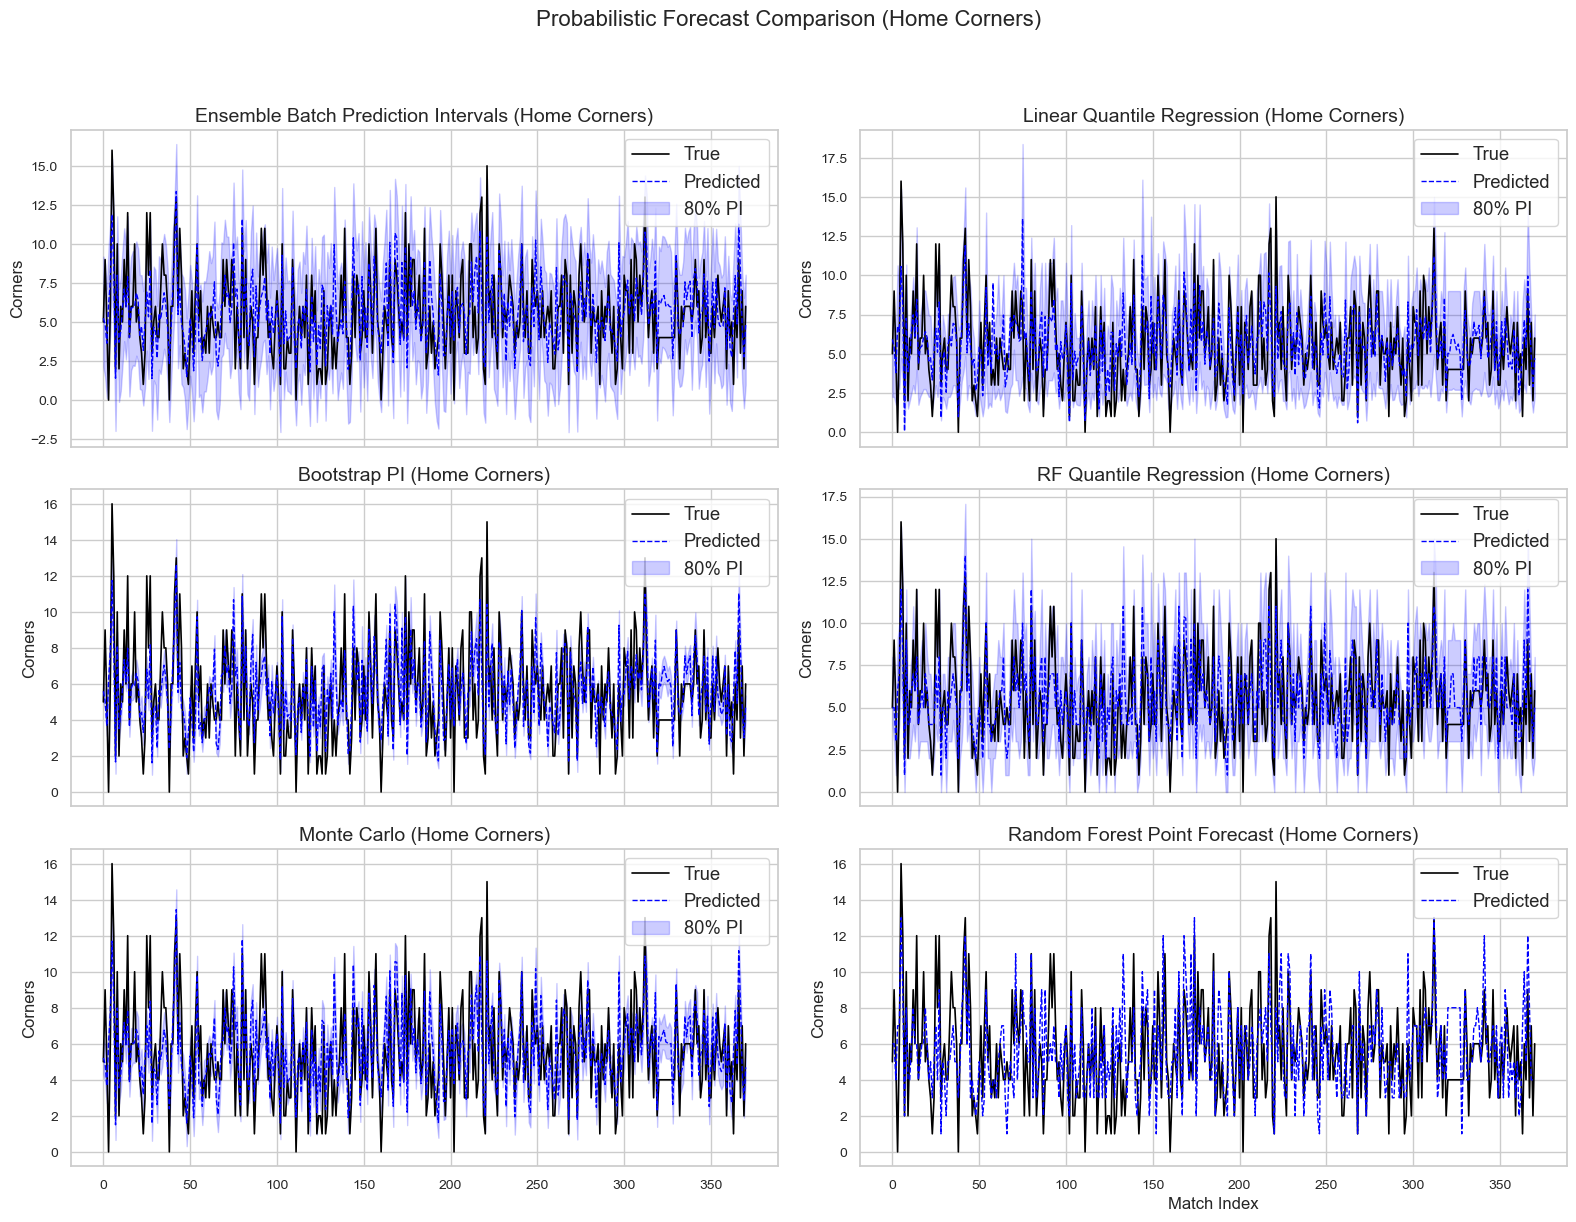

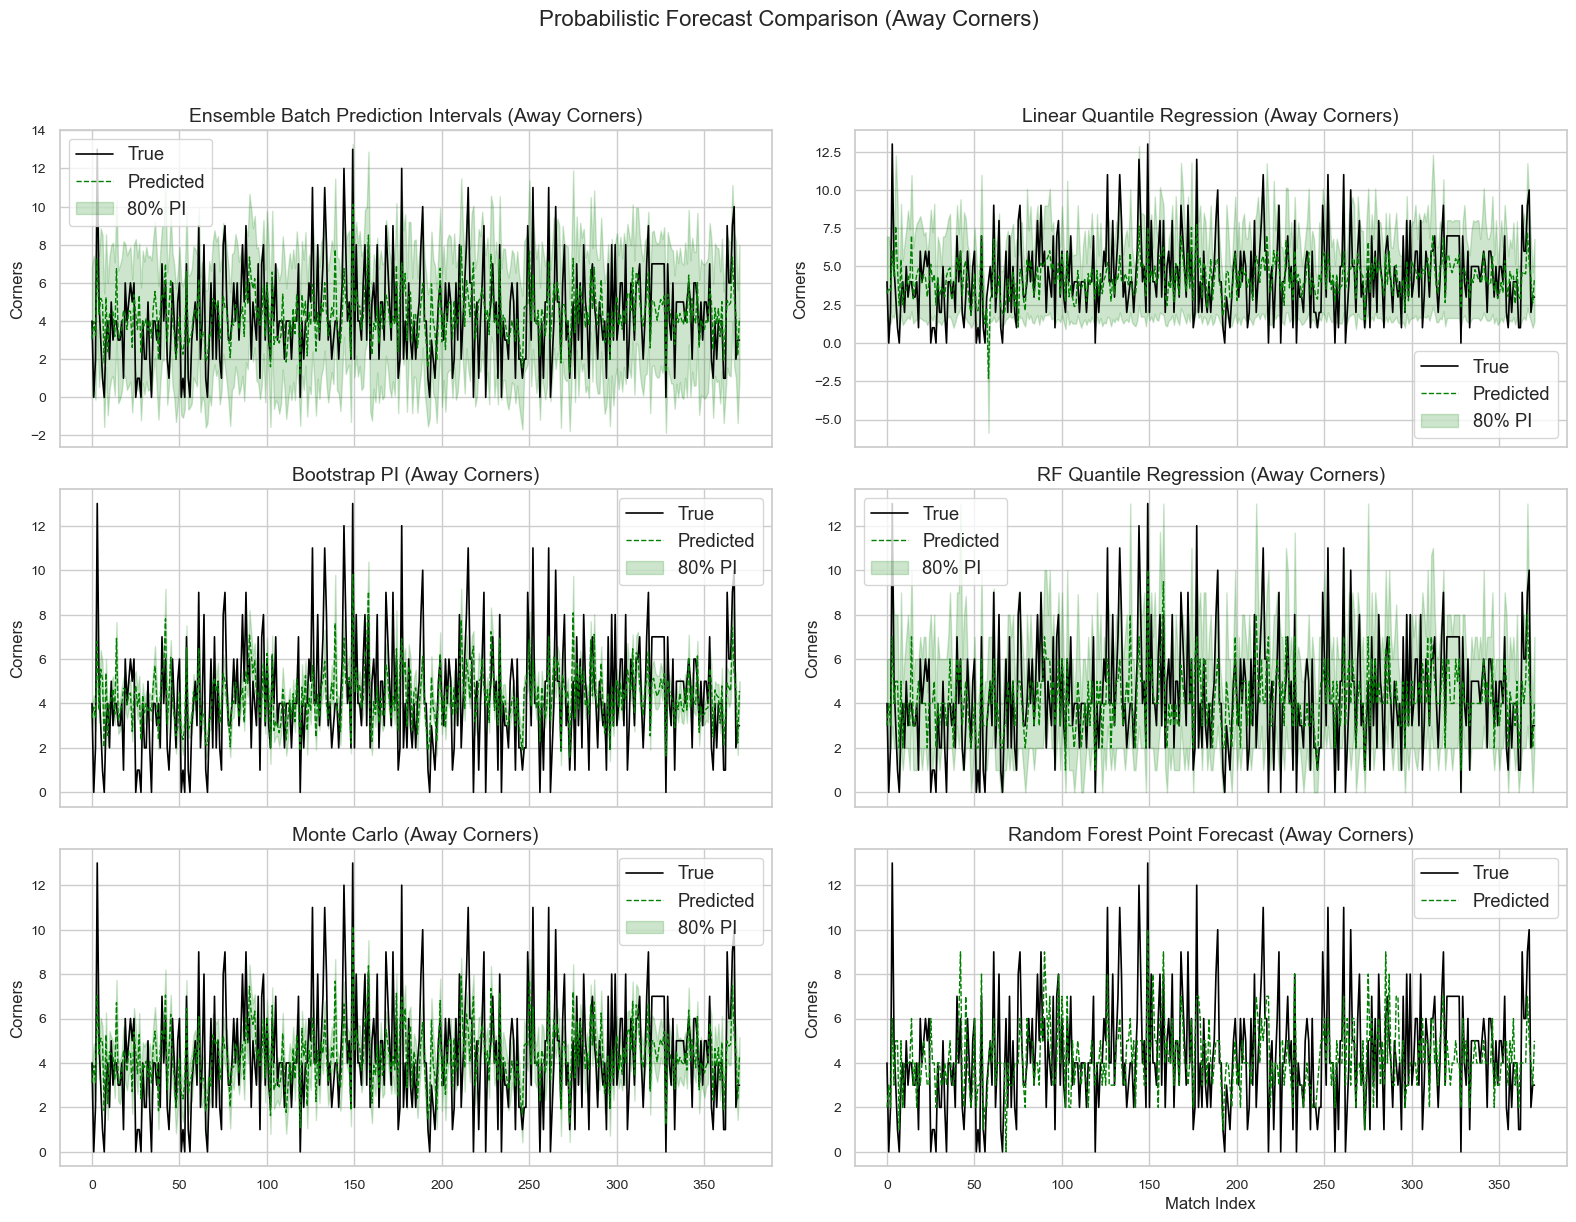

In [417]:
plot_groups = [
    (df_home_11, df_away_12, "Ensemble Batch Prediction Intervals"),
    (df_home_21, df_away_22, "Linear Quantile Regression"),
    (df_home_31, df_away_32, "Bootstrap PI"),
    (df_home_41, df_away_42, "RF Quantile Regression"),
    (df_home_51, df_away_52, "Monte Carlo"),
    (df_home_61, df_away_62, "Random Forest Point Forecast")
]
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()
for i, (df_home, df_away, title) in enumerate(plot_groups):
    ax = axes[i]
    y_pred_col = "q_50" if "q_50" in df_home.columns else "y_pred"
    y_lo_col = "q_10" if "q_10" in df_home.columns else "y_lo"
    y_hi_col = "q_90" if "q_90" in df_home.columns else "y_hi"
    ax.plot(df_home["y_true"].values, label="True", color="black", linewidth=1.2)
    ax.plot(df_home[y_pred_col].values, label="Predicted", color="blue", linestyle="--", linewidth=1)
    if y_lo_col in df_home.columns and y_hi_col in df_home.columns:
        ax.fill_between(
            range(len(df_home)),
            df_home[y_lo_col].values,
            df_home[y_hi_col].values,
            color="blue",
            alpha=0.2,
            label="80% PI"
        )
    ax.set_title(f"{title} (Home Corners)")
    ax.set_ylabel("Corners")
    ax.grid(True)
    ax.legend()
plt.xlabel("Match Index")
plt.tight_layout()
plt.suptitle("Probabilistic Forecast Comparison (Home Corners)", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)
plt.show()
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()
for i, (df_home, df_away, title) in enumerate(plot_groups):
    ax = axes[i]
    y_pred_col = "q_50" if "q_50" in df_away.columns else "y_pred"
    y_lo_col = "q_10" if "q_10" in df_away.columns else "y_lo"
    y_hi_col = "q_90" if "q_90" in df_away.columns else "y_hi"
    ax.plot(df_away["y_true"].values, label="True", color="black", linewidth=1.2)
    ax.plot(df_away[y_pred_col].values, label="Predicted", color="green", linestyle="--", linewidth=1)
    if y_lo_col in df_away.columns and y_hi_col in df_away.columns:
        ax.fill_between(
            range(len(df_away)),
            df_away[y_lo_col].values,
            df_away[y_hi_col].values,
            color="green",
            alpha=0.2,
            label="80% PI"
        )

    ax.set_title(f"{title} (Away Corners)")
    ax.set_ylabel("Corners")
    ax.grid(True)
    ax.legend()
plt.xlabel("Match Index")
plt.tight_layout()
plt.suptitle("Probabilistic Forecast Comparison (Away Corners)", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.92)
plt.show()


Bootstrap and Monte Carlo are far too narrow and fail to meet close to the required coverage. 

EnbPI and RF QR are the best approaches.

The top point forecast model was thrown in out of interest.

Left out due to time constraints:

Residual Analysis-

1.) Residual Plots

2.) Autocorrelation in Residuals